## Preamble

### Project Template

In [1]:
%load_ext autoreload

In [2]:
import os as _os

_os.chdir(_os.environ["PROJECT_ROOT"])
_os.path.realpath(_os.path.curdir)

'/pollard/data/projects/bsmith/strain-corr'

### Imports

In [3]:
import os
import subprocess
import sys
import time
from datetime import datetime
from glob import glob
from itertools import chain, product
from tempfile import mkstemp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import mpltern
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import sfacts as sf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xarray as xr
from matplotlib_venn import venn2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

import lib.plot
from lib.dissimilarity import load_dmat_as_pickle
from lib.pandas_util import align_indexes, aligned_index, idxwhere, invert_mapping

/pollard/home/bsmith/.snakemake/conda/8dd43b17b83f3accb639079fe0075b14_/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

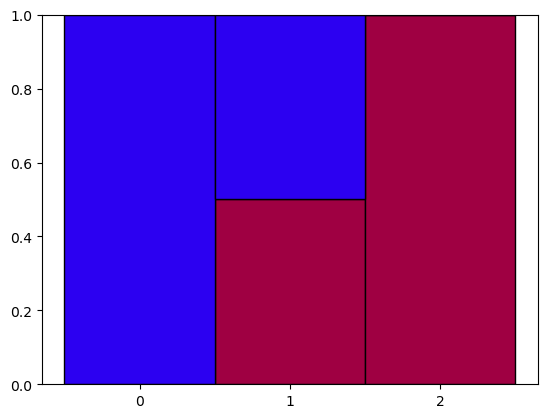

In [4]:
def linkage_order(linkage, labels):
    return labels[sp.cluster.hierarchy.to_tree(linkage).pre_order(lambda x: x.id)]


def plot_stacked_barplot(data, x_var, order, palette=None, ax=None, **kwargs):
    if ax is None:
        ax = plt.subplot()
    if palette is None:
        palette = lib.plot.construct_ordered_palette(order)

    # Bar styles
    bar_kwargs = dict(
        width=1.0,
        alpha=1.0,
        edgecolor="k",
        lw=1,
    )
    bar_kwargs.update(kwargs)

    # Plot each bar segment
    _last_top = 0
    for y_var in order:
        ax.bar(
            x=data[x_var],
            height=data[y_var],
            bottom=_last_top,
            label=y_var,
            color=palette[y_var],
            **bar_kwargs,
        )
        _last_top += data[y_var]
    ax.set_xticks(data[x_var].values)
    return ax


plot_stacked_barplot(
    pd.DataFrame(dict(t=[0, 1, 2], y1=[0.0, 0.5, 1.0], y2=[1.0, 0.5, 0.0])),
    x_var="t",
    order=["y1", "y2"],
)

In [5]:
import lib.thisproject.data

### Set Style

In [6]:
sns.set_context("talk")
plt.rcParams["figure.dpi"] = 100

## Metadata

In [7]:
mgen_list = list(
    pd.read_table("meta/mgen_group.tsv")[
        lambda x: x.mgen_group_id == "ucfmt"
    ].mgen_id.values
)
len(mgen_list)

231

In [8]:
mgen = pd.read_table("meta/ucfmt/mgen.tsv", index_col="mgen_id")
sample = pd.read_table("meta/ucfmt/sample.tsv", index_col="sample_id")
subject = pd.read_table("meta/ucfmt/subject.tsv", index_col="subject_id")
assert mgen.sample_id.isin(sample.index).all()

mgen_meta = mgen.join(sample, on="sample_id").join(subject, on="subject_id")

In [9]:
sample.loc[mgen_meta.loc[mgen_list].sample_id].sample_type.value_counts()

sample_type
maintenance        107
followup            52
donor               42
baseline            21
post_antibiotic      9
Name: count, dtype: int64

In [10]:
mgen_list = list(mgen_meta.index)

In [11]:
subject[lambda x: ~x.remission.isna() & x.recipient].donor_subject_id.value_counts()

donor_subject_id
D0097    8
D0044    8
D0485    5
D0065    1
Name: count, dtype: int64

In [12]:
d97_mgen_list = idxwhere(mgen_meta.subject_id == "D0097")
d44_mgen_list = idxwhere(mgen_meta.subject_id == "D0044")

(len(d97_mgen_list), len(d44_mgen_list))

(31, 10)

### StrainPGC Post-filtering Strains

In [13]:
spgc_meta = pd.read_table(
    f"data/group/ucfmt/species/sp-102506/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.strain_meta_spgc_and_ref.tsv",
    index_col="genome_id",
)
spgc_strain_list = spgc_meta[
    lambda x: x.passes_filter & x.genome_type.isin(["SPGC"])
].index.values  # .astype(str)
len(spgc_strain_list)

18

In [14]:
gene_x_eggnog = pd.read_table(
    "data/species/sp-102506/midasdb_v20.emapper.gene75_x_eggnog.tsv"
)

## Strain tracking

In [15]:
strain_fit = sf.data.World.load(
    "data/group/ucfmt/species/sp-102506/r.proc.gtpro.sfacts-fit.world.nc"
).rename_coords(strain=str)

np.random.seed(0)
position_ss = strain_fit.random_sample(position=1000).position
sample_linkage = strain_fit.unifrac_linkage(optimal_ordering=True)
sample_linkage_alt = strain_fit.metagenotype.linkage(optimal_ordering=True)
strain_linkage = strain_fit.genotype.linkage(optimal_ordering=True)
position_linkage = strain_fit.metagenotype.sel(position=position_ss).linkage("position")

print(sf.evaluation.metagenotype_error2(strain_fit, discretized=True)[0])

0.0177652258425951


### Visualize strain tracking

/include/StrainFacts/sfacts/plot.py:163: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)
/include/StrainFacts/sfacts/plot.py:175: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)


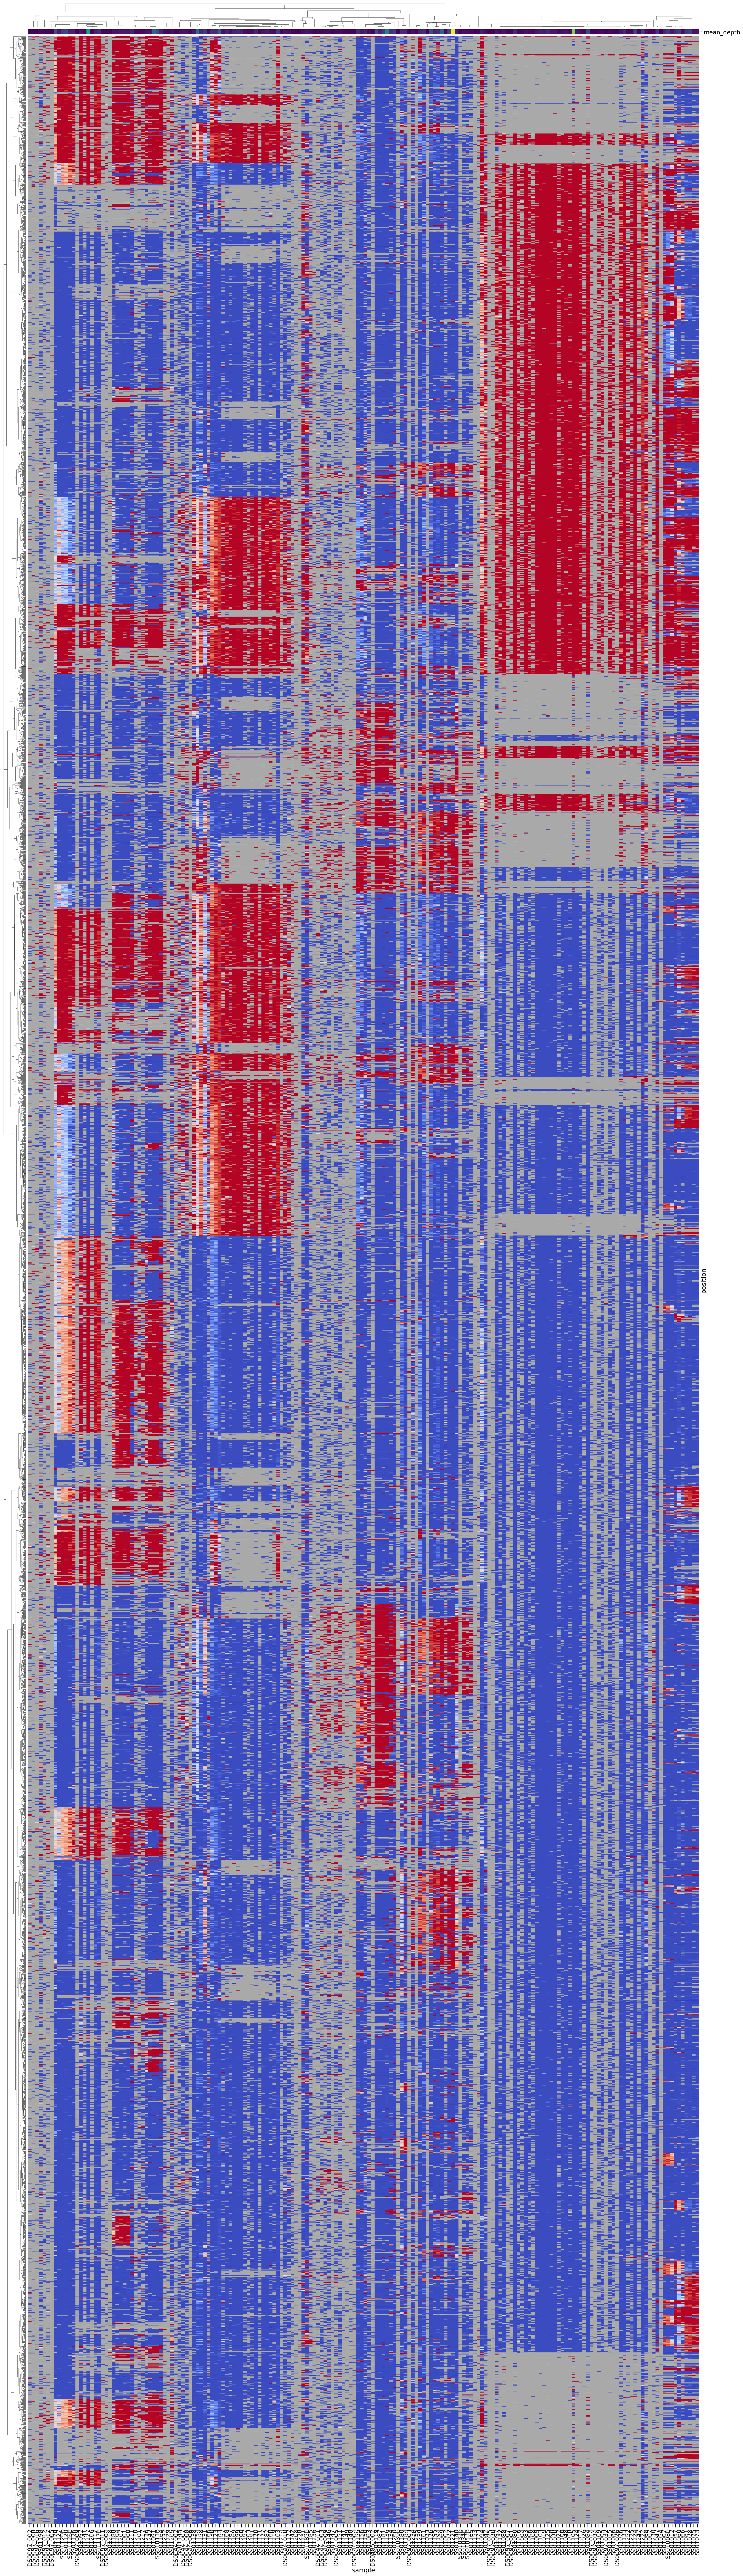

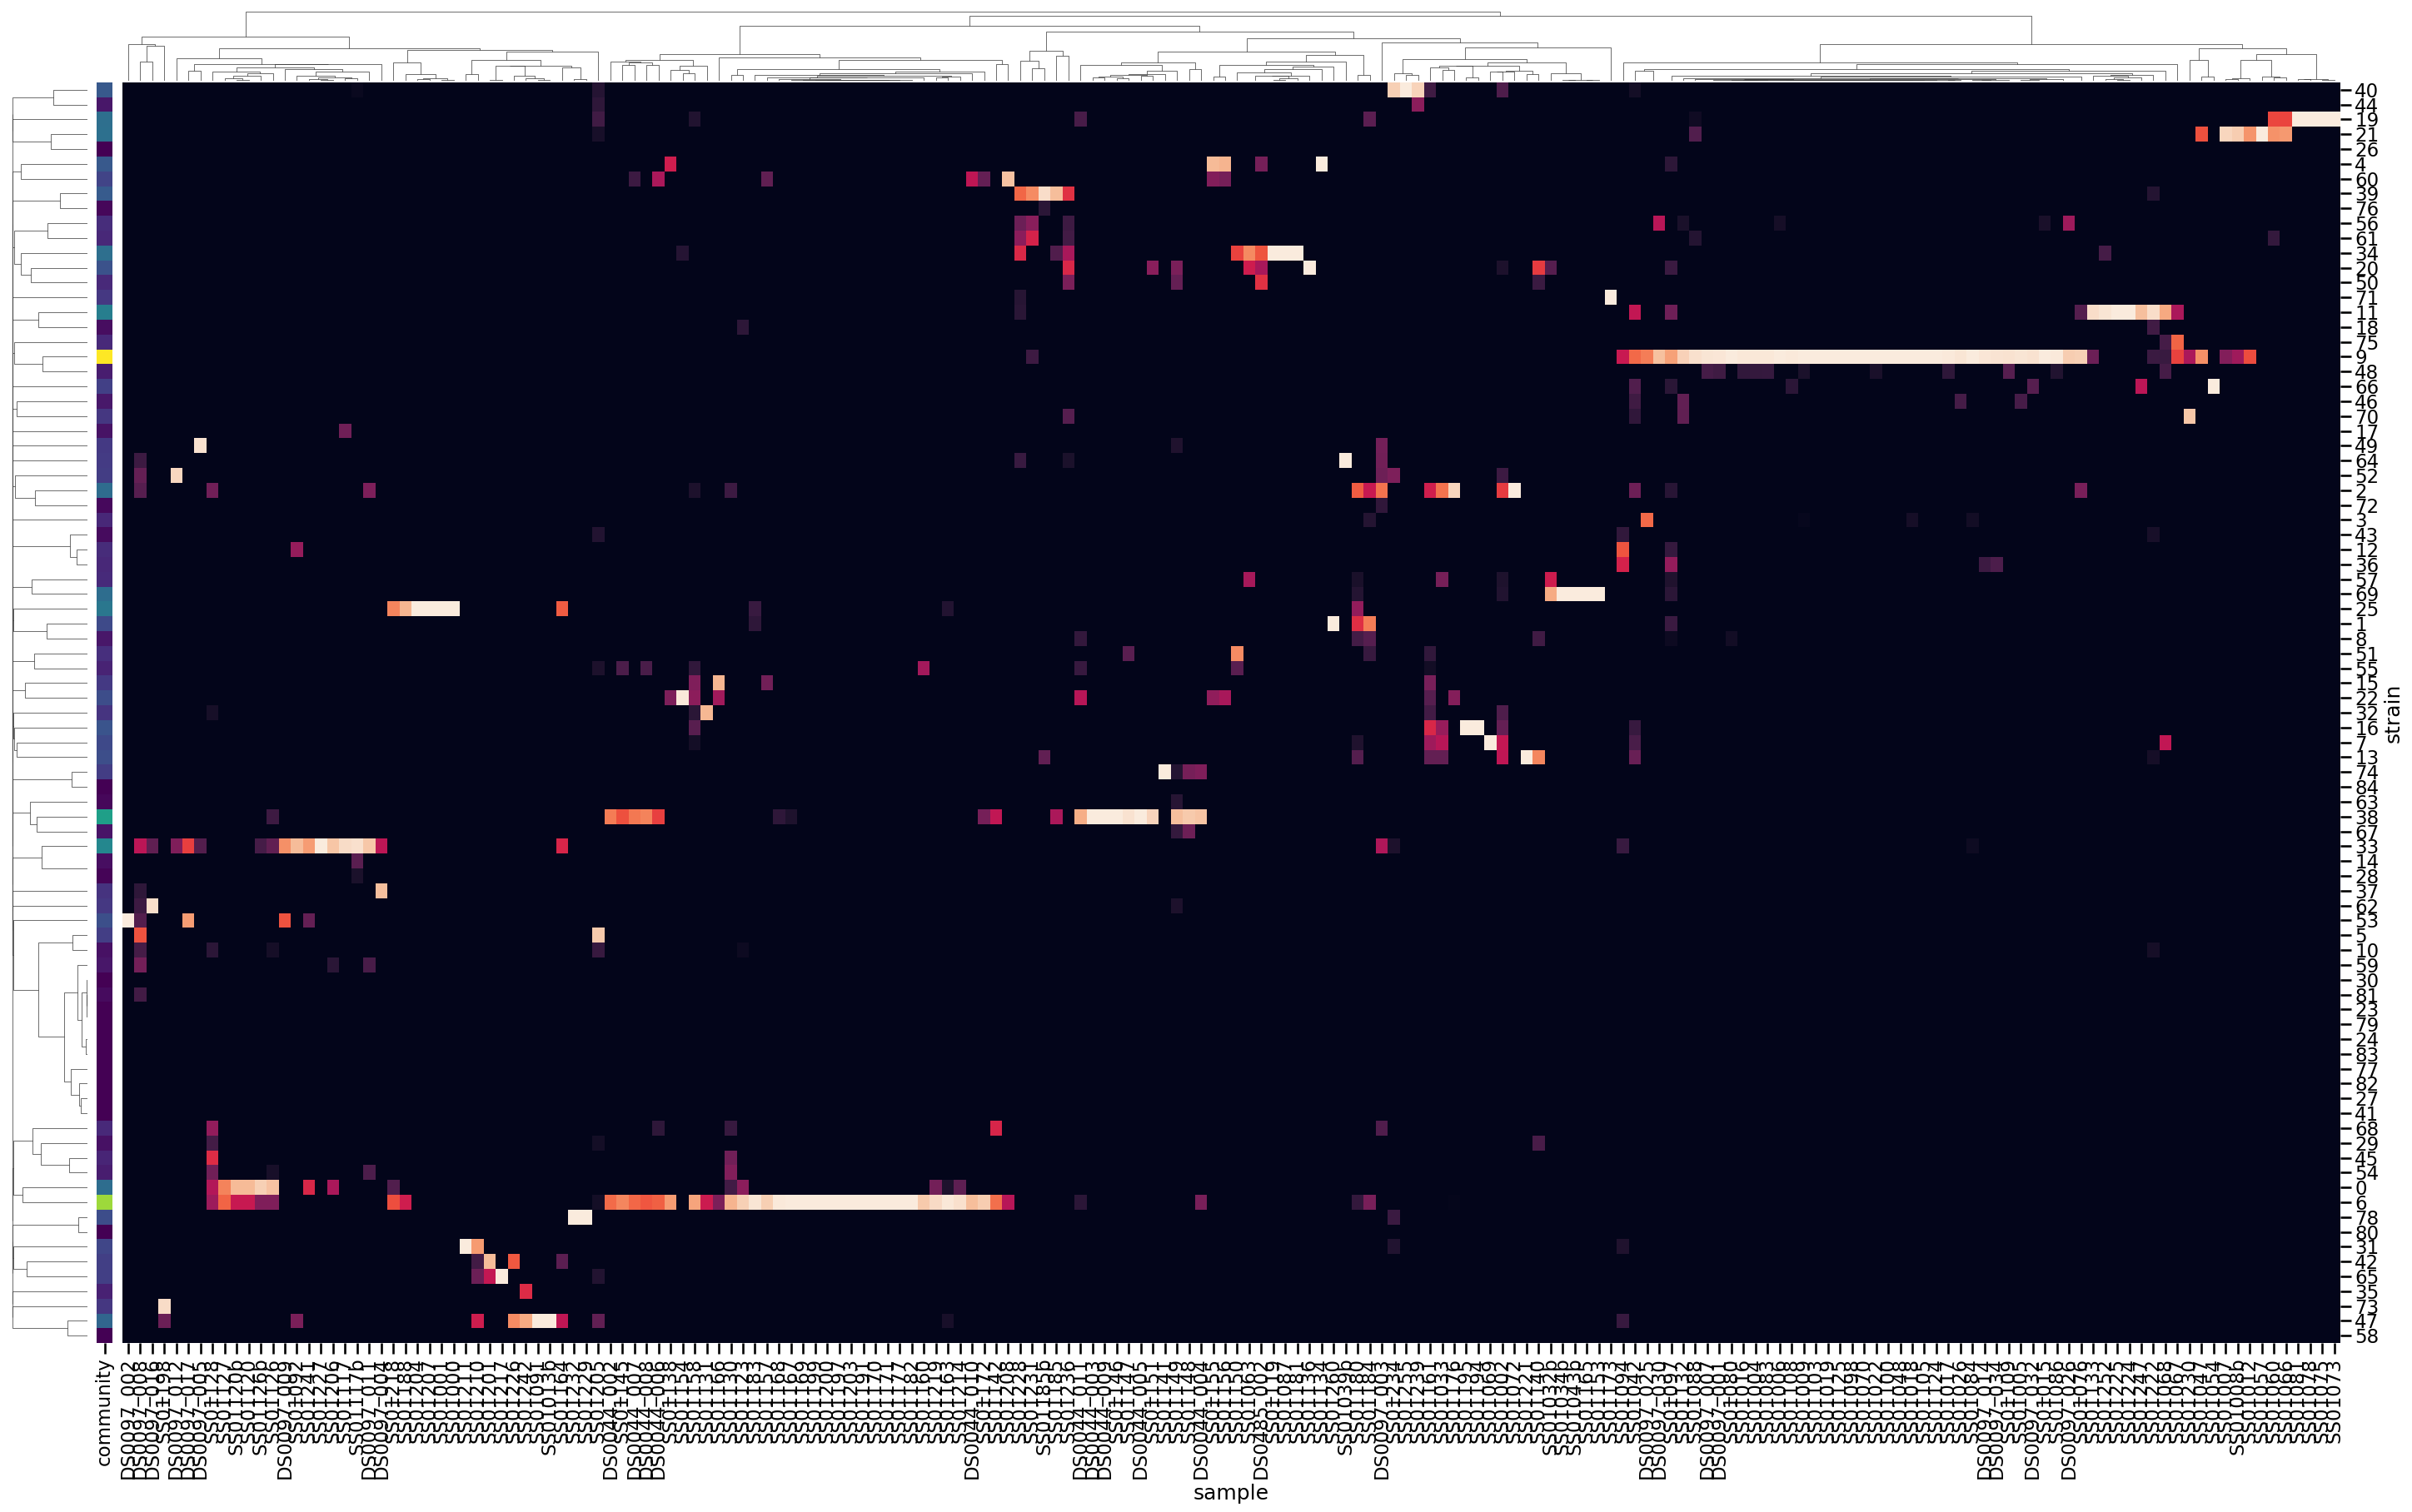

In [16]:
sf.plot.plot_metagenotype(strain_fit, col_linkage_func=lambda w: sample_linkage_alt)
sf.plot.plot_community(strain_fit, col_linkage_func=lambda w: sample_linkage_alt)

<Axes: xlabel='strain', ylabel='donor_subject_id-subject_id-sample_class'>

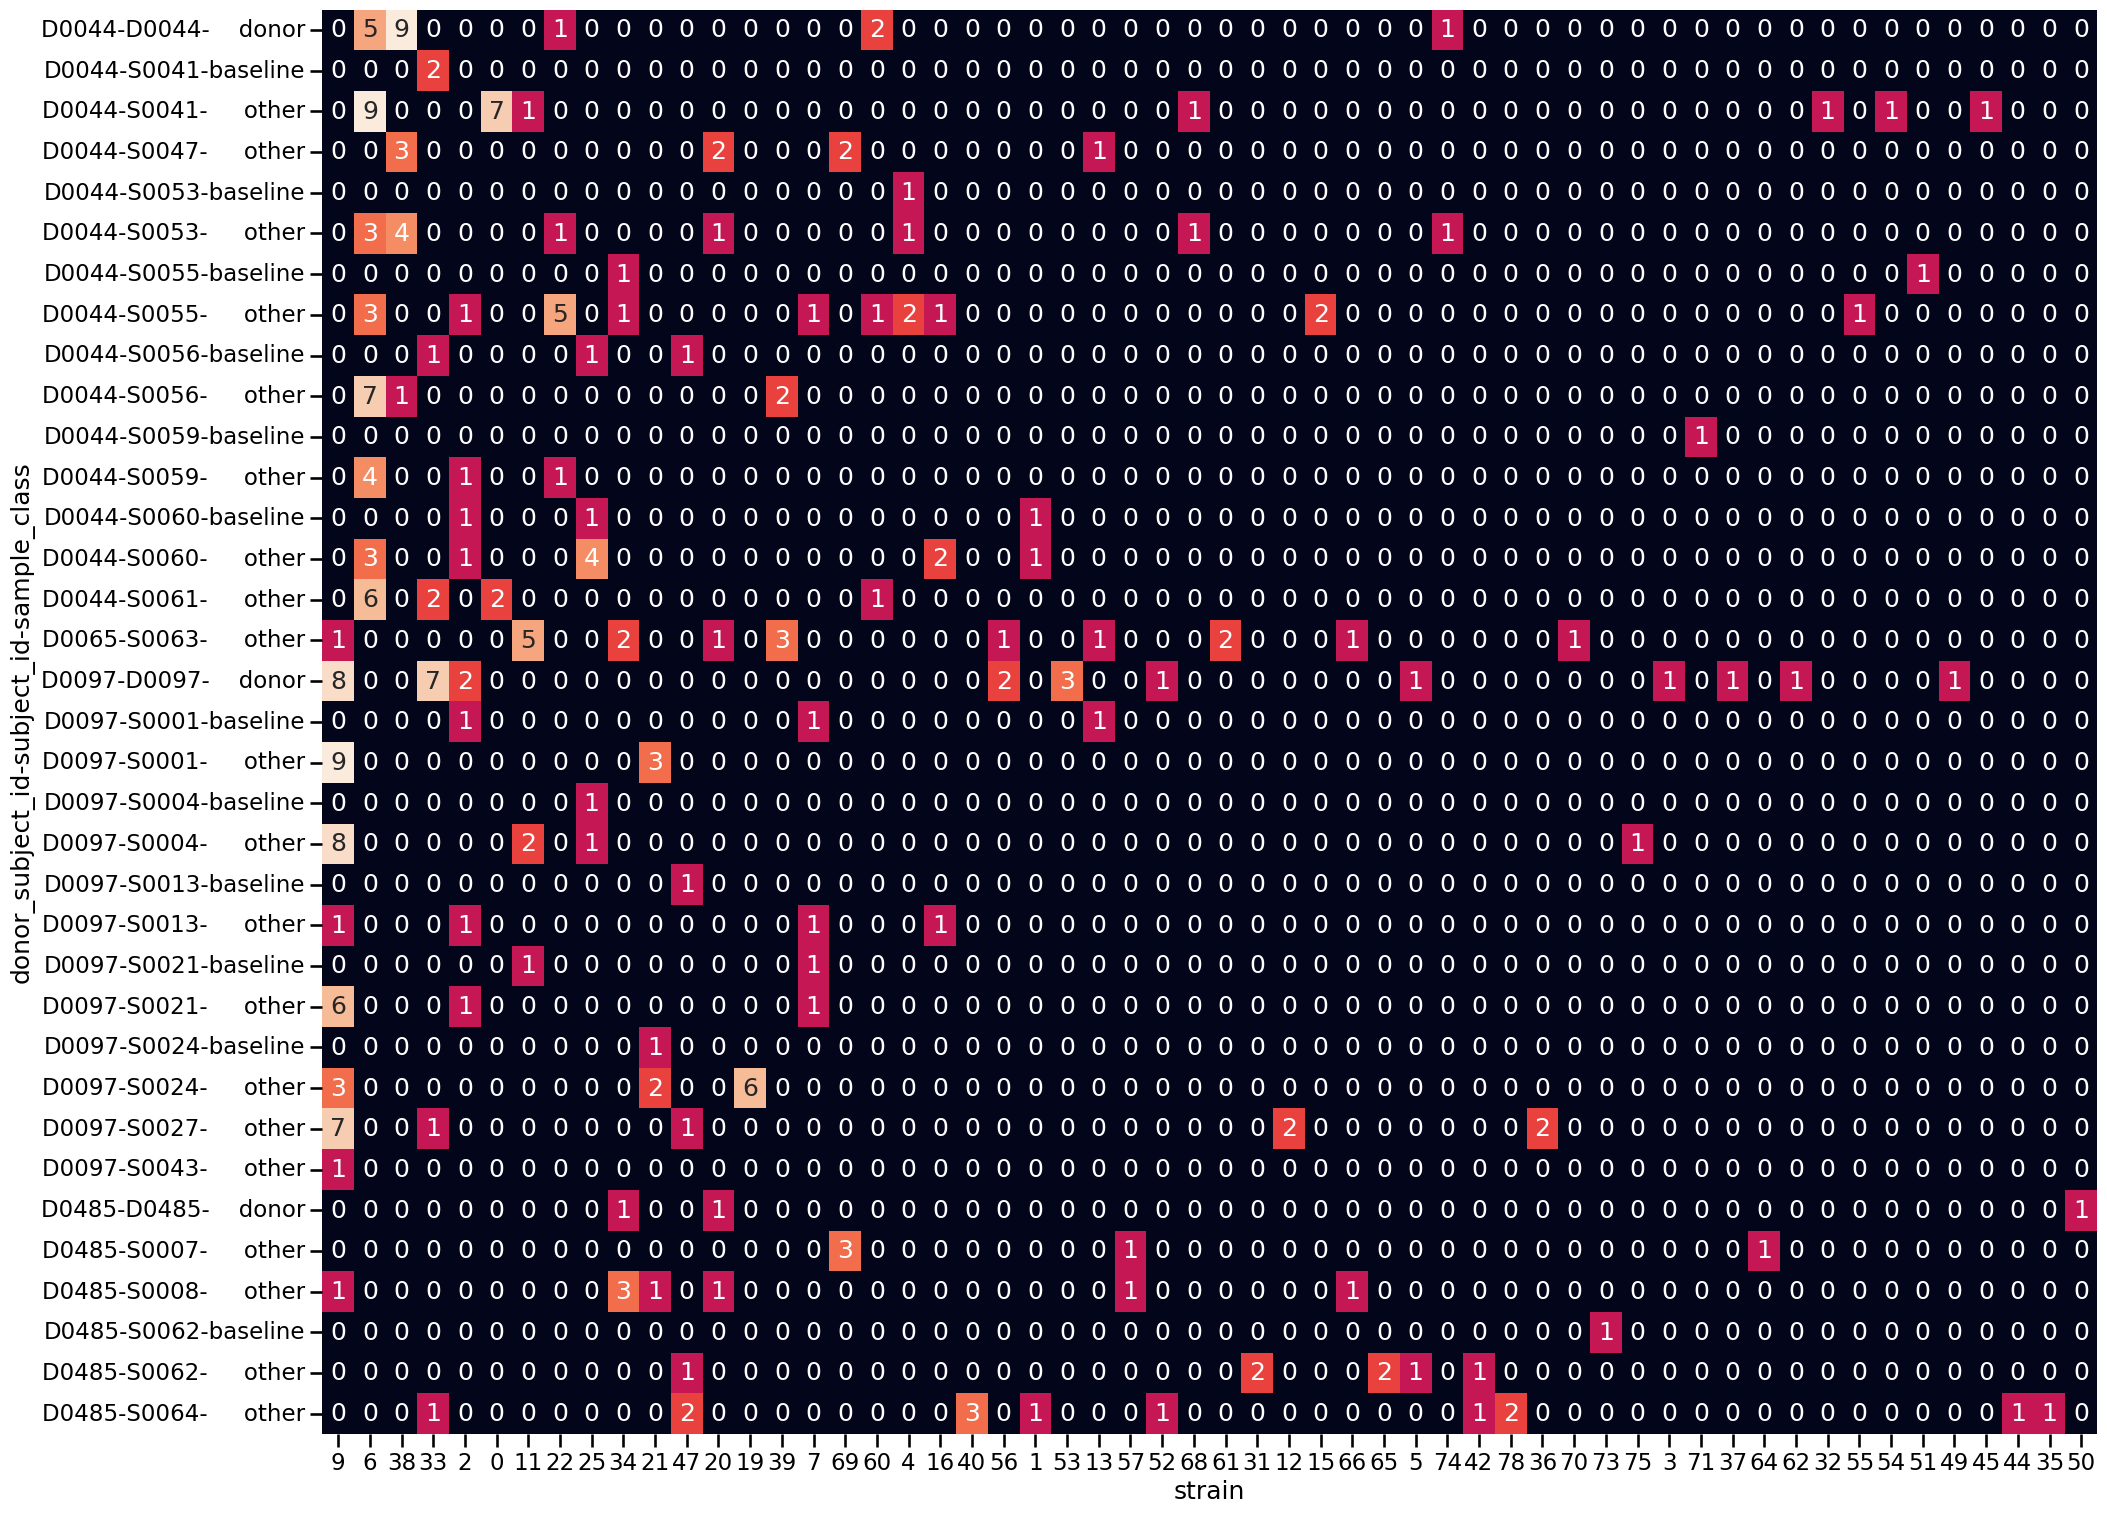

In [17]:
w_all = strain_fit.drop_low_abundance_strains(0.01)
_mgen_list = list(set(mgen_list) & set(w_all.sample.values))

w = w_all.sel(sample=_mgen_list).drop_low_abundance_strains(0.01)

sample_linkage = w.unifrac_linkage()
w_ss = w.random_sample(position=min(500, w.sizes["position"]))

d = (
    w.community.to_series()[lambda x: x > 0.1]
    .to_frame()
    .reset_index()
    .rename(columns=dict(sample="mgen_id"))
    .join(mgen_meta, on="mgen_id")
    .assign(
        sample_class=lambda x: x.sample_type.replace(
            {
                # Padding and renaming
                "baseline": "baseline",
                "donor": "    donor",
                "maintenance": "     other",
                "followup": "     other",
                "post_antibiotic": "     other",
            }
        )
    )
    .groupby(["donor_subject_id", "subject_id", "sample_class"])
    .strain.value_counts()
    .unstack("strain", fill_value=0)
    .sort_index(ascending=[True, True, False])
)

strain_order = d.sum().sort_values(ascending=False).index
d = d.loc[:, strain_order]

nrow, ncol = d.shape
fig, ax = plt.subplots(figsize=(0.4 * ncol + 0.5, 0.5 * nrow + 1))
sns.heatmap(d, norm=mpl.colors.PowerNorm(1 / 3), annot=True, cbar=False, ax=ax)

In [18]:
spgc_meta[lambda x: x.genome_type.isin(["SPGC"])].dropna(axis="columns")

num_gene  num_strain_sample  sum_strain_depth  max_strain_depth  \
genome_id                                                                    
1            4746.0                1.0         41.391094         41.391094   
11           5043.0                3.0         51.523204         49.609159   
13           4836.0                1.0       1307.221404       1307.221404   
16           4558.0                2.0         32.984631         20.768195   
19           4707.0                4.0         99.854297         49.593728   
2            4732.0                1.0         64.099720         64.099720   
20           4605.0                1.0        238.484270        238.484270   
21           5111.0                1.0         27.503428         27.503428   
22           5788.0                1.0        180.855702        180.855702   
25           5538.0                4.0         24.795711          7.422085   
31           4732.0                1.0         12.278833         12.278833   
33           4743.0                1.0        417.241909        417.241909   
34           5380.0                3.0        113.641697         65.637619   
38           4417.0                4.0          4.551382          1.462560   
4            3401.0                1.0         19.122093         19.122093   
40           1524.0                1.0          0.071664          0.071664   
47           5479.0                2.0        199.503390        134.118045   
49           1575.0                1.0          0.053628          0.053628   
53           2907.0                1.0          0.321278          0.321278   
6            5215.0               14.0        274.038040        134.347016   
64           2715.0                1.0          0.239862          0.239862   
65           4390.0                1.0          0.961204          0.961204   
66           1130.0                1.0          0.038859          0.038859   
69           5163.0                4.0          5.694336          2.305145   
7            4830.0                1.0        122.119247        122.119247   
71           4638.0                1.0          0.348041          0.348041   
74           2059.0                1.0          0.247614          0.247614   
78           4151.0                2.0          0.839600          0.618578   
9            5611.0               28.0       1084.392390        918.435145   

           species_gene_frac  log_selected_gene_depth_ratio_std  \
genome_id                                                         
1                   0.989547                           0.179158   
11                  0.993806                           0.183491   
13                  0.998064                           0.175523   
16                  0.992257                           0.183669   
19                  0.994580                           0.170819   
2                   0.995741                           0.173841   
20                  0.994193                           0.185383   
21                  0.991483                           0.182898   
22                  0.998064                           0.199821   
25                  0.989934                           0.213592   
31                  0.986063                           0.188931   
33                  0.996903                           0.170338   
34                  0.996516                           0.194373   
38                  0.912118                           0.268346   
4                   0.817267                           0.327365   
40                  0.267131                           0.415826   
47                  0.998064                           0.197015   
49                  0.231127                           0.554078   
53                  0.602787                           0.296004   
6                   0.993419                           0.210117   
64                  0.516067                           0.552047   
65                  0.822300                       

In [19]:
ucfmt_strains = list(
    spgc_meta[lambda x: x.genome_type.isin(["SPGC"]) & x.passes_filter].index
)

In [20]:
len(ucfmt_strains)

18

In [21]:
focal_strains = [
    "6",
    "9",  #'33',
    # '38',  # Unfortunately low-quality gene content inferences. :-/
]  # Defined based on dominant, donor strains in followup samples.

In [22]:
strain_order = [
    s
    for s in linkage_order(
        strain_linkage,
        strain_fit.strain.values,
    )
]
# ) if s in spgc_strain_list]

if "-1" in strain_order:
    strain_order.remove("-1")  # Drop "other" strain.
strain_order.append("-1")  # Add to end of list

strain_palette = lib.plot.construct_ordered_palette(
    strain_order,  # Linkage order, I believe
    cm="turbo",
    vmin=0.05,
    vmax=0.95,
    extend={"-1": "silver"},
    desaturate_levels=[1.0],
)

# Desaturate non-focal strains
for strain in strain_palette:
    if strain == "-1":
        continue
    if strain not in focal_strains:
        strain_palette[strain] = sns.set_hls_values(
            strain_palette[strain], l=0.35, s=0.7
        )
    else:
        strain_palette[strain] = sns.set_hls_values(
            strain_palette[strain], l=0.75, s=1.0
        )

/include/StrainFacts/sfacts/math.py:25: RuntimeWarning: invalid value encountered in scalar divide
  wmean_dist = (weight * dist).sum() / weight.sum()
/include/StrainFacts/sfacts/plot.py:163: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)
/include/StrainFacts/sfacts/plot.py:175: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)


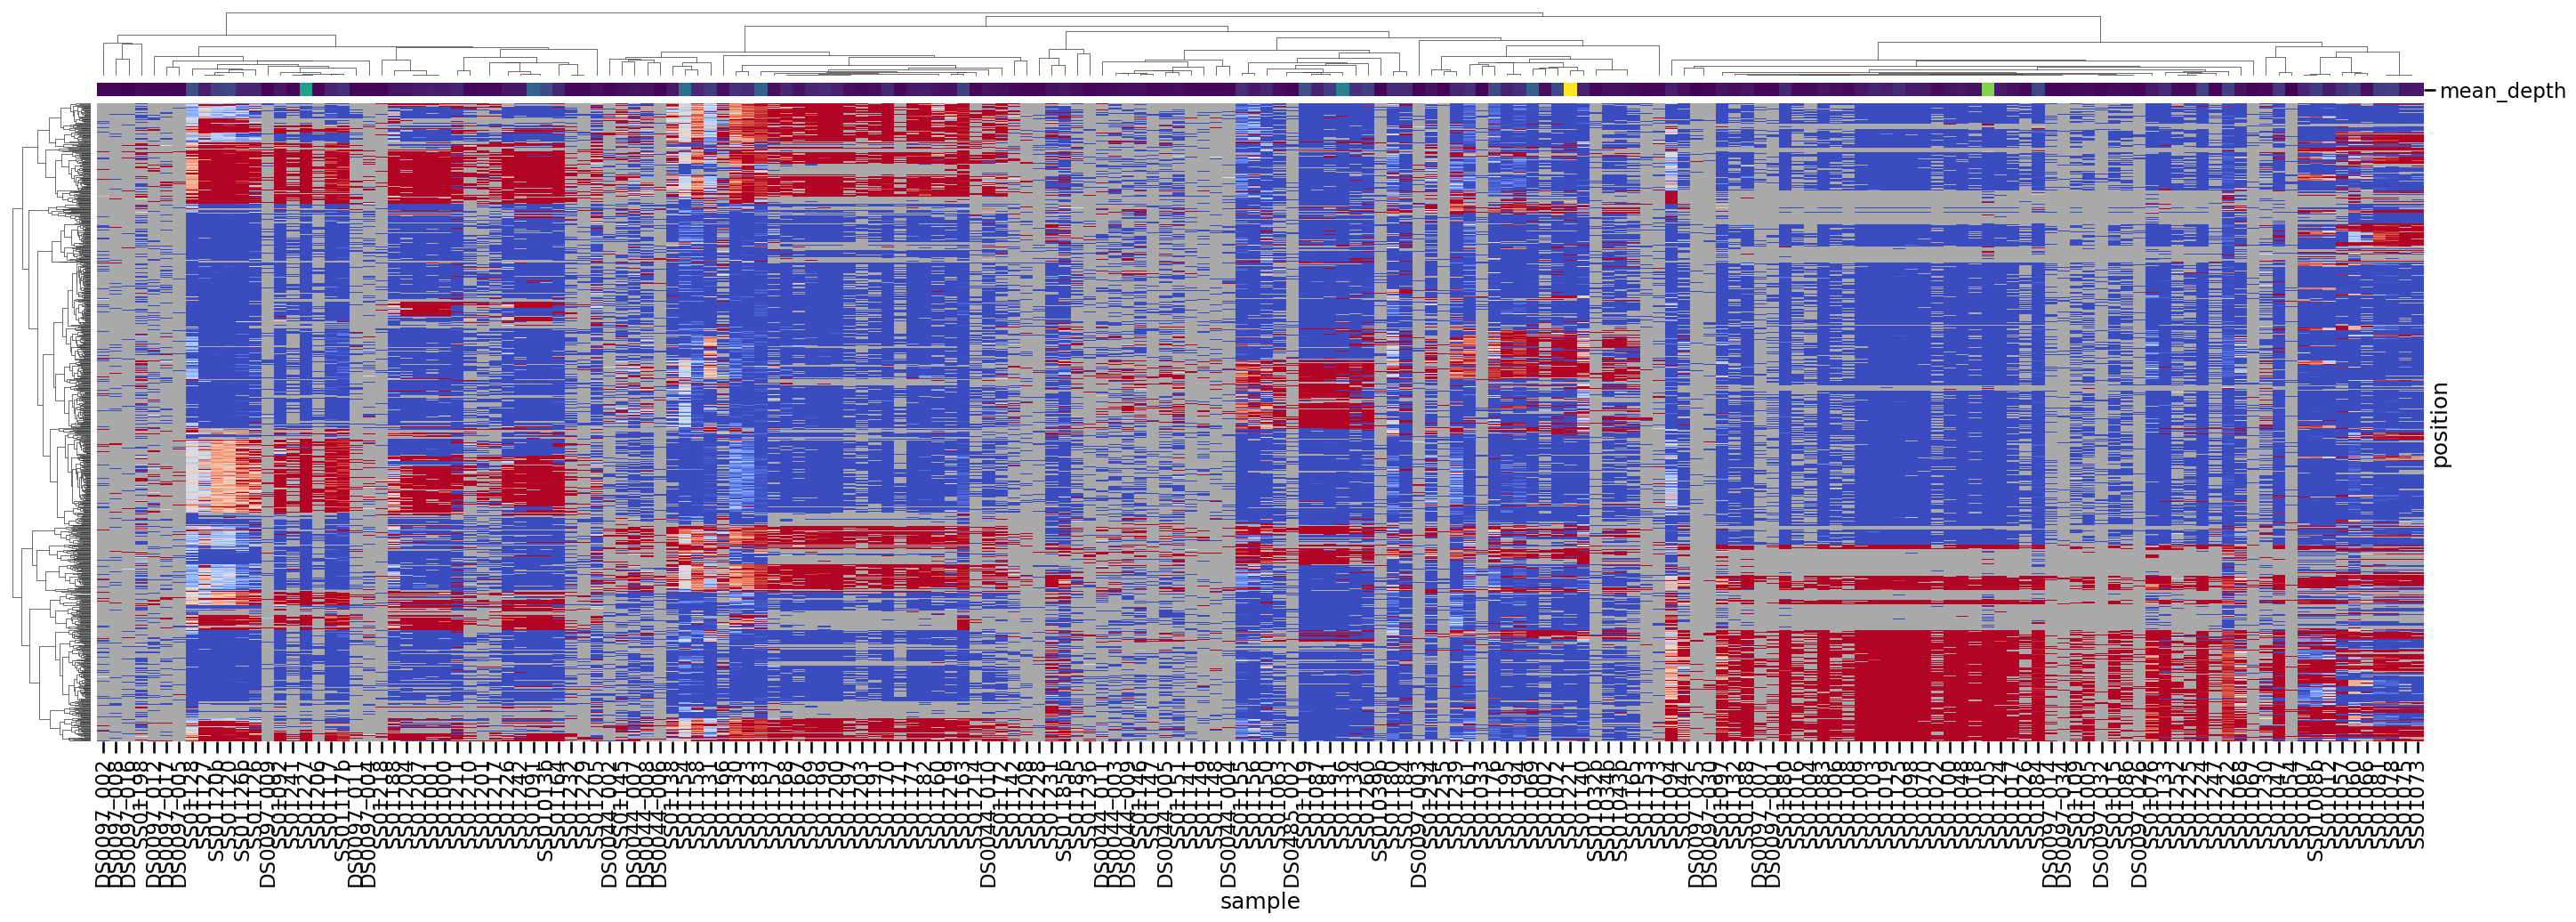

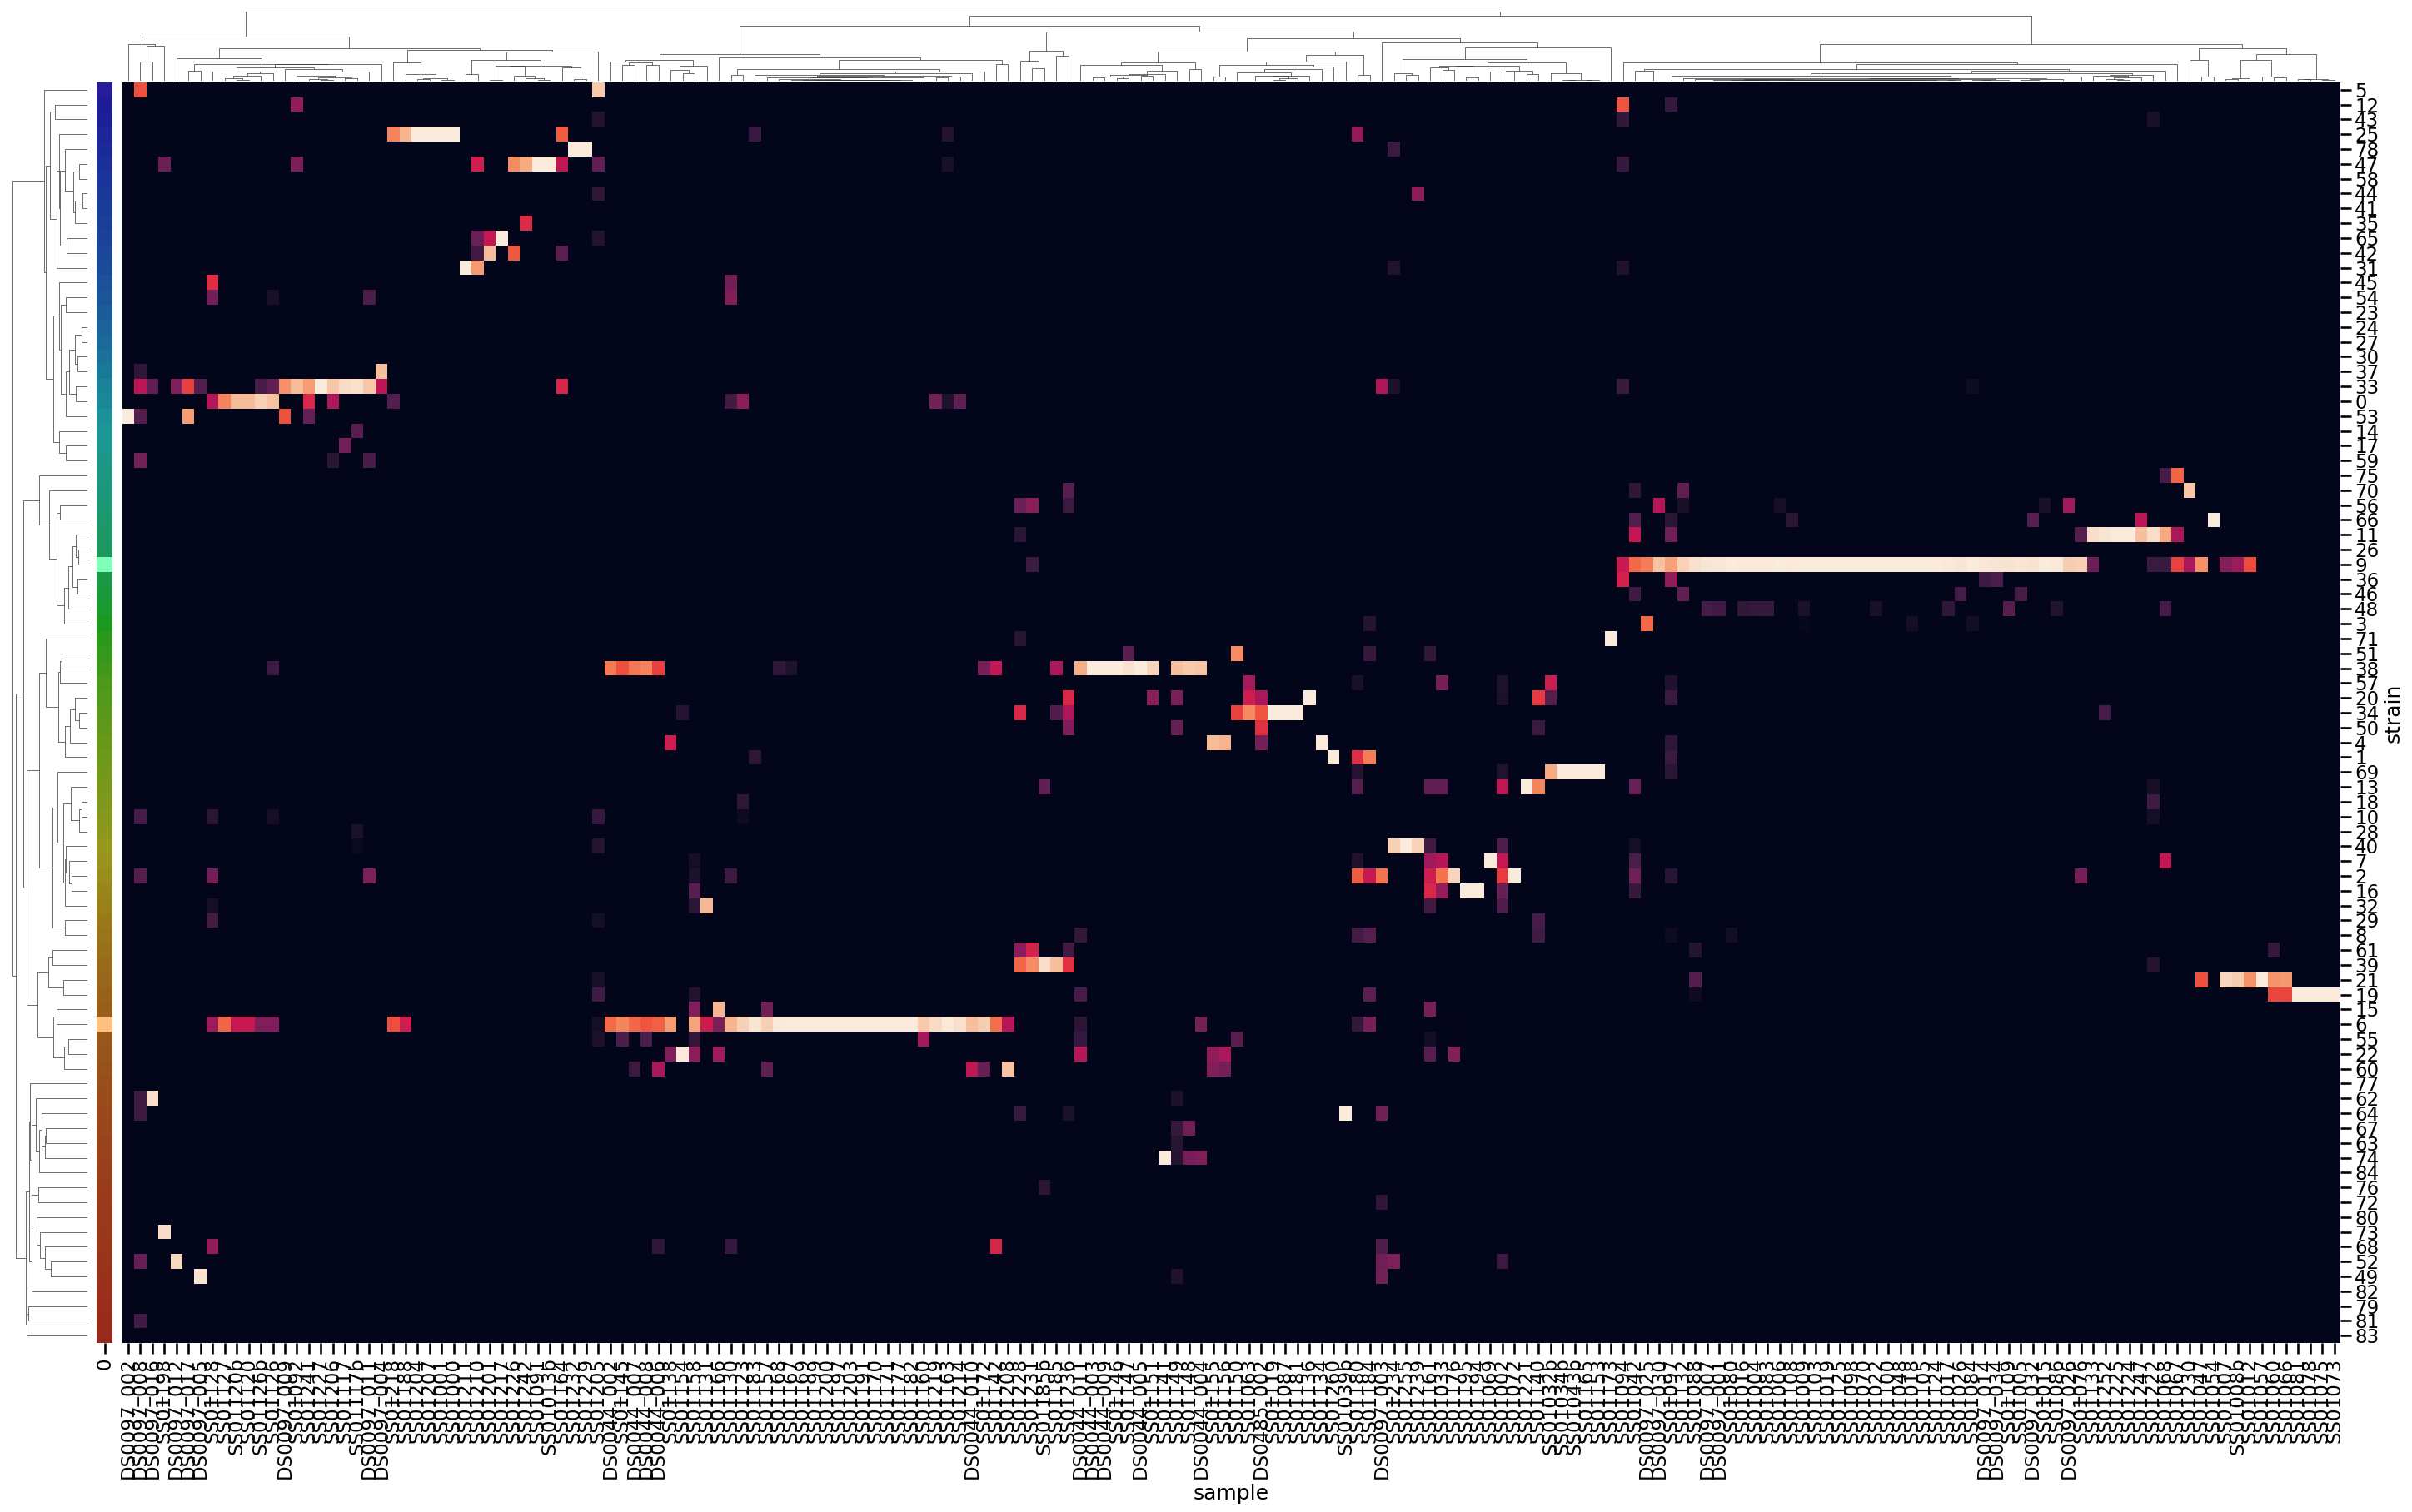

In [23]:
strain_colors = (
    pd.Series(strain_order, index=strain_order).map(strain_palette).to_frame()
)

sf.plot.plot_metagenotype(
    strain_fit.sel(position=position_ss), col_linkage=sample_linkage_alt
)
sf.plot.plot_community(
    strain_fit.sel(position=position_ss),
    col_linkage=sample_linkage_alt,
    row_linkage=strain_linkage,
    row_colors=strain_colors,
)

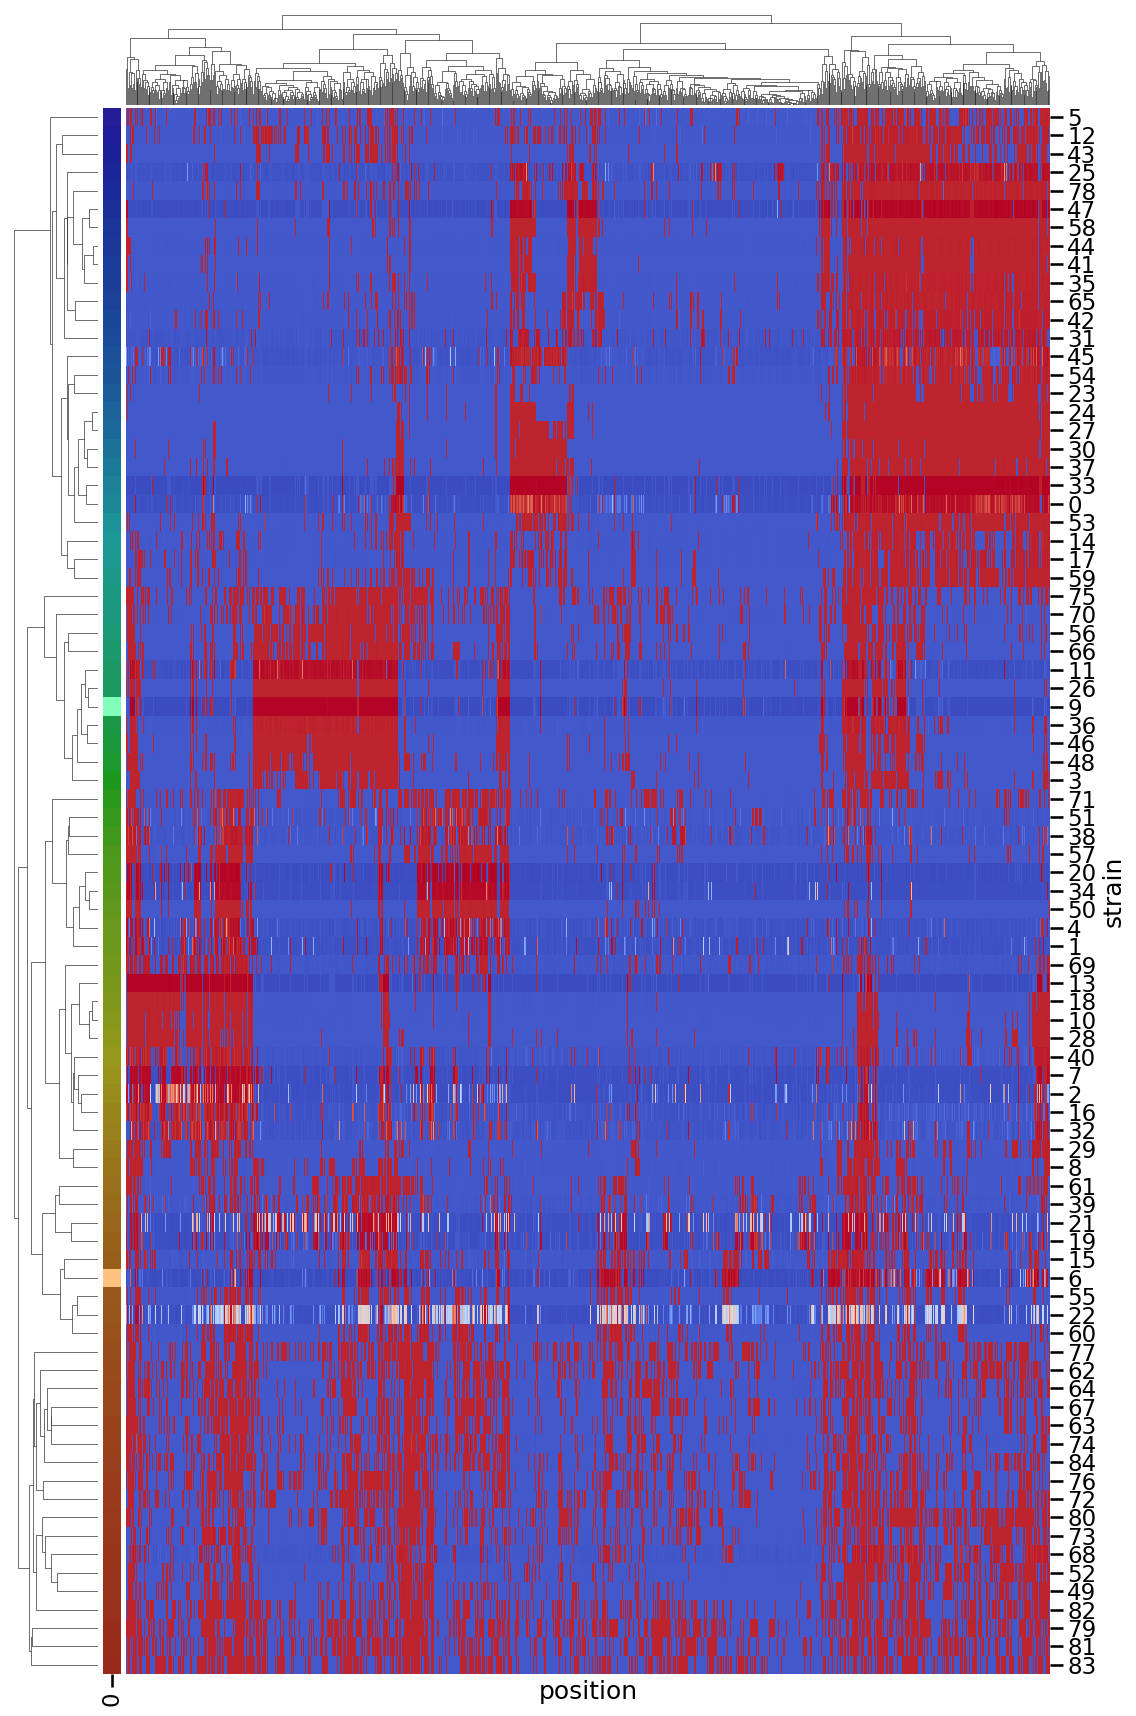

In [24]:
sf.plot.plot_genotype(
    strain_fit.sel(position=position_ss),
    row_linkage=strain_linkage,
    row_colors=strain_colors,
)

In [25]:
strain_samples = pd.read_table(
    "data/group/ucfmt/species/sp-102506/r.proc.gtpro.sfacts-fit.spgc_ss-all.strain_samples.tsv",
    names=["sample", "strain"],
    dtype=str,
)
strain_samples[lambda x: x.strain.isin(focal_strains)].sort_values(
    "strain"
).strain.value_counts()

strain
9    28
6    14
Name: count, dtype: int64

/include/StrainFacts/sfacts/plot.py:175: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)
/include/StrainFacts/sfacts/plot.py:163: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)


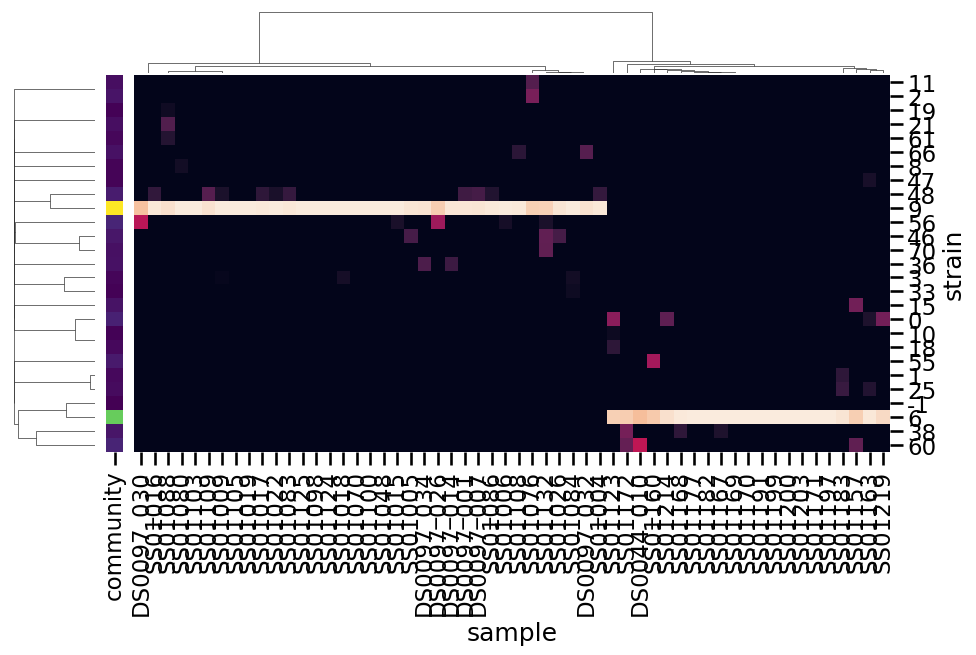

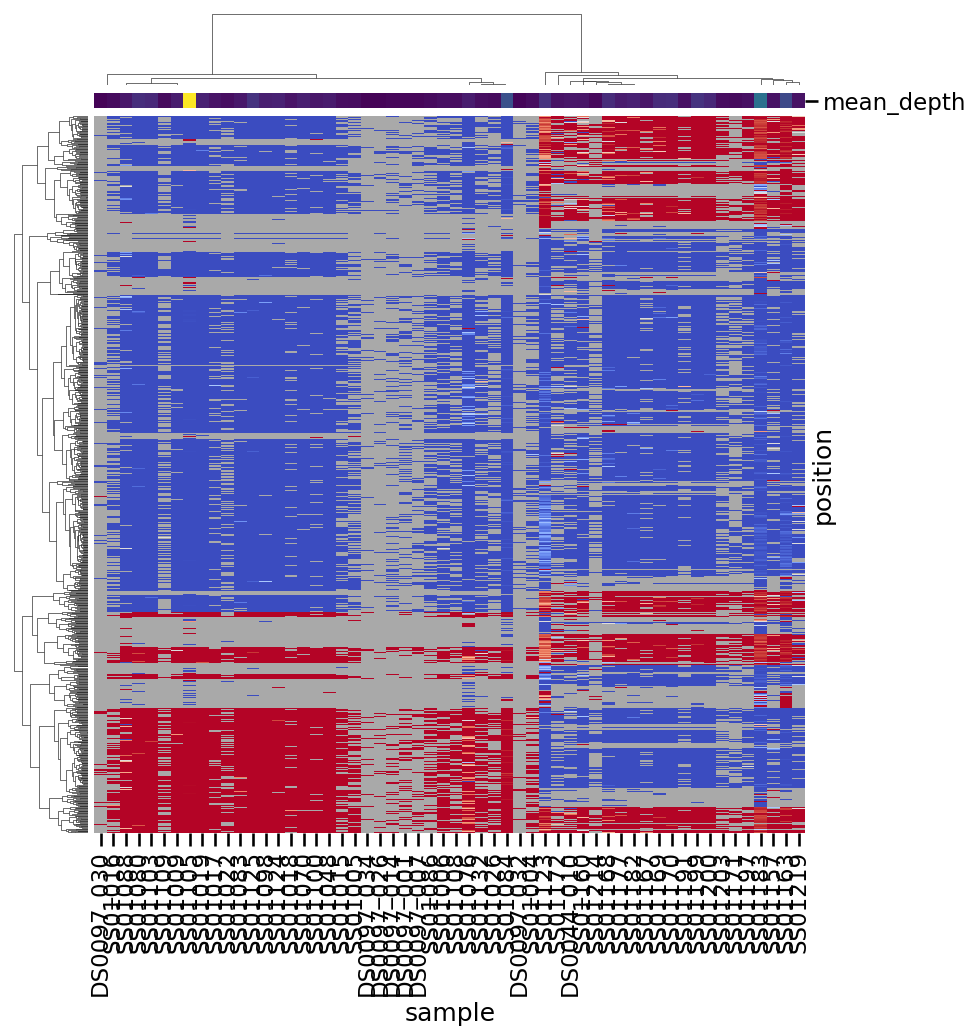

In [26]:
focal_strain_samples = idxwhere(
    (
        strain_fit.community.data.sel(strain=focal_strains).max("strain") > 0.75
    ).to_series()
)
w = strain_fit.sel(
    position=position_ss, sample=focal_strain_samples
).drop_low_abundance_strains(0.001)
sf.plot.plot_community(w, col_linkage_func=lambda w: w.metagenotype.linkage())
sf.plot.plot_metagenotype(
    w,
    row_linkage_func=lambda w: position_linkage,
    col_linkage_func=lambda w: w.metagenotype.linkage(),
)

In [27]:
sample_type_specific_relabel = {
    "donor_enema": "D",
    "donor_initial": "D",
    "donor_capsule": "D",
    "baseline": "B",
    "post_antibiotic": "pA",
    "pre_maintenance_1": "M1",
    "pre_maintenance_2": "M2",
    "pre_maintenance_3": "M3",
    "pre_maintenance_4": "M4",
    "pre_maintenance_5": "M5",
    "pre_maintenance_6": "M6",
    "followup_1": "F1",
    "followup_2": "F2",
    "followup_3": "F3",
}

/tmp/bsmith/ipykernel_929944/3533957265.py:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=c, label=strain)


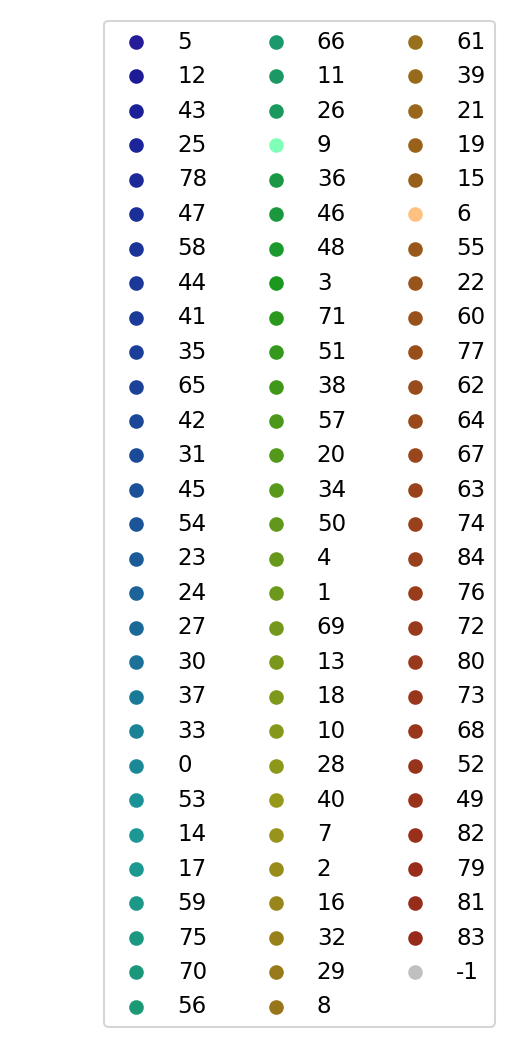

In [28]:
for strain, c in strain_colors.squeeze().items():
    plt.scatter([], [], c=c, label=strain)
plt.legend(ncols=3)
lib.plot.hide_axes_and_spines()

#### Figure 5A

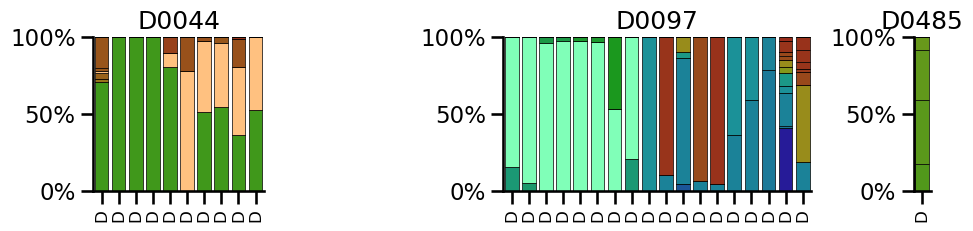

In [29]:
_meta = mgen_meta
subject_order = ["D0044", "D0097", "D0485"]

fig, axs = plt.subplots(
    1, len(subject_order), figsize=(5 * len(subject_order), 2), squeeze=False
)
for subject_id, ax in zip(subject_order, axs.flatten()):
    sample_list = (
        _meta[
            lambda x: (x.subject_id == subject_id)
            & (x.index.isin(strain_fit.sample.values))
        ]
        # .sort_values('collection_days_post_fmt')  # This will be useful for subjects, but not donors
        .index
    )

    if len(sample_list) < 2:
        sample_order = sample_list
    else:
        sample_order = list(
            linkage_order(
                strain_fit.sel(sample=sample_list).metagenotype.linkage(
                    optimal_ordering=True
                ),
                sample_list,
            )
        )

    if len(sample_list) < 1:
        subject_comm = pd.DataFrame([], columns=[-1])
    else:
        subject_comm = (
            strain_fit.sel(sample=sample_order).keep_only_strain_list(strain_order)
            # .drop_low_abundance_strains(
            #     0.0, agg_strain_coord=-1
            # )  # TODO: Check that this adds to the alread-existing strain_-1
            .community.to_pandas()
        )

    d = (
        _meta.reindex(sample_order)
        # .dropna(subset=["collection_date_relative_een_end"])
        # .sort_values("collection_date_relative_een_end")
        .assign(
            t=lambda x: range(len(x)),
        )
    ).join(subject_comm)
    # d.loc[d.index[:num_offset_samples], 't'] -= 0.7  # Offset width

    plot_stacked_barplot(
        data=d,
        x_var="t",
        order=[s for s in strain_order if s in subject_comm.columns],
        palette=strain_palette,
        ax=ax,
        width=0.8,
        lw=0.5,
    )

    ax.set_title(subject_id)
    ax.set_xticklabels(
        d.sample_type_specific.map(sample_type_specific_relabel),
        fontsize=12,
    )
    ax.set_aspect(9, anchor="NW")
    ax.set_ylim(0, 1.0)
    lib.plot.rotate_xticklabels(rotation=90, ax=ax, ha="center")
    ax.set_yticks(np.linspace(0, 1.0, num=3))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, symbol="%"))
    if not d.empty:
        ax.set_xlim(d.t.min() - 0.5, d.t.max() + 0.5)
    ax.spines[["right", "top"]].set_visible(False)

fig.savefig('fig/fig5a_donor_panels.pdf', bbox_inches='tight')

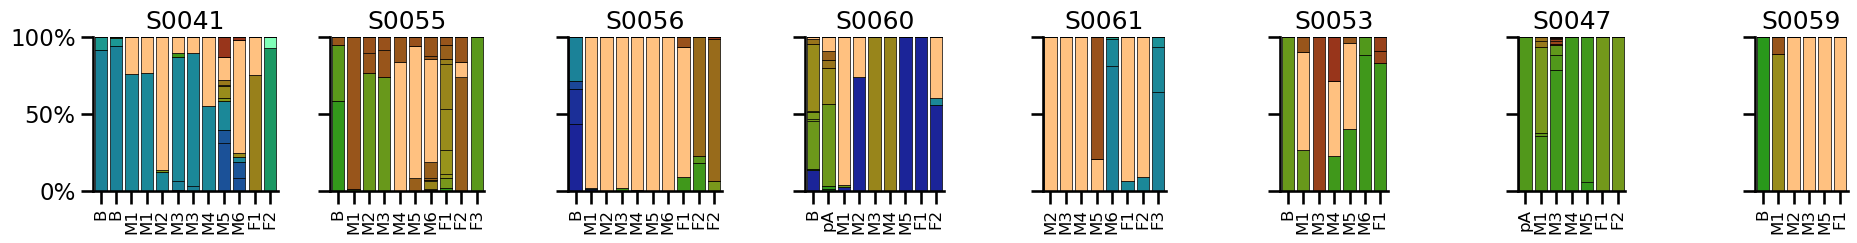

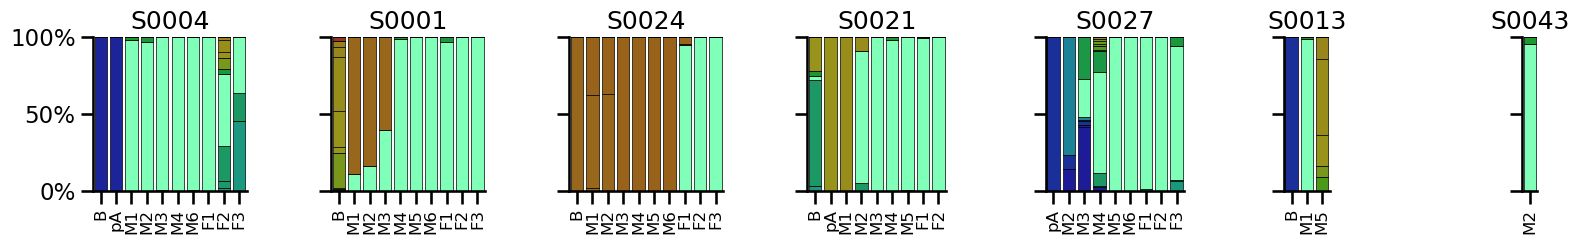

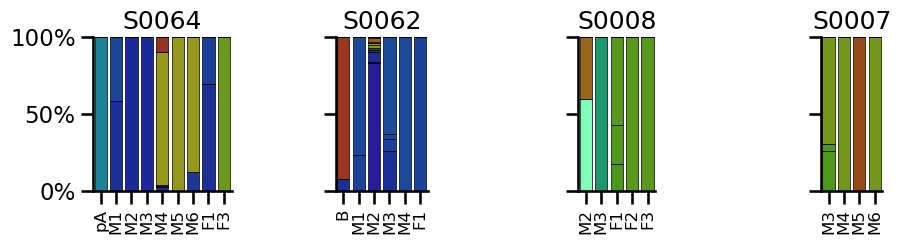

In [30]:
donor_subject_order = ["D0044", "D0097", "D0485"]
_meta = mgen_meta.loc[strain_fit.sample.values][
    lambda x: x.recipient
    # & ~x.sra_accession.isna()
]

for donor in donor_subject_order:
    subject_order = (
        _meta[lambda x: x.donor_subject_id == donor].subject_id.value_counts().index
    )
    fig, axs = plt.subplots(
        1,
        len(subject_order),
        figsize=(3 * len(subject_order), 2),
        squeeze=False,
        sharey=True,
    )
    for subject_id, ax in zip(subject_order, axs.flatten()):
        sample_order = (
            _meta[
                lambda x: (x.subject_id == subject_id)
                & (x.index.isin(strain_fit.sample.values))
            ]
            .sort_values("collection_days_post_fmt")
            .index
        )

        if len(sample_order) < 1:
            subject_comm = pd.DataFrame([], columns=[-1])
        else:
            subject_comm = (
                strain_fit.sel(sample=sample_order).keep_only_strain_list(strain_order)
                # .drop_low_abundance_strains(
                #     0.0, agg_strain_coord=-1
                # )  # TODO: Check that this adds to the alread-existing strain_-1
                .community.to_pandas()
            )

        d = (
            _meta.reindex(sample_order)
            # .dropna(subset=["collection_date_relative_een_end"])
            # .sort_values("collection_date_relative_een_end")
            .assign(
                t=lambda x: range(len(x)),
            )
        ).join(subject_comm)
        # d.loc[d.index[:num_offset_samples], 't'] -= 0.7  # Offset width

        plot_stacked_barplot(
            data=d,
            x_var="t",
            order=[s for s in strain_order if s in subject_comm.columns],
            palette=strain_palette,
            ax=ax,
            width=0.8,
            lw=0.5,
        )

        ax.set_title(subject_id)
        ax.set_xticklabels(
            d.sample_type_specific.map(sample_type_specific_relabel),
            fontsize=12,
        )
        ax.set_aspect(10, anchor="NW")
        ax.set_ylim(0, 1.0)
        lib.plot.rotate_xticklabels(rotation=90, ax=ax, ha="center")
        ax.set_yticks(np.linspace(0, 1.0, num=3))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, symbol="%"))
        if not d.empty:
            ax.set_xlim(d.t.min() - 0.5, d.t.max() + 0.5)
        ax.spines[["right", "top"]].set_visible(False)
    fig.savefig(f'fig/fig5a_recipient_{donor}_panels.pdf', bbox_inches='tight')

## Dominant strains from donors / recipients

In [31]:
spgc_meta[lambda x: x.passes_filter & (x.genome_type == "SPGC")]

num_gene  num_strain_sample  sum_strain_depth  max_strain_depth  \
genome_id                                                                    
1            4746.0                1.0         41.391094         41.391094   
11           5043.0                3.0         51.523204         49.609159   
13           4836.0                1.0       1307.221404       1307.221404   
16           4558.0                2.0         32.984631         20.768195   
19           4707.0                4.0         99.854297         49.593728   
2            4732.0                1.0         64.099720         64.099720   
20           4605.0                1.0        238.484270        238.484270   
21           5111.0                1.0         27.503428         27.503428   
22           5788.0                1.0        180.855702        180.855702   
25           5538.0                4.0         24.795711          7.422085   
31           4732.0                1.0         12.278833         12.278833   
33           4743.0                1.0        417.241909        417.241909   
34           5380.0                3.0        113.641697         65.637619   
47           5479.0                2.0        199.503390        134.118045   
6            5215.0               14.0        274.038040        134.347016   
69           5163.0                4.0          5.694336          2.305145   
7            4830.0                1.0        122.119247        122.119247   
9            5611.0               28.0       1084.392390        918.435145   

           species_gene_frac  log_selected_gene_depth_ratio_std  \
genome_id                                                         
1                   0.989547                           0.179158   
11                  0.993806                           0.183491   
13                  0.998064                           0.175523   
16                  0.992257                           0.183669   
19                  0.994580                           0.170819   
2                   0.995741                           0.173841   
20                  0.994193                           0.185383   
21                  0.991483                           0.182898   
22                  0.998064                           0.199821   
25                  0.989934                           0.213592   
31                  0.986063                           0.188931   
33                  0.996903                           0.170338   
34                  0.996516                           0.194373   
47                  0.998064                           0.197015   
6                   0.993419                           0.210117   
69                  0.967480                           0.231925   
7                   0.997677                           0.183859   
9                   0.997290                           0.194117   

           num_geno_positions  strain_metagenotype_entropy genome_type  \
genome_id                                                                
1                       84988                     0.004781        SPGC   
11                      82732                     0.002678        SPGC   
13                      81854                     0.005643        SPGC   
16                      90517                     0.069385        SPGC   
19                      83890                     0.006297        SPGC   
2                       86731                     0.004142        SPGC   
20                      80490                     0.003605        SPGC   
21                      86182                     0.002214        SPGC   
22                      89296                     0.069435        SPGC   
25                      85170                     0.048145        SPGC   
31                      87432                     0.003025        SPGC   
33                      77907                     0.003755        SPGC   
34                      69216                     0.307288        SPGC   

In [32]:
spgc_meta.loc[np.array(focal_strains).astype(str)]

num_gene  num_strain_sample  sum_strain_depth  max_strain_depth  \
genome_id                                                                    
6            5215.0               14.0         274.03804        134.347016   
9            5611.0               28.0        1084.39239        918.435145   

           species_gene_frac  log_selected_gene_depth_ratio_std  \
genome_id                                                         
6                   0.993419                           0.210117   
9                   0.997290                           0.194117   

           num_geno_positions  strain_metagenotype_entropy genome_type  \
genome_id                                                                
6                       80970                     0.007029        SPGC   
9                       40164                     0.008100        SPGC   

           gene_count_score  ... passes_gene_count  \
genome_id                    ...                     
6                  0.201776  ...              True   
9                  0.015749  ...              True   

          passes_log_selected_gene_depth_ratio_std passes_geno_positions  \
genome_id                                                                  
6                                             True                  True   
9                                             True                  True   

          passes_filter  completeness  contamination  num_genes  \
genome_id                                                         
6                  True           NaN            NaN        NaN   
9                  True           NaN            NaN        NaN   

           passes_completeness  passes_contamination clust  
genome_id                                                   
6                          NaN                   NaN   509  
9                          NaN                   NaN   292  

[2 rows x 22 columns]

## Compare to reference database

In [33]:
pd.read_table("ref/midasdb_uhgg_v20_all/metadata/genomes-all_metadata.tsv").columns

Index(['Genome', 'Genome_type', 'Length', 'N_contigs', 'N50', 'GC_content',
       'Completeness', 'Contamination', 'rRNA_5S', 'rRNA_16S', 'rRNA_23S',
       'tRNAs', 'Genome_accession', 'Species_rep', 'Lineage',
       'Sample_accession', 'Study_accession', 'Country', 'Continent',
       'FTP_download', 'mg2to1', 'New_Genome_accession'],
      dtype='object')

In [34]:
ref_meta = pd.read_table(
    "ref/midasdb_uhgg_v20_all/metadata/genomes-all_metadata.tsv",
).set_index("New_Genome_accession")
ref_meta

Genome Genome_type   Length  N_contigs     N50  \
New_Genome_accession                                                          
GUT_GENOME000001      MGYG000000001     Isolate  3221717        129   47870   
GUT_GENOME000004      MGYG000000002     Isolate  4441003         71  210803   
GUT_GENOME000008      MGYG000000003     Isolate  3234232         18  557292   
GUT_GENOME000010      MGYG000000004     Isolate  3707250         71  173568   
GUT_GENOME000017      MGYG000000005     Isolate  3932530         22  584818   
...                             ...         ...      ...        ...     ...   
GUT_GENOME155261      MGYG000289389         MAG  2401111         16  227958   
GUT_GENOME110173      MGYG000289390         MAG  1083388        311    3789   
GUT_GENOME024976      MGYG000289391         MAG  2202510        153   20278   
GUT_GENOME205194      MGYG000289392         MAG  2098263         28  154333   
GUT_GENOME093211      MGYG000289393         MAG  2465784         66   58111   

                      GC_content  Completeness  Contamination  rRNA_5S  \
New_Genome_accession                                                     
GUT_GENOME000001           28.24         98.59           0.70    88.24   
GUT_GENOME000004           42.53         99.37           0.00    82.35   
GUT_GENOME000008           58.43        100.00           0.00    94.96   
GUT_GENOME000010           54.07         98.66           0.22    93.28   
GUT_GENOME000017           28.57         99.30           0.00    89.08   
...                          ...           ...            ...      ...   
GUT_GENOME155261           45.09         97.58           0.24     0.00   
GUT_GENOME110173           45.91         67.48           1.50     0.00   
GUT_GENOME024976           44.45         94.07           0.84    93.28   
GUT_GENOME205194           37.46         92.62           0.00     0.00   
GUT_GENOME093211           53.53         95.08           0.87     0.00   

                      rRNA_16S  ...  tRNAs  Genome_accession    Species_rep  \
New_Genome_accession            ...                                           
GUT_GENOME000001         99.74  ...     20  GUT_GENOME000001  MGYG000000001   
GUT_GENOME000004         95.37  ...     19  GUT_GENOME000004  MGYG000000002   
GUT_GENOME000008         99.67  ...     20  GUT_GENOME000008  MGYG000000003   
GUT_GENOME000010         99.67  ...     20  GUT_GENOME000010  MGYG000000004   
GUT_GENOME000017         99.67  ...     20  GUT_GENOME000017  MGYG000000005   
...                        ...  ...    ...               ...            ...   
GUT_GENOME155261          0.00  ...     14  GUT_GENOME155261  MGYG000000280   
GUT_GENOME110173          0.00  ...     17  GUT_GENOME110173  MGYG000004337   
GUT_GENOME024976          0.00  ...     16  GUT_GENOME024976  MGYG000000669   
GUT_GENOME205194         60.14  ...     16  GUT_GENOME205194  MGYG000001319   
GUT_GENOME093211          0.00  ...     20  GUT_GENOME093211  MGYG000000672   

                                                                Lineage  \
New_Genome_accession                                                      
GUT_GENOME000001      d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...   
GUT_GENOME000004      d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...   
GUT_GENOME000008      d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...   
GUT_GENOME000010      d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...   
GUT_GENOME000017      d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...   
...                                                                 ...   
GUT_GENOME155261      d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...   
GUT_GENOME110173      d__Bacteria;p__Firmicutes_C;c__Negativicutes;o...   
GUT_GENOME024976      d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...   
GUT_GENOME205194      d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...   
GUT_GENOME093211      d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...   

                     Sample_access

In [35]:
geno_pdmat = lib.dissimilarity.load_dmat_as_pickle(
    "data/group/ucfmt/species/sp-102506/r.proc.gtpro.sfacts-fit.spgc_ss-all.geno_uhgg-v20_pdist-mask10-pseudo10.pkl"
)
d0 = geno_pdmat.loc[spgc_meta.genome_type.isin(["Isolate"]), focal_strains]
d1 = pd.DataFrame(dict(
    min_diss=d0.min(), idxmin_isolate=d0.idxmin()
))

d1.join(ref_meta, on='idxmin_isolate')

min_diss    idxmin_isolate         Genome Genome_type   Length  N_contigs  \
6  0.000013  GUT_GENOME288864  MGYG000006613     Isolate  5075869        182   
9  0.000101  GUT_GENOME140932  MGYG000286931     Isolate  5516021         86   

      N50  GC_content  Completeness  Contamination  ...  tRNAs  \
6   62835       50.53         99.86           0.04  ...     19   
9  230165       50.70         99.97           0.44  ...     19   

   Genome_accession    Species_rep  \
6  GUT_GENOME288864  MGYG000002506   
9  GUT_GENOME140932  MGYG000002506   

                                             Lineage Sample_accession  \
6  d__Bacteria;p__Proteobacteria;c__Gammaproteoba...     SAMN11945735   
9  d__Bacteria;p__Proteobacteria;c__Gammaproteoba...     SAMN00854627   

  Study_accession        Country      Continent  \
6       SRP200548  United States  North America   
9     PRJNA164893        Denmark         Europe   

                                        FTP_download            mg2to1  
6  ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...  GUT_GENOME288864  
9  ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...  GUT_GENOME140932  

[2 rows x 23 columns]

In [36]:
spgc_meta.loc[['6', '9', 'GUT_GENOME288864', 'GUT_GENOME140932']]
# TODO: Figure. out

num_gene  num_strain_sample  sum_strain_depth  \
genome_id                                                         
6                   5215.0               14.0         274.03804   
9                   5611.0               28.0        1084.39239   
GUT_GENOME288864       NaN                NaN               NaN   
GUT_GENOME140932       NaN                NaN               NaN   

                  max_strain_depth  species_gene_frac  \
genome_id                                               
6                       134.347016           0.993419   
9                       918.435145           0.997290   
GUT_GENOME288864               NaN                NaN   
GUT_GENOME140932               NaN                NaN   

                  log_selected_gene_depth_ratio_std  num_geno_positions  \
genome_id                                                                 
6                                          0.210117               80970   
9                                          0.194117               40164   
GUT_GENOME288864                                NaN               74234   
GUT_GENOME140932                                NaN               79279   

                  strain_metagenotype_entropy genome_type  gene_count_score  \
genome_id                                                                     
6                                    0.007029        SPGC          0.201776   
9                                    0.008100        SPGC          0.015749   
GUT_GENOME288864                          NaN     Isolate               NaN   
GUT_GENOME140932                          NaN     Isolate               NaN   

                  ... passes_gene_count  \
genome_id         ...                     
6                 ...              True   
9                 ...              True   
GUT_GENOME288864  ...               NaN   
GUT_GENOME140932  ...               NaN   

                 passes_log_selected_gene_depth_ratio_std  \
genome_id                                                   
6                                                    True   
9                                                    True   
GUT_GENOME288864                                      NaN   
GUT_GENOME140932                                      NaN   

                 passes_geno_positions passes_filter  completeness  \
genome_id                                                            
6                                 True          True           NaN   
9                                 True          True           NaN   
GUT_GENOME288864                  True          True         99.86   
GUT_GENOME140932                  True          True         99.97   

                  contamination  num_genes  passes_completeness  \
genome_id                                                         
6                           NaN        NaN                  NaN   
9                           NaN        NaN                  NaN   
GUT_GENOME288864           0.04     4110.0                 True   
GUT_GENOME140932           0.44     4394.0                 True   

                  passes_contamination clust  
genome_id                                     
6                                  NaN   509  
9                                  NaN   292  
GUT_GENOME288864                  True   509  
GUT_GENOME140932                  True   292  

[4 rows x 22 columns]

In [37]:
midas_mgtp_inpath = f"data/species/sp-102506/midasdb_v15.gtpro.mgtp.nc"
midas_mgtp_geno = (
    sf.Metagenotype.load(midas_mgtp_inpath).to_estimated_genotype()
)

In [38]:
ucfmt_infer_inpath = f"data/group/ucfmt/species/sp-102506/r.proc.gtpro.sfacts-fit.spgc_ss-all.mgtp.nc"
ucfmt_infer_geno = (
    sf.Metagenotype.load(ucfmt_infer_inpath).to_estimated_genotype()
)

In [39]:
ambiguity_threshold = 0.1

g_ucfmt = ucfmt_infer_geno.discretized(max_ambiguity=ambiguity_threshold)
g_midas = midas_mgtp_geno.discretized(max_ambiguity=ambiguity_threshold)

geno_ucfmt_and_midas = sf.data.Genotype.concat(
    {
        "ucfmt": g_ucfmt,
        "midas": g_midas,
    },
    dim="strain",
    # rename=False,
)

In [40]:
_strain_list = ['ucfmt_6', 'midas_GUT_GENOME288864']

assert len(_strain_list) == 2
g = geno_ucfmt_and_midas.sel(strain=_strain_list).data
shared_positions = idxwhere(~g.pipe(np.isnan).any("strain").to_series())

print(
    (g.sel(strain=_strain_list[0]) != g.sel(strain=_strain_list[1])).sel(position=shared_positions).sum(),
    len(shared_positions)
)

<xarray.DataArray 'metagenotype' ()>
array(0) 74229


In [41]:
_strain_list = ['ucfmt_9', 'midas_GUT_GENOME140932']

assert len(_strain_list) == 2
g = geno_ucfmt_and_midas.sel(strain=_strain_list).data
shared_positions = idxwhere(~g.pipe(np.isnan).any("strain").to_series())

print(
    (g.sel(strain=_strain_list[0]) != g.sel(strain=_strain_list[1])).sel(position=shared_positions).sum(),
    len(shared_positions)
)

<xarray.DataArray 'metagenotype' ()>
array(7) 79260


Text(0.5, 0, 'Closest Match Genotype Dissimilarity')

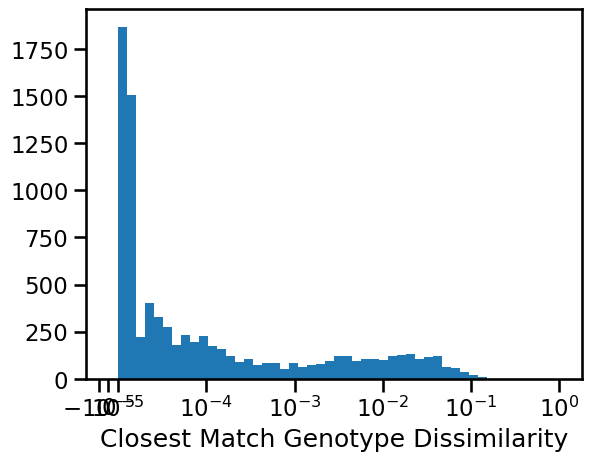

In [42]:
dmat = geno_pdmat.loc[spgc_meta.genome_type.isin(["Isolate", "MAG"]), spgc_meta.genome_type.isin(["Isolate", "MAG"])]
dmat.values[np.diag_indices_from(dmat)] = 1
d = dmat.min()


linthresh = 1e-5
bins = [0] + list(np.logspace(np.log10(linthresh), 0, num=50))
plt.hist(d, bins=bins)
plt.xscale('symlog', linthresh=linthresh, linscale=0.1)
plt.xlabel('Closest Match Genotype Dissimilarity')

In [43]:
(d > 0.030).mean(), (d > 0.077).mean()

(0.050156362761606926, 0.007818138080346404)

## Gene Content Comparison

### Gene Annotations

In [44]:
gene_content_uhgg = pd.read_table(
    "data/group/ucfmt/species/sp-102506/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.uhgg-strain_gene.tsv",
    index_col="gene_id",
).astype(bool)
gene_content_uhgg = gene_content_uhgg.drop(idxwhere(gene_content_uhgg.sum(1) == 0))

In [45]:
gene_content_uhgg[focal_strains][lambda x: x.sum(1) > 0].value_counts().sort_index()

6      9    
False  True     1355
True   False     959
       True     4256
Name: count, dtype: int64

In [46]:
gene_prevalence_ref_uhgg = pd.read_table(
    "data/species/sp-102506/midasdb.gene75_v20.uhgg-strain_gene.ref_prevalence.tsv",
    names=["gene_id", "prevalence"],
    index_col="gene_id",
).prevalence
gene_prevalence_hmp2_uhgg = pd.read_table(
    "data/group/hmp2/species/sp-102506/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.uhgg-strain_gene.prevalence.tsv",
    names=["gene_id", "prevalence"],
    index_col="gene_id",
).prevalence

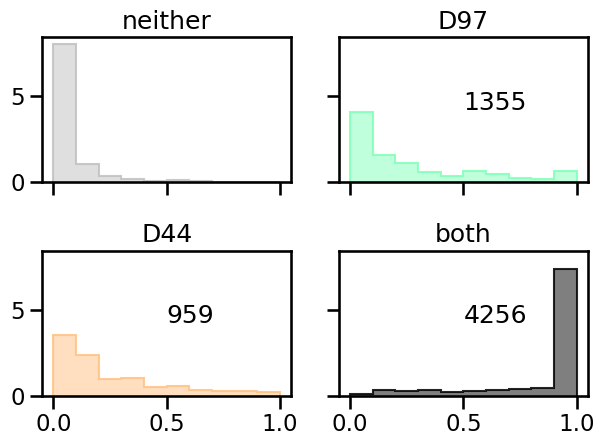

In [47]:
d0 = (
    gene_prevalence_hmp2_uhgg.to_frame()
    .join(gene_content_uhgg)
    .groupby(["6", "9"])
    .prevalence
)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
bins = np.linspace(0, 1, num=11)
for (focal_strain_gene_type, (k, c)), ax in zip(
    {
        "neither": ((False, False), "silver"),
        "D44": ((True, False), strain_palette["6"]),
        "D97": ((False, True), strain_palette["9"]),
        "both": ((True, True), "black"),
    }.items(),
    axs.T.flatten(),
):
    d1 = d0.get_group(k)
    ax.set_title(focal_strain_gene_type)
    ax.hist(
        d1,
        bins=bins,
        density=True,
        label=focal_strain_gene_type,
        color=c,
        alpha=0.5,
        histtype="stepfilled",
    )
    ax.hist(
        d1,
        bins=bins,
        density=True,
        label=focal_strain_gene_type,
        color=c,
        alpha=0.85,
        histtype="step",
    )
    if not focal_strain_gene_type == "neither":
        ax.annotate(len(d1), xy=(0.5, 0.5), xycoords="axes fraction")

fig.tight_layout()

In [48]:
gene_clust = pd.read_table(
    "data/group/hmp2/species/sp-102506/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.uhgg-strain_gene.gene_clust-t10.tsv",
    names=["gene_id", "clust"],
    index_col="gene_id",
).clust
gene_clust.value_counts()

clust
-4       60019
-3        4530
-1        2907
-2         231
 1359      149
         ...  
 1551        1
 1708        1
 2126        1
 2402        1
 1043        1
Name: count, Length: 2747, dtype: int64

In [49]:
gene_annotation = pd.read_table(
    "data/species/sp-102506/midasdb_v20.gene75_meta.tsv", index_col="centroid_75"
)

In [50]:
gene_x_cog = pd.read_table(
    "data/species/sp-102506/midasdb_v20.emapper.gene75_x_cog.tsv"
).drop_duplicates()
cog_x_cog_pathway = pd.read_table(
    "ref/cog-20.meta.tsv",
    encoding="latin1",
    names=[
        "cog",
        "cog_categories",
        "description",
        "preferred_name",
        "cog_pathway",
        "_5",
        "color_hex",
    ],
    index_col="cog",
).cog_pathway

In [51]:
hmp2_strain_meta = pd.read_table(
    "data/group/hmp2/species/sp-102506/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.strain_meta_spgc_and_ref.tsv",
    index_col="genome_id",
)
hmp2_strain_list = idxwhere(
    (hmp2_strain_meta.genome_type == "SPGC") & hmp2_strain_meta.passes_filter
)
hmp2_strain_rename_list = [f"hmp2_{s}" for s in hmp2_strain_list]
len(hmp2_strain_list)

28

In [52]:
hmp2_geno = (
    sf.Metagenotype.load(
        "data/group/hmp2/species/sp-102506/r.proc.gtpro.sfacts-fit.spgc_ss-all.mgtp.nc"
    )
    .rename_coords(sample=str)
    .sel(sample=hmp2_strain_list)
    .to_estimated_genotype()
    .discretized(max_ambiguity=0.1)
    .rename_coords(strain=lambda s: f"hmp2_{s}")
)
ucfmt_geno = (
    sf.Metagenotype.load(
        "data/group/ucfmt/species/sp-102506/r.proc.gtpro.sfacts-fit.spgc_ss-all.mgtp.nc"
    )
    .rename_coords(sample=str)
    .to_estimated_genotype()
    .discretized(max_ambiguity=0.1)
)

combined_geno = sf.Genotype.concat(
    dict(hmp2=hmp2_geno, ucfmt=ucfmt_geno.sel(strain=ucfmt_strains)),
    dim="strain",
    rename=False,
)

In [53]:
from scripts.calculate_pairwise_genotype_masked_hamming_distance import (
    native_masked_hamming_distance_pdist,
)

combined_mgtp_geno_pdist = pd.DataFrame(
    squareform(native_masked_hamming_distance_pdist(combined_geno.values, pseudo=1)),
    index=combined_geno.strain,
    columns=combined_geno.strain,
)
combined_mgtp_geno_linkage = sp.cluster.hierarchy.linkage(
    squareform(combined_mgtp_geno_pdist), method="average", optimal_ordering=True
)

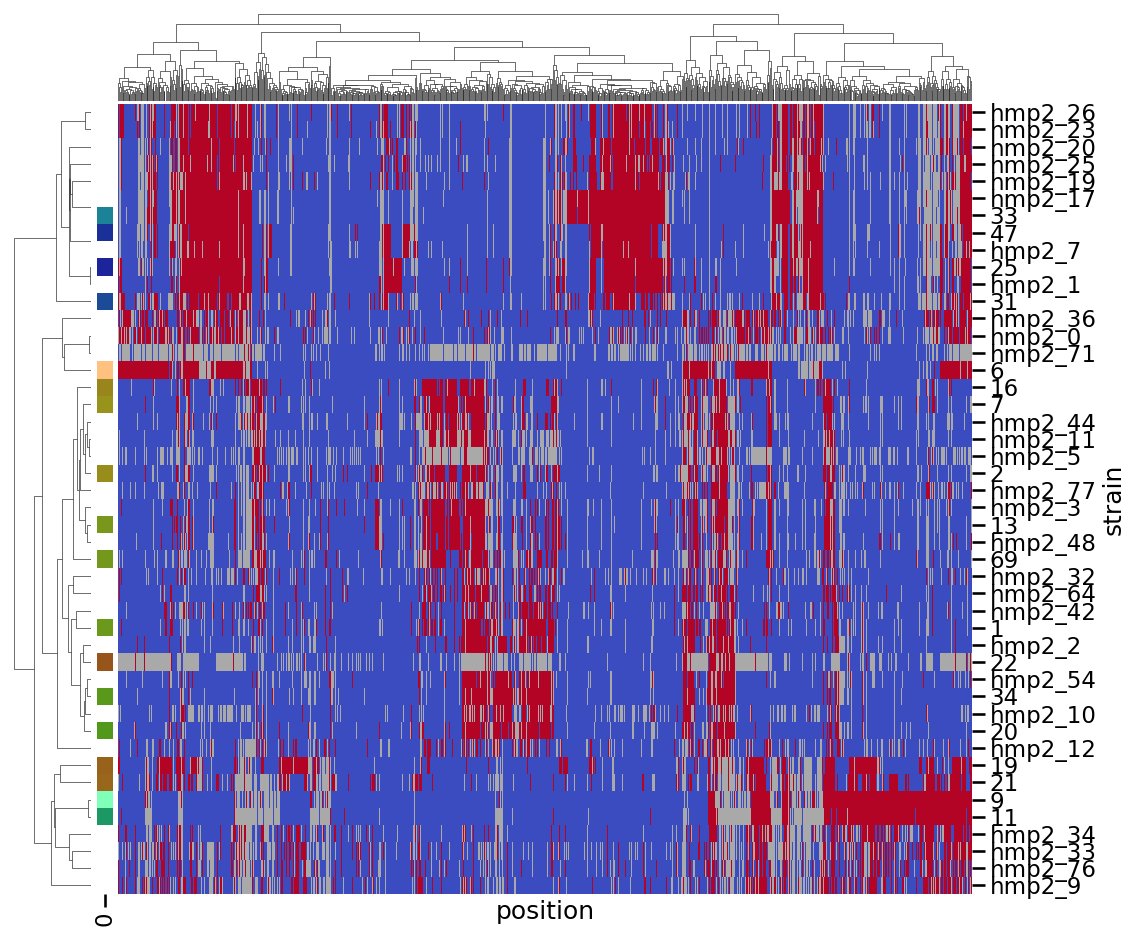

In [54]:
sf.plot.plot_genotype(
    combined_geno.sel(position=position_ss),
    row_linkage_func=lambda w: combined_mgtp_geno_linkage,
    col_linkage_func=lambda w: position_linkage,
    row_colors=strain_colors,
)

In [55]:
gene_content_hmp2_uhgg = (
    pd.read_table(
        "data/group/hmp2/species/sp-102506/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.uhgg-strain_gene.tsv",
        index_col="gene_id",
    )[hmp2_strain_list]
    .astype(bool)
    .rename(columns=lambda s: f"hmp2_{s}")
)
gene_content_ucfmt_uhgg = gene_content_uhgg[
    ucfmt_strains
]  # pd.read_table('data/group/ucfmt/species/sp-102506/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.uhgg-strain_gene.tsv', index_col='gene_id').astype(bool)
gene_content_combined = pd.concat(
    [gene_content_hmp2_uhgg, gene_content_ucfmt_uhgg], axis="columns"
).fillna(False)

#### Figure 5B

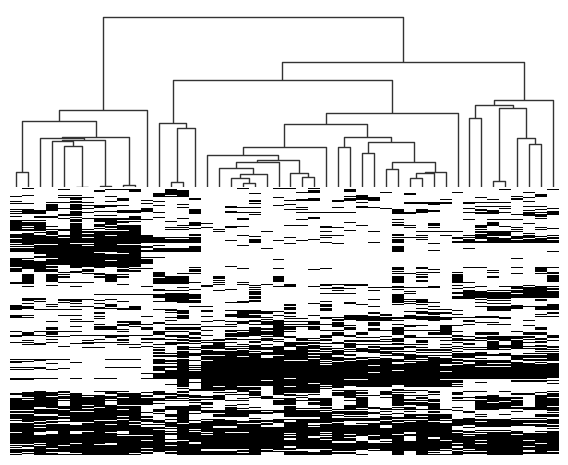

In [56]:
d = gene_content_combined[
    lambda x: (gene_prevalence_hmp2_uhgg > 0.15)
    & (gene_prevalence_hmp2_uhgg < 0.9)
    & (gene_content_combined.mean(1) > 0)
]

cg = sns.clustermap(
    d,
    col_linkage=combined_mgtp_geno_linkage,
    metric="cosine",
    cmap="Grays",
    xticklabels=False,
    yticklabels=False,
    figsize=(10, 5),
    tree_kws=dict(lw=1),
    dendrogram_ratio=0.4,
    rasterized=True,
)
cg.ax_heatmap.set_ylabel("")
cg.ax_row_dendrogram.set_visible(False)
cg.ax_cbar.set_visible(False)

d.shape

plt.savefig('fig/fig5b_heatmap.pdf', bbox_inches='tight')

In [57]:
gene_content_combined[
    lambda x: (gene_prevalence_hmp2_uhgg > 0.15)
    & (gene_prevalence_hmp2_uhgg < 0.9)
    & (gene_content_combined.mean(1) > 0)
].dropna(axis="columns").dropna(axis="rows").shape

(3134, 46)

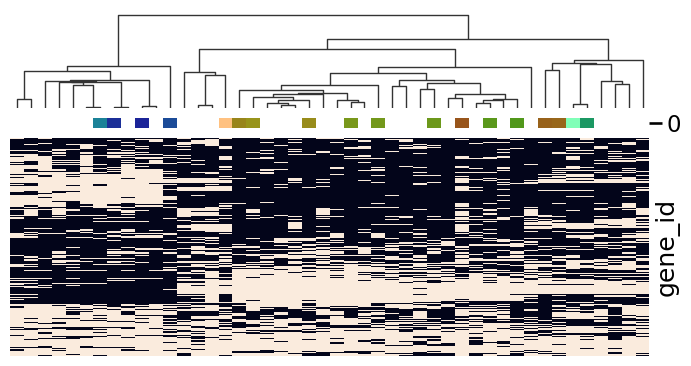

In [58]:
# Helper figure to place pointers.

d = gene_content_combined[
    lambda x: (gene_prevalence_hmp2_uhgg > 0.15)
    & (gene_prevalence_hmp2_uhgg < 0.9)
    & (gene_content_combined.mean(1) > 0)
]

cg = sns.clustermap(
    d,
    col_linkage=combined_mgtp_geno_linkage,
    col_colors=strain_colors,
    metric="cosine",
    xticklabels=False,
    yticklabels=False,
    figsize=(10, 4),
    tree_kws=dict(lw=1),
    dendrogram_ratio=0.3,
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_cbar.set_visible(False)

4.0    2070
0.0      46
Name: count, dtype: int64
PearsonRResult(statistic=0.8860489498776094, pvalue=0.0)


Text(0, 0.5, 'Shell Gene Content Dissimilarity')

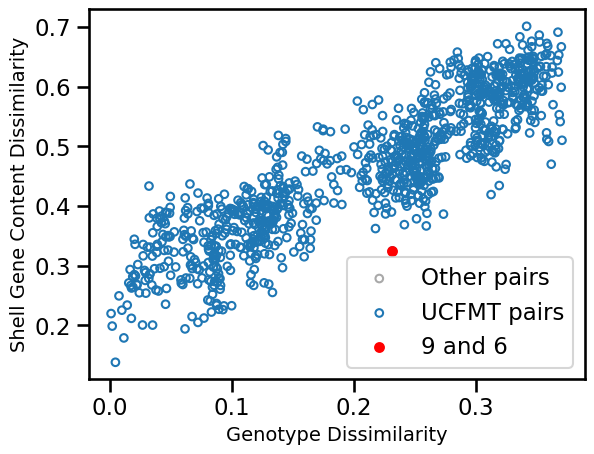

In [59]:
combined_gene_content_pdist = lib.dissimilarity.dmatrix(
    gene_content_combined[
        lambda x: (gene_prevalence_hmp2_uhgg > 0.15) & (gene_prevalence_hmp2_uhgg < 0.9)
    ].T,
    metric="cosine",
)

_strain_list = combined_gene_content_pdist.index

strain_pair_coded = lib.dissimilarity.dmatrix(
    _strain_list.to_frame().isin(_strain_list).replace({True: 2, False: 1}),
    metric=lambda x, y: x * y,
)
print(strain_pair_coded.stack().value_counts())

d = pd.DataFrame(
    dict(
        geno_diss=squareform(combined_mgtp_geno_pdist.loc[_strain_list, _strain_list]),
        gene_diss=squareform(
            combined_gene_content_pdist.loc[_strain_list, _strain_list]
        ),
        pair_type_coded=squareform(strain_pair_coded.loc[_strain_list, _strain_list]),
    )
).assign(
    pair_type=lambda x: x.pair_type_coded.map(
        {0.0: "self", 1.0: "hmp2", 2.0: "inter", 4.0: "ucfmt"}
    )
)
print(sp.stats.pearsonr(d["geno_diss"], d["gene_diss"]))

# Plot hmp2 and inter-set pairs
plt.scatter(
    "geno_diss",
    "gene_diss",
    data=d[lambda x: x.pair_type.isin(["hmp2", "inter"])],
    s=30,
    facecolor="none",
    edgecolor="darkgrey",
    label="Other pairs",
)

# Plot UCFMT pairs
plt.scatter(
    "geno_diss",
    "gene_diss",
    data=d[lambda x: x.pair_type.isin(["ucfmt"])],
    s=30,
    facecolor="none",
    edgecolor="tab:blue",
    label="UCFMT pairs",
)


# ucfmt-by-ucfmt pairs# Highlight
# _x = squareform(combined_mgtp_geno_pdist.loc[spgc_strain_list, spgc_strain_list])
# _y = squareform(combined_gene_content_pdist.loc[spgc_strain_list, spgc_strain_list])
# plt.scatter(_x, _y, s=5)

# Highlight focal strain comparison#
_x = squareform(combined_mgtp_geno_pdist.loc[focal_strains, focal_strains])
_y = squareform(combined_gene_content_pdist.loc[focal_strains, focal_strains])
plt.scatter(_x, _y, s=40, c="red", label="9 and 6")

plt.legend()
plt.xlabel("Genotype Dissimilarity", fontsize=14)
plt.ylabel("Shell Gene Content Dissimilarity", fontsize=14)

[0.23171697]
0.40522875816993464


array([0.12999021, 0.25338239, 0.30565206])

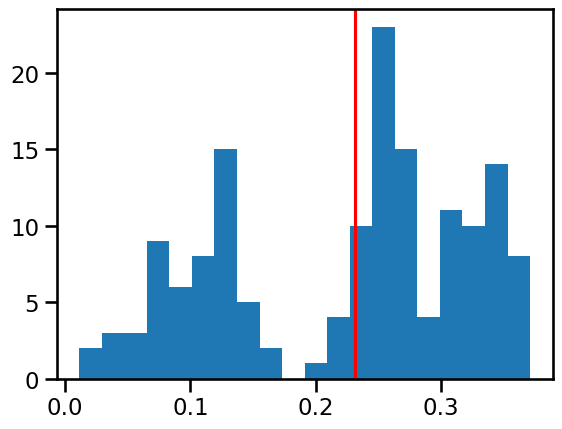

In [60]:
plt.hist(
    squareform(combined_mgtp_geno_pdist.loc[spgc_strain_list, spgc_strain_list]),
    bins=20,
)
plt.axvline(
    squareform(combined_mgtp_geno_pdist.loc[focal_strains, focal_strains]), color="r"
)
print(squareform(combined_mgtp_geno_pdist.loc[focal_strains, focal_strains]))
print(
    (
        squareform(combined_mgtp_geno_pdist.loc[spgc_strain_list, spgc_strain_list])
        < squareform(combined_mgtp_geno_pdist.loc[focal_strains, focal_strains])
    ).mean()
)
np.quantile(
    squareform(combined_mgtp_geno_pdist.loc[spgc_strain_list, spgc_strain_list]),
    [0.25, 0.5, 0.75],
)

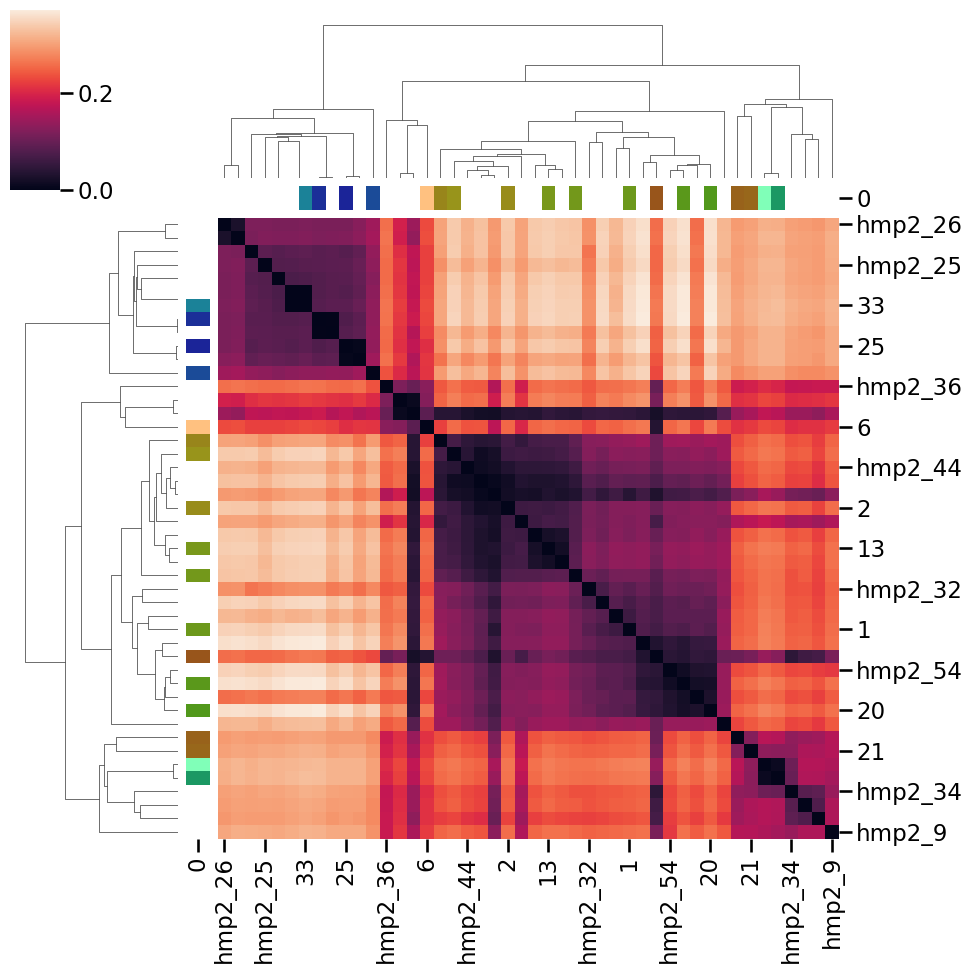

In [61]:
sns.clustermap(
    combined_mgtp_geno_pdist,
    row_linkage=combined_mgtp_geno_linkage,
    col_linkage=combined_mgtp_geno_linkage,
    col_colors=strain_colors,
    row_colors=strain_colors,
)

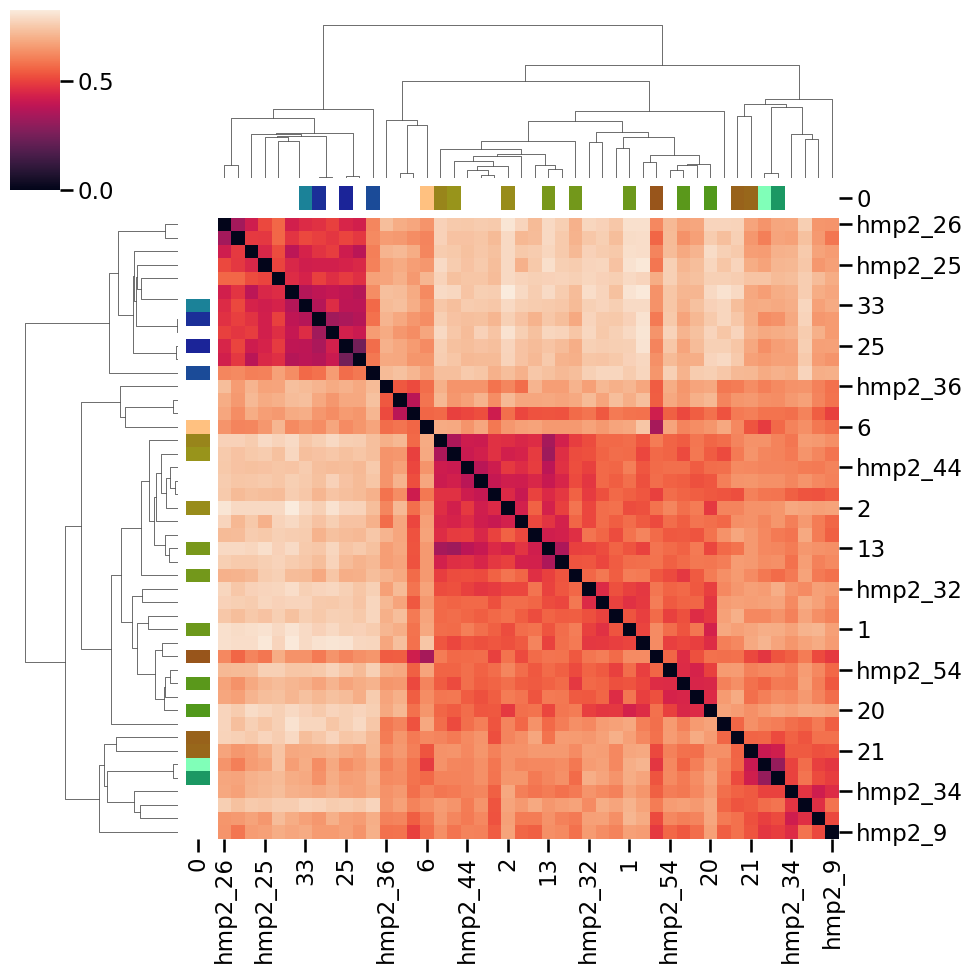

In [62]:
d0 = gene_content_combined[
    lambda x: (gene_prevalence_hmp2_uhgg > 0.15) & (gene_prevalence_hmp2_uhgg < 0.9)
]

pdist = lib.dissimilarity.dmatrix(d0.T, metric="jaccard")

sns.clustermap(
    pdist,
    row_linkage=combined_mgtp_geno_linkage,
    col_linkage=combined_mgtp_geno_linkage,
    col_colors=strain_colors,
    row_colors=strain_colors,
)

In [63]:
gene_x_cog_category_matrix = (
    pd.read_table(
        "data/species/sp-102506/midasdb_v20.emapper.gene75_x_cog_category.tsv"
    )
    .assign(flag=True)
    .set_index(["centroid_75", "cog_category"])
    .flag.unstack("cog_category", fill_value=False)
)

#### Figure 5C

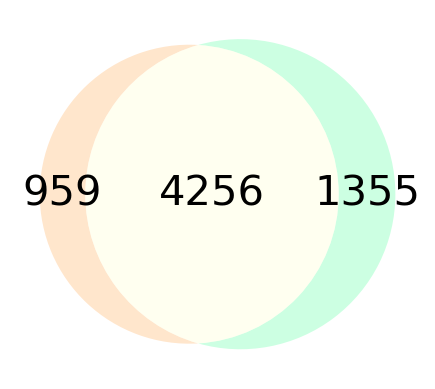

In [64]:
d = gene_content_ucfmt_uhgg

v = venn2(
    [set(idxwhere(d["6"])), set(idxwhere(d["9"]))],
    set_labels=["", ""],
    set_colors=[strain_palette["6"], strain_palette["9"]],
)

for text in v.subset_labels:
    text.set_fontsize(30)

plt.savefig('fig/fig5c_venn.pdf', bbox_inches='tight')

#### Figure 5D

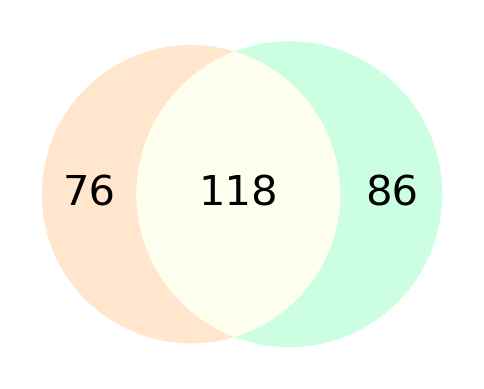

In [65]:
# Figure 5D

drop_clusters = set(idxwhere(gene_clust.value_counts() < 2) + [-4, -3, -2, -1])
d = (gene_content_ucfmt_uhgg.groupby(gene_clust).mean() >= 0.75).drop(
    drop_clusters, errors="ignore"
)

v = venn2(
    [set(idxwhere(d["6"])), set(idxwhere(d["9"]))],
    set_labels=["", ""],
    set_colors=[strain_palette["6"], strain_palette["9"]],
)

for text in v.subset_labels:
    text.set_fontsize(30)

plt.savefig('fig/fig5d_venn.pdf', bbox_inches='tight')

### Focal Strain Shared Gene Content

In [66]:
_strain_status = pd.DataFrame(
    dict(
        shared=gene_content_combined[focal_strains].all(1),
        ucfmt_prevalence=gene_content_combined[ucfmt_strains].mean(1),
        hmp2_prevalence=gene_content_combined[hmp2_strain_rename_list].mean(1),
    )
)[lambda x: x.ucfmt_prevalence > 0]

_strain_status

shared  ucfmt_prevalence  hmp2_prevalence
gene_id                                                          
GUT_GENOME000026_00048   False          0.055556         0.071429
GUT_GENOME000026_00054   False          0.166667         0.107143
GUT_GENOME000026_00055   False          0.166667         0.142857
GUT_GENOME000026_00058   False          0.166667         0.142857
GUT_GENOME000026_00059   False          0.111111         0.142857
...                        ...               ...              ...
GUT_GENOME289037_03656    True          1.000000         1.000000
GUT_GENOME289037_04151   False          0.055556         0.000000
GUT_GENOME289037_04726    True          1.000000         1.000000
GUT_GENOME289037_05036   False          0.055556         0.000000
GUT_GENOME289037_05197    True          1.000000         1.000000

[12124 rows x 3 columns]

In [67]:
cluster_content = (gene_content_combined.groupby(gene_clust).mean() >= 0.75).drop(
    drop_clusters, errors="ignore"
)

_strain_status = pd.DataFrame(
    dict(
        shared=cluster_content[focal_strains].all(1),
        ucfmt_prevalence=cluster_content[ucfmt_strains].mean(1),
        hmp2_prevalence=cluster_content[hmp2_strain_rename_list].mean(1),
        cluster_size=gene_clust.value_counts(),
    )
)[lambda x: x.ucfmt_prevalence > 0]

shared_low_prevalence_clusters = idxwhere(
    (_strain_status.ucfmt_prevalence < 5 / 18) & (_strain_status.shared)
)

_strain_status.loc[shared_low_prevalence_clusters].sort_values(
    ["cluster_size", "ucfmt_prevalence"], ascending=False
)

shared  ucfmt_prevalence  hmp2_prevalence  cluster_size
clust                                                        
489     True          0.166667         0.142857            28
624     True          0.222222         0.214286            13
493     True          0.166667         0.107143            12
490     True          0.166667         0.178571             6
486     True          0.111111         0.178571             6
915     True          0.166667         0.214286             5
473     True          0.166667         0.107143             3
478     True          0.166667         0.214286             3
685     True          0.111111         0.142857             3
1326    True          0.222222         0.142857             2
680     True          0.166667         0.214286             2
1565    True          0.166667         0.214286             2

In [68]:
clust = shared_low_prevalence_clusters
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .assign(ucfmt_prevalence=gene_content_combined[ucfmt_strains].mean(1))
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])
    .sort_values(["clust", "Preferred_name"])
)

# _clust_annotations[['eggNOG_OGs', 'COG_category', 'Description', 'Preferred_name', 'PFAMs', 'ucfmt_prevalence', 'clust', '6', '9']]

gene_x_cog_category_matrix.reindex(_clust_annotations.index).fillna(False).assign(
    no_category=lambda d: (d.drop(columns=["no_category"]).sum(1) == 0)
).sum()[lambda x: x > 0]

cog_category
C               2
D               1
F               1
G               2
I               1
J               1
K               2
L               2
M               4
O               1
P               5
Q               1
R               1
U               1
V               5
W               1
X              25
no_category    39
dtype: int64

In [69]:
gene_x_cog_category_matrix.reindex(_clust_annotations.index).fillna(False).assign(
    no_category=lambda d: (d.drop(columns=["no_category"]).sum(1) == 0)
).groupby(gene_clust).sum().loc[:, lambda x: x.sum() > 0]

cog_category  C  D  F  G  I  J  K  L  M  O  P  Q  R  U  V  W   X  no_category
clust                                                                        
473           0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0            3
478           0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0   0            2
486           0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0   2            4
489           0  1  0  0  0  1  1  1  0  0  0  0  0  1  0  1  13           12
490           0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0   2            3
493           0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   7            5
624           2  0  0  0  1  0  0  0  3  1  4  0  1  0  3  0   0            2
680           0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0   0            0
685           0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0            3
915           0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0            5
1326          0  0  0  2  0  0  0  0  0  0  1  0  0  0  0  0   0            0
1565          0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0   1            0

In [70]:
clust = [624]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .assign(ucfmt_prevalence=gene_content_combined[ucfmt_strains].mean(1))
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])
    .sort_values("Preferred_name")
)

_clust_annotations[
    [
        "eggNOG_OGs",
        "COG_category",
        "Description",
        "Preferred_name",
        "PFAMs",
        "ucfmt_prevalence",
        "clust",
        "6",
        "9",
    ]
]

eggNOG_OGs  \
centroid_75                                                                 
GUT_GENOME157025_03210  2DB79@1|root,2Z7K9@2|Bacteria,1NR0Z@1224|Prote...   
GUT_GENOME140980_00110  COG0810@1|root,COG0810@2|Bacteria,1MZXC@1224|P...   
GUT_GENOME000489_04542  COG0672@1|root,COG0672@2|Bacteria,1MXHM@1224|P...   
GUT_GENOME078929_01460  COG0577@1|root,COG0577@2|Bacteria,1R75G@1224|P...   
GUT_GENOME000489_04547  COG1136@1|root,COG1136@2|Bacteria,1Q3QX@1224|P...   
GUT_GENOME000489_04545  COG0577@1|root,COG0577@2|Bacteria,1PU2M@1224|P...   
GUT_GENOME000489_04541  COG2869@1|root,COG2869@2|Bacteria,1MVDI@1224|P...   
GUT_GENOME000489_04548  COG0526@1|root,COG0526@2|Bacteria,1RCTX@1224|P...   
GUT_GENOME000489_04543  COG3470@1|root,COG3470@2|Bacteria,1RA2Z@1224|P...   
GUT_GENOME000489_04544  COG3350@1|root,COG4393@1|root,COG3350@2|Bacter...   
GUT_GENOME000489_04549  2BT38@1|root,32N7S@2|Bacteria,1QN6W@1224|Prote...   
GUT_GENOME000489_05151  COG4774@1|root,COG4774@2|Bacteria,1QUJE@1224|P...   
GUT_GENOME140867_04868  COG3391@1|root,COG3391@2|Bacteria,1PDS2@1224|P...   

                       COG_category  \
centroid_75                           
GUT_GENOME157025_03210  no_category   
GUT_GENOME140980_00110            M   
GUT_GENOME000489_04542            P   
GUT_GENOME078929_01460            V   
GUT_GENOME000489_04547           VM   
GUT_GENOME000489_04545            V   
GUT_GENOME000489_04541            C   
GUT_GENOME000489_04548           CO   
GUT_GENOME000489_04543          PMI   
GUT_GENOME000489_04544            P   
GUT_GENOME000489_04549  no_category   
GUT_GENOME000489_05151            P   
GUT_GENOME140867_04868            R   

                                                              Description  \
centroid_75                                                                 
GUT_GENOME157025_03210       Histidine phosphatase superfamily (branch 2)   
GUT_GENOME140980_00110  COG0810 Periplasmic protein TonB, links inner ...   
GUT_GENOME000489_04542                          Iron permease FTR1 family   
GUT_GENOME078929_01460                  MacB-like periplasmic core domain   
GUT_GENOME000489_04547  ATPases associated with a variety of cellular ...   
GUT_GENOME000489_04545                  MacB-like periplasmic core domain   
GUT_GENOME000489_04541  NQR complex catalyzes the reduction of ubiquin...   
GUT_GENOME000489_04548                                   Thioredoxin-like   
GUT_GENOME000489_04543                             Fe2+ transport protein   
GUT_GENOME000489_04544               Predicted membrane protein (DUF2318)   
GUT_GENOME000489_04549                                                NaN   
GUT_GENOME000489_05151                            TonB dependent receptor   
GUT_GENOME140867_04868                                        DNA binding   

                       Preferred_name              PFAMs  ucfmt_prevalence  \
centroid_75                                                                  
GUT_GENOME157025_03210            agp         His_Phos_2          0.333333   
GUT_GENOME140980_00110           cjrB             TonB_C          0.222222   
GUT_GENOME000489_04542         efeU_1               FTR1          0.222222   
GUT_GENOME078929_01460         lolE_1      FtsX,MacB_PCD          0.388889   
GUT_GENOME000489_04547         macB_2           ABC_tran          0.388889   
GUT_GENOME000489_04545         macB_3      FtsX,MacB_PCD          0.333333   
GUT_GENOME000489_04541           nqrC           FMN_bind          0.388889   
GUT_GENOME000489_04548           resA            Redoxin          0.222222   
GUT_GENOME000489_04543            tpd     Iron_transport          0.222222   
GUT_GENOME000489_04544            NaN        DUF2318,YHS          0.333333   
GUT_GENOME000489_04549            NaN                NaN          0.222222   
GUT_GENOME000489_05151            NaN  Plug,TonB_dep_Rec          0.277778   
GUT_GENOME140867_04868            NaN                NaN          0.27777

### Focal Strain Differences

In [71]:
gene_x_amr = pd.read_table("data/species/sp-102506/midasdb_v20.gene75_x_amr.tsv")
amr_gene_list = gene_x_amr.centroid_75.unique()
len(amr_gene_list)

111

In [72]:
gene_content_ucfmt_uhgg.reindex(
    index=amr_gene_list, columns=focal_strains, fill_value=False
).sum()

6     0
9    12
dtype: int64

In [73]:
gene_content_ucfmt_uhgg.reindex(
    index=amr_gene_list, columns=focal_strains, fill_value=False
)[lambda x: x.sum(1) > 0]

6     9
gene_id                            
GUT_GENOME144248_04389  False  True
GUT_GENOME143778_01801  False  True
GUT_GENOME141022_04948  False  True
GUT_GENOME146631_03564  False  True
GUT_GENOME144883_00428  False  True
GUT_GENOME143768_05231  False  True
GUT_GENOME145475_01188  False  True
GUT_GENOME096065_04373  False  True
GUT_GENOME082596_00191  False  True
GUT_GENOME143871_04656  False  True
GUT_GENOME144128_04299  False  True
GUT_GENOME096119_00075  False  True

In [74]:
focal_strain_amr_hits = gene_x_amr[
    lambda x: x.centroid_75.isin(
        idxwhere(gene_content_ucfmt_uhgg[focal_strains].any(axis=1))
    )
]
focal_strain_amr_list = focal_strain_amr_hits.accession_no.values
focal_strain_amr_hits.sort_values("centroid_75")

centroid_75 accession_no
29  GUT_GENOME082596_00191       M64556
21  GUT_GENOME096065_04373     FJ460238
68  GUT_GENOME096119_00075       D16251
3   GUT_GENOME141022_04948       M28829
11  GUT_GENOME143768_05231       D16251
1   GUT_GENOME143778_01801     AY458016
49  GUT_GENOME143871_04656       X04555
63  GUT_GENOME144128_04299     EU432277
0   GUT_GENOME144248_04389     AF321551
7   GUT_GENOME144883_00428     JQ480156
13  GUT_GENOME145475_01188       D16251
4   GUT_GENOME146631_03564       U12338

In [75]:
resfinder = pd.read_table(
    "ref/midasdb_uhgg_v20/pangenomes/102506/annotation/resfinder.tsv"
)[["resistance_gene", "phenotype", "accession_no"]].drop_duplicates()
resfinder

resistance_gene                                          phenotype  \
0              tet(B)             Doxycycline, Tetracycline, Minocycline   
2               aadA1                        Spectinomycin, Streptomycin   
3               aadA1                        Spectinomycin, Streptomycin   
4            blaOXA-1  Amoxicillin, Amoxicillin+Clavulanic acid, Ampi...   
5               catA1                                    Chloramphenicol   
...               ...                                                ...   
21430         tet(31)                          Doxycycline, Tetracycline   
21612      aph(3')-Ia  Kanamycin, Neomycin, Kanamycin, Lividomycin, P...   
21825      aac(6')-Ib  Amikacin, Tobramycin, Amikacin, Tobramycin, Ka...   
22035       blaTEM-26  Amoxicillin, Ampicillin, Aztreonam, Cefepime, ...   
22036      blaTEM-189                                Unknown Beta-lactam   

       accession_no  
0          AF326777  
2          JX185132  
3          JQ414041  
4          HQ170510  
5            V00622  
...             ...  
21430      GQ283908  
21612      EF015636  
21825        M21682  
22035  LDCJ01000052  
22036      JN254627  

[375 rows x 3 columns]

In [76]:
resfinder[lambda x: x.accession_no.isin(focal_strain_amr_list)].sort_values(
    "accession_no"
)

resistance_gene                                          phenotype  \
12       aph(3'')-Ib                                       Streptomycin   
22         blaTEM-1B  Amoxicillin, Ampicillin, Cephalothin, Piperaci...   
24            mph(A)  Erythromycin, Azithromycin, Spiramycin, Telith...   
128           qnrB19                                      Ciprofloxacin   
29            dfrA17                                       Trimethoprim   
58             aadA1                        Spectinomycin, Streptomycin   
10         aph(6)-Id                                       Streptomycin   
1627     aph(3'')-Ib                                       Streptomycin   
69             cmlA1                                    Chloramphenicol   
26              sul1                                   Sulfamethoxazole   
2499     ant(2'')-Ia                             Gentamicin, Tobramycin   

     accession_no  
12       AF321551  
22       AY458016  
24         D16251  
128      EU432277  
29       FJ460238  
58       JQ480156  
10         M28829  
1627       M28829  
69         M64556  
26         U12338  
2499       X04555

In [77]:
resfinder[lambda x: x.accession_no.isin(focal_strain_amr_list)].sort_values(
    "accession_no"
).phenotype.str.split(", ").explode().value_counts()

phenotype
Streptomycin        4
Telithromycin       1
Gentamicin          1
Sulfamethoxazole    1
Chloramphenicol     1
Spectinomycin       1
Trimethoprim        1
Ciprofloxacin       1
Spiramycin          1
Amoxicillin         1
Azithromycin        1
Erythromycin        1
Ticarcillin         1
Piperacillin        1
Cephalothin         1
Ampicillin          1
Tobramycin          1
Name: count, dtype: int64

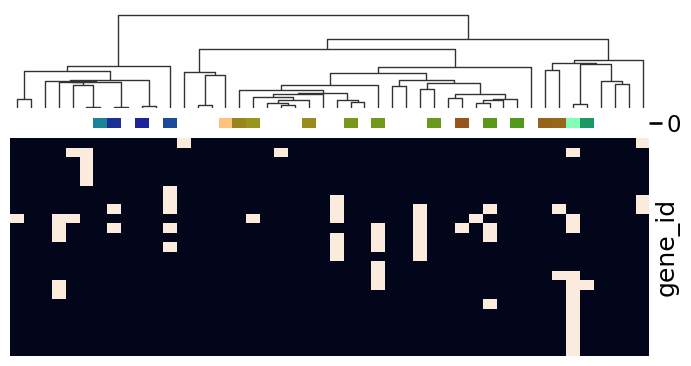

In [78]:
d = gene_content_combined.loc[amr_gene_list][lambda x: x.sum(1) > 0]

cg = sns.clustermap(
    d,
    col_linkage=combined_mgtp_geno_linkage,
    col_colors=strain_colors,
    metric="cosine",
    xticklabels=False,
    yticklabels=False,
    figsize=(10, 4),
    tree_kws=dict(lw=1),
    dendrogram_ratio=0.3,
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_cbar.set_visible(False)

In [79]:
gene_content_combined

hmp2_0  hmp2_1  hmp2_10  hmp2_11  hmp2_12  hmp2_17  \
gene_id                                                                      
GUT_GENOME000026_00048   False   False    False    False    False    False   
GUT_GENOME000026_00054   False   False    False    False    False     True   
GUT_GENOME000026_00055   False   False    False    False    False     True   
GUT_GENOME000026_00058   False   False    False    False    False     True   
GUT_GENOME000026_00059   False   False    False    False    False     True   
...                        ...     ...      ...      ...      ...      ...   
GUT_GENOME289063_02641   False   False    False    False    False    False   
GUT_GENOME289063_02642   False   False    False    False    False    False   
GUT_GENOME289063_03202   False   False    False    False    False    False   
GUT_GENOME289063_03473   False   False    False    False    False    False   
GUT_GENOME289063_03475   False   False    False    False    False    False   

                        hmp2_19  hmp2_2  hmp2_20  hmp2_23  ...     22     25  \
gene_id                                                    ...                 
GUT_GENOME000026_00048    False   False    False    False  ...  False  False   
GUT_GENOME000026_00054    False   False    False    False  ...  False  False   
GUT_GENOME000026_00055    False   False    False    False  ...  False  False   
GUT_GENOME000026_00058    False   False    False    False  ...  False  False   
GUT_GENOME000026_00059    False   False    False    False  ...  False  False   
...                         ...     ...      ...      ...  ...    ...    ...   
GUT_GENOME289063_02641    False   False    False    False  ...  False  False   
GUT_GENOME289063_02642    False   False    False    False  ...  False  False   
GUT_GENOME289063_03202    False   False    False    False  ...  False  False   
GUT_GENOME289063_03473    False   False    False    False  ...  False  False   
GUT_GENOME289063_03475    False   False    False    False  ...  False  False   

                           31     33     34     47      6     69      7      9  
gene_id                                                                         
GUT_GENOME000026_00048  False  False  False   True  False  False  False  False  
GUT_GENOME000026_00054  False   True   True   True  False  False  False  False  
GUT_GENOME000026_00055  False   True   True   True  False  False  False  False  
GUT_GENOME000026_00058  False   True   True   True  False  False  False  False  
GUT_GENOME000026_00059  False   True  False   True  False  False  False  False  
...                       ...    ...    ...    ...    ...    ...    ...    ...  
GUT_GENOME289063_02641  False  False  False  False  False  False  False  False  
GUT_GENOME289063_02642  False  False  False  False  False  False  False  False  
GUT_GENOME289063_03202  False  False  False  False  False  False  False  False  
GUT_GENOME289063_03473  False  False  False  False  False  False  False  False  
GUT_GENOME289063_03475  False  False  False  False  False  False  False  False  

[73927 rows x 46 columns]

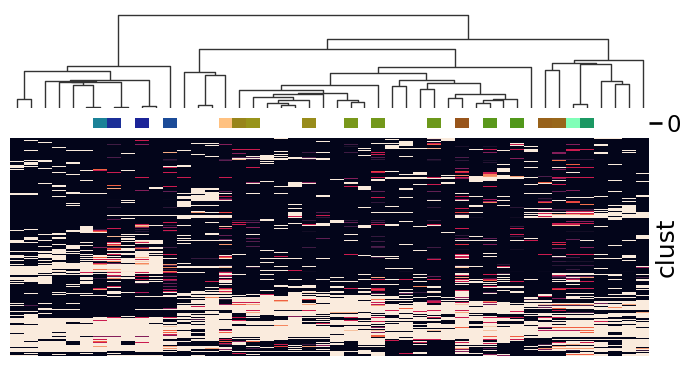

In [80]:
drop_clusters = set(idxwhere(gene_clust.value_counts() < 2) + [-4, -3, -2, -1])
clust_content_combined = (
    gene_content_combined.reindex(gene_clust.index, fill_value=False)
    .groupby(gene_clust)
    .mean()
    # >= 0.75
).drop(drop_clusters, errors="ignore")
d = clust_content_combined

cg = sns.clustermap(
    d,
    col_linkage=combined_mgtp_geno_linkage,
    col_colors=strain_colors,
    metric="cosine",
    xticklabels=False,
    yticklabels=False,
    figsize=(10, 4),
    tree_kws=dict(lw=1),
    dendrogram_ratio=0.3,
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_cbar.set_visible(False)

## Comprehensive Results Table (Supplementary Table 2)

In [81]:
d = (
    gene_annotation[["nlength", "Description", "Preferred_name"]]
    .reindex(idxwhere(gene_content_uhgg[focal_strains].any(axis=1)))
    .join(
        gene_content_combined[focal_strains].rename(
            columns=lambda s: f"{s}_gene_present"
        )
    )
    .assign(
        eggnog_og=gene_x_eggnog.groupby("centroid_75").eggnog.apply(
            lambda x: ",".join(x)
        ),
        gene_clust=gene_clust.replace({-4: np.nan, -3: np.nan, -2: np.nan, -1: np.nan}),
        amr_hit=gene_x_amr.groupby("centroid_75").accession_no.apply(
            lambda s: ",".join(s)
        ),
        cog_category=gene_x_cog_category_matrix.stack()
        .rename("is_category")
        .reset_index()[lambda x: x.is_category & (x.cog_category != "no_category")]
        .groupby("centroid_75")
        .cog_category.apply(lambda s: ",".join(s)),
    )
    .join(
        gene_content_combined[focal_strains]
        .reindex(gene_clust.index, fill_value=False)
        .groupby(gene_clust)
        .mean()
        .rename(columns=lambda s: f"{s}_clust_frac")
        .drop([-4, -3, -2, -1]),
        on="gene_clust",
    )
)
d.to_csv("fig/ucfmt_focal_strain_genes_supplementary_table3.tsv", sep='\t')
d

nlength  \
centroid_75                           
GUT_GENOME000026_00162   236.970528   
GUT_GENOME000026_00183  1232.185559   
GUT_GENOME000026_00233  2162.900341   
GUT_GENOME000026_00238  1833.256740   
GUT_GENOME000026_00246   664.294952   
...                             ...   
GUT_GENOME289037_02172   827.133798   
GUT_GENOME289037_03336   455.921018   
GUT_GENOME289037_03656   544.490949   
GUT_GENOME289037_04726   269.949599   
GUT_GENOME289037_05197   478.744540   

                                                              Description  \
centroid_75                                                                 
GUT_GENOME000026_00162              Protein of unknown function (DUF1656)   
GUT_GENOME000026_00183           cellular response to DNA damage stimulus   
GUT_GENOME000026_00233                 phenylalanine-tRNA ligase activity   
GUT_GENOME000026_00238  Catalyzes the attachment of threonine to tRNA(...   
GUT_GENOME000026_00246  this is a biologically important activity in v...   
...                                                                   ...   
GUT_GENOME289037_02172  Catalyzes the reductive methylation of 2'-deox...   
GUT_GENOME289037_03336  Protease involved in the C-terminal processing...   
GUT_GENOME289037_03656  Participates in transcription elongation, term...   
GUT_GENOME289037_04726                                  BolA-like protein   
GUT_GENOME289037_05197  Heme chaperone required for the biogenesis of ...   

                       Preferred_name  6_gene_present  9_gene_present  \
centroid_75                                                             
GUT_GENOME000026_00162           ydhI            True            True   
GUT_GENOME000026_00183           ydhQ            True            True   
GUT_GENOME000026_00233           pheT            True            True   
GUT_GENOME000026_00238           thrS            True            True   
GUT_GENOME000026_00246           yniC            True            True   
...                               ...             ...             ...   
GUT_GENOME289037_02172           thyA            True            True   
GUT_GENOME289037_03336           hyaD            True            True   
GUT_GENOME289037_03656           nusG            True            True   
GUT_GENOME289037_04726           yrbA            True            True   
GUT_GENOME289037_05197           ccmE            True            True   

                                                                eggnog_og  \
centroid_75                                                                 
GUT_GENOME000026_00162  3XQ01@561|Escherichia,1NCAP@1224|Proteobacteri...   
GUT_GENOME000026_00183  COG3468@1|root,COG3468@2|Bacteria,3XNU0@561|Es...   
GUT_GENOME000026_00233  COG0072@1|root,COG0073@2|Bacteria,COG0073@1|ro...   
GUT_GENOME000026_00238  COG0441@1|root,1MUP2@1224|Proteobacteria,COG04...   
GUT_GENOME000026_00246  COG0637@2|Bacteria,1RNP8@1236|Gammaproteobacte...   
...                                                                   ...   
GUT_GENOME289037_02172  1RMVK@1236|Gammaproteobacteria,1MVE3@1224|Prot...   
GUT_GENOME289037_03336  1S7Q1@1236|Gammaproteobacteria,1RKWY@1224|Prot...   
GUT_GENOME289037_03656  COG0250@2|Bacteria,COG0250@1|root,1RMW0@1236|G...   
GUT_GENOME289037_04726  COG5007@2|Bacteria,1SCAR@1236|Gammaproteobacte...   
GUT_GENOME289037_05197  COG2332@1|root,COG2332@2|Bacteria,3XPHZ@561|Es...   

                        gene_clust amr_hit cog_category  6_clust_frac  \
centroid_75                                                             
GUT_GENOME000026_00162         NaN     NaN          NaN           NaN   
GUT_GENOME000026_00183         NaN     NaN          M,U           NaN   
GUT_GENOME000026_00233         NaN     NaN            J           NaN   
GUT_GENOME000026_00238      1995.0     NaN            J           1.0   
GUT_GENOME000026_00246         NaN     NaN            G           NaN   
...                            ...     ...          ...

In [82]:
d = gene_annotation.join(gene_clust).join(gene_content_uhgg[focal_strains])

d

nlength                 seed_ortholog  \
centroid_75                                                         
GUT_GENOME000026_00048   723.378378  754331.AEME01000001_gene1296   
GUT_GENOME000026_00054   249.000000           667121.ET1_06_00770   
GUT_GENOME000026_00055  1207.884615                214092.YPO2280   
GUT_GENOME000026_00058  1671.848101                214092.YPO2277   
GUT_GENOME000026_00059   233.884120               214092.YPO2276a   
...                             ...                           ...   
GUT_GENOME289063_02641   840.000000                           NaN   
GUT_GENOME289063_02642  1398.000000            65393.PCC7424_1859   
GUT_GENOME289063_03202  1416.000000              568703.LGG_02750   
GUT_GENOME289063_03473   240.000000              568703.LGG_00140   
GUT_GENOME289063_03475   540.000000              568703.LGG_00142   

                               evalue   score  \
centroid_75                                     
GUT_GENOME000026_00048  4.910000e-164   461.0   
GUT_GENOME000026_00054   3.470000e-05    45.8   
GUT_GENOME000026_00055  5.760000e-285   780.0   
GUT_GENOME000026_00058   0.000000e+00  1072.0   
GUT_GENOME000026_00059   1.630000e-39   132.0   
...                               ...     ...   
GUT_GENOME289063_02641            NaN     NaN   
GUT_GENOME289063_02642   6.370000e-65   223.0   
GUT_GENOME289063_03202   0.000000e+00   913.0   
GUT_GENOME289063_03473   1.760000e-35   121.0   
GUT_GENOME289063_03475   1.350000e-48   166.0   

                                                               eggNOG_OGs  \
centroid_75                                                                 
GUT_GENOME000026_00048  COG0599@1|root,COG0599@2|Bacteria,1QTZH@1224|P...   
GUT_GENOME000026_00054  298I9@1|root,2ZVP8@2|Bacteria,1P7ZC@1224|Prote...   
GUT_GENOME000026_00055  COG1450@1|root,COG1450@2|Bacteria,1MV6A@1224|P...   
GUT_GENOME000026_00058  2E5KC@1|root,330BJ@2|Bacteria,1N2EG@1224|Prote...   
GUT_GENOME000026_00059  2B2P9@1|root,31V8Y@2|Bacteria,1QT5A@1224|Prote...   
...                                                                   ...   
GUT_GENOME289063_02641                                                NaN   
GUT_GENOME289063_02642                  COG3950@1|root,COG3950@2|Bacteria   
GUT_GENOME289063_03202  COG3039@1|root,COG3039@2|Bacteria,1TRUS@1239|F...   
GUT_GENOME289063_03473  28RTF@1|root,2ZE5S@2|Bacteria,1W5SB@1239|Firmi...   
GUT_GENOME289063_03475  COG1476@1|root,COG1476@2|Bacteria,1V6QF@1239|F...   

                                   max_annot_lvl COG_category  \
centroid_75                                                     
GUT_GENOME000026_00048  1236|Gammaproteobacteria            R   
GUT_GENOME000026_00054  1236|Gammaproteobacteria  no_category   
GUT_GENOME000026_00055  1236|Gammaproteobacteria           NU   
GUT_GENOME000026_00058  1236|Gammaproteobacteria  no_category   
GUT_GENOME000026_00059  1236|Gammaproteobacteria  no_category   
...                                          ...          ...   
GUT_GENOME289063_02641                       NaN  no_category   
GUT_GENOME289063_02642                2|Bacteria            R   
GUT_GENOME289063_03202             91061|Bacilli           LX   
GUT_GENOME289063_03473             91061|Bacilli  no_category   
GUT_GENOME289063_03475             91061|Bacilli            K   

                                                              Description  \
centroid_75                                                                 
GUT_GENOME000026_00048          Carboxymuconolactone decarboxylase family   
GUT_GENOME000026_00054                                                NaN   
GUT_GENOME000026_00055                        Belongs to the GSP D family   
GUT_GENOME000026_00058                                                NaN   
GUT_GENOME000026_00059                                                NaN   
...                                                                   ...   
GUT_GENOME289063_02641      

## Strain-9

In [83]:
d = clust_content_combined > 0.75

strain9_only_clust_list = idxwhere(
    (~d["6"] & d["9"])
)
gene_clust.value_counts().to_frame("total_genes").assign(
    cat=gene_x_cog_category_matrix.groupby(gene_clust)
    .sum()
    .apply(lambda x: x[lambda x: x > 0].sort_values(ascending=False).to_dict(), axis=1)
).loc[strain9_only_clust_list].sort_values("total_genes", ascending=False).head(20)

total_genes                                                cat
clust                                                                
37              37  {'U': 13, 'no_category': 9, 'N': 6, 'M': 3, 'O...
418             20  {'G': 8, 'E': 5, 'K': 5, 'M': 3, 'J': 2, 'P': ...
1485            15  {'R': 7, 'V': 3, 'C': 2, 'G': 2, 'H': 2, 'I': ...
861             15  {'U': 13, 'M': 1, 'O': 1, 'T': 1, 'no_category...
596             15  {'no_category': 7, 'L': 2, 'K': 1, 'M': 1, 'N'...
789             14  {'I': 9, 'Q': 6, 'R': 3, 'M': 2, 'H': 1, 'no_c...
129             13  {'C': 5, 'K': 2, 'R': 2, 'E': 1, 'H': 1, 'I': ...
351             11           {'Q': 8, 'C': 4, 'E': 3, 'H': 1, 'T': 1}
2275            11  {'M': 9, 'G': 1, 'L': 1, 'X': 1, 'no_category'...
172              9  {'W': 3, 'N': 2, 'U': 2, 'no_category': 2, 'J'...
2618             8                   {'Q': 5, 'G': 2, 'K': 2, 'H': 1}
2311             8                         {'no_category': 7, 'L': 1}
2478             7                   {'G': 5, 'F': 1, 'I': 1, 'M': 1}
2405             7  {'no_category': 4, 'X': 2, 'D': 1, 'N': 1, 'R'...
36               6         {'no_category': 4, 'N': 1, 'U': 1, 'W': 1}
1500             6  {'K': 2, 'T': 2, 'E': 1, 'G': 1, 'P': 1, 'R': ...
2310             6                                 {'no_category': 6}
599              6                         {'no_category': 3, 'U': 1}
1438             5                                   {'U': 2, 'N': 1}
1220             5         {'no_category': 3, 'D': 1, 'K': 1, 'L': 1}

### Clust-37

In [84]:
clust = [37]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
37    37
Name: count, dtype: int64
9      False  True 
6                  
False      2     35
cog_category
U              13
no_category     9
N               6
W               3
O               3
M               3
R               1
K               1
L               1
V               1
D               1
dtype: object


In [85]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME096106_03358 kikA TrbM 2E2MR@1|root,32XQV@2|Bacteria,1N527@1224|Proteobacteria,1S8VP@1236|Gammaproteobacteria ['9']

GUT_GENOME146360_00584 lvhB4 type IV secretory pathway, VirB4 components COG3451@1|root,COG3451@2|Bacteria,1MXH0@1224|Proteobacteria,1RQW2@1236|Gammaproteobacteria ['9']

GUT_GENOME078486_01909 lvhD4 Type IV secretory pathway, VirD4 components COG3505@1|root,COG3505@2|Bacteria,1MV1G@1224|Proteobacteria,1RNF5@1236|Gammaproteobacteria ['9']

GUT_GENOME140674_00279 pilL Integrating conjugative element protein PilL COG3266@1|root,COG3266@2|Bacteria,1MXMF@1224|Proteobacteria,1RRD8@1236|Gammaproteobacteria,3W1B0@53335|Pantoea ['9']

GUT_GENOME140695_02400 pilQ Type II/IV secretion system protein COG2804@1|root,COG2804@2|Bacteria,1R9U0@1224|Proteobacteria,1RSBE@1236|Gammaproteobacteria,282XD@191675|unclassified Enterobacteriaceae ['9']

GUT_GENOME078486_01904 pilR Type II secretion system (T2SS), protein F COG1459@1|root,COG1459@2|Bacteria,1RAQ3@1224|Proteobacteria,1R

#### type iv / pil / pilin

In [86]:
_related_annotations = (
    gene_annotation[
        lambda x: (x.Preferred_name.fillna("").str.lower().str.startswith("pil"))
        | (x.Description.fillna("").str.lower().str.contains("pilin"))
        | (x.Description.fillna("").str.lower().str.contains("type iv secre"))
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(
    _related_annotations[["clust", *focal_strains]]
    .value_counts()
    .unstack("clust", fill_value=0)
    .T
)

6     False True 
9      True  True
clust            
-4        8     0
-3        8     0
-1        0     4
 36       1     0
 37       9     0
 595      0     1
 597      1     0
 598      0     2
 1596     0     1


In [87]:
for gene_id, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME001456_04171 -3 ['9'] dotC Type IV secretory system, conjugal DNA-protein transfer COG1388@1|root,COG1388@2|Bacteria,1MYQ8@1224|Proteobacteria,1RZGD@1236|Gammaproteobacteria

GUT_GENOME145482_00253 -4 ['9'] icmB type IV secretory pathway VirB4 COG0433@1|root,COG3451@1|root,COG0433@2|Bacteria,COG3451@2|Bacteria,1MWW7@1224|Proteobacteria,1RQMQ@1236|Gammaproteobacteria

GUT_GENOME001142_04519 -3 ['9'] icmB type IV secretory pathway VirB4 COG0433@1|root,COG3451@1|root,COG0433@2|Bacteria,COG3451@2|Bacteria,1MWW7@1224|Proteobacteria,1RQMQ@1236|Gammaproteobacteria

GUT_GENOME141872_00086 -3 ['9'] icmO Type IV secretory pathway VirD4 COG3505@1|root,COG3505@2|Bacteria,1MV0M@1224|Proteobacteria,1RSC0@1236|Gammaproteobacteria

GUT_GENOME146360_00584 37 ['9'] lvhB4 type IV secretory pathway, VirB4 components COG3451@1|root,COG3451@2|Bacteria,1MXH0@1224|Proteobacteria,1RQW2@1236|Gammaproteobacteria

GUT_GENOME078486_01909 37 ['9'] lvhD4 Type IV secretory pathway, VirD4 components COG3505@

### Clust-418

In [88]:
clust = [418]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
418    20
Name: count, dtype: int64
9      True
6          
False    20
cog_category
G    8
E    5
K    5
M    3
J    2
P    2
I    1
L    1
R    1
dtype: object


In [89]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME000489_01296 fucA Catalyzes the cleavage of L-fuculose 1-phosphate to glycerone phosphate and L-lactaldehyde COG0235@1|root,COG0235@2|Bacteria,1MW7B@1224|Proteobacteria,1RPIK@1236|Gammaproteobacteria,3WVBJ@544|Citrobacter ['9']

GUT_GENOME026556_01653 sgcQ BtpA family COG0434@1|root,COG0434@2|Bacteria,1Q83B@1224|Proteobacteria,1RYMH@1236|Gammaproteobacteria ['9']

GUT_GENOME017084_01410 sgcR transcriptional regulator COG1349@1|root,COG1349@2|Bacteria,1R689@1224|Proteobacteria,1RYBN@1236|Gammaproteobacteria ['9']

GUT_GENOME140920_02353 sgcR transcriptional regulator COG1349@1|root,COG1349@2|Bacteria,1R689@1224|Proteobacteria,1RYBN@1236|Gammaproteobacteria ['9']

GUT_GENOME000489_01309 sgcX Has a broad aminopeptidase activity on non-blocked peptides by progressively cleaving amino acids off the peptide substrate. Aminopeptidase activity stops at the residue before the first proline in the peptide. Cannot cleave when proline is the first N-terminal residue COG1363@1|root,COG136

#### sgc / yjh operons

In [90]:
_related_annotations = (
    gene_annotation[
        lambda x: (x.Preferred_name.fillna("").str.lower().str.startswith("sgc"))
        | (x.Preferred_name.fillna("").str.lower().str.startswith("yjh"))
        # | (x.Description.fillna('').str.lower().str.contains('pilin'))
        # | (x.Description.fillna('').str.lower().str.contains('type iv secre'))
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(
    _related_annotations[["clust", *focal_strains]]
    .value_counts()
    .unstack("clust", fill_value=0)
    .T
)

6     False True 
9      True  True
clust            
-4        1     0
 404      1     0
 417      2     0
 418     14     0
 911      0     1
 2224     1     0


In [91]:
for _, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME182044_00471 417 ['9'] sgcC The phosphoenolpyruvate-dependent sugar phosphotransferase system (PTS), a major carbohydrate active -transport system, catalyzes the phosphorylation of incoming sugar substrates concomitant with their translocation across the cell membrane COG3775@1|root,COG3775@2|Bacteria,1MVRC@1224|Proteobacteria,1RQ76@1236|Gammaproteobacteria,3XR17@561|Escherichia

GUT_GENOME182044_00471 911 ['6', '9'] sgcC The phosphoenolpyruvate-dependent sugar phosphotransferase system (PTS), a major carbohydrate active -transport system, catalyzes the phosphorylation of incoming sugar substrates concomitant with their translocation across the cell membrane COG3775@1|root,COG3775@2|Bacteria,1MVRC@1224|Proteobacteria,1RQ76@1236|Gammaproteobacteria,3XR17@561|Escherichia

GUT_GENOME182044_00471 417 ['9'] sgcE ribulose-phosphate 3-epimerase activity COG0036@1|root,COG0036@2|Bacteria,1RA8C@1224|Proteobacteria,1S224@1236|Gammaproteobacteria

GUT_GENOME182044_00471 418 ['9'] sgcQ B

### Clust-1485

In [92]:
clust = [1485]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
1485    15
Name: count, dtype: int64
9      False  True 
6                  
False      1     10
True       0      3
cog_category
R              7
V              3
M              2
C              2
G              2
H              2
I              2
Q              2
P              1
U              1
no_category    1
K              1
E              1
dtype: int64


In [93]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME000616_03230 Z012_07430 Transcriptional regulator COG0583@1|root,COG0583@2|Bacteria,1MU2E@1224|Proteobacteria,1RQ66@1236|Gammaproteobacteria,3WZZQ@547|Enterobacter ['9']

GUT_GENOME010836_00438 lapA von willebrand factor, type A COG2373@1|root,COG2911@1|root,COG2931@1|root,COG3291@1|root,COG2373@2|Bacteria,COG2911@2|Bacteria,COG2931@2|Bacteria,COG3291@2|Bacteria,1MU7T@1224|Proteobacteria,1RMZW@1236|Gammaproteobacteria ['6', '9']

GUT_GENOME003670_03223 opdE Major Facilitator Superfamily COG0477@1|root,COG2814@2|Bacteria,1MVD0@1224|Proteobacteria,1RMBW@1236|Gammaproteobacteria,3XQJ0@561|Escherichia ['9']

GUT_GENOME000316_01913 nan HlyD membrane-fusion protein of T1SS COG0845@1|root,COG0845@2|Bacteria,1MUI8@1224|Proteobacteria,1RNK4@1236|Gammaproteobacteria,3XNH1@561|Escherichia ['6', '9']

GUT_GENOME000616_01995 nan Belongs to the short-chain dehydrogenases reductases (SDR) family COG1028@1|root,COG1028@2|Bacteria,1MUWC@1224|Proteobacteria,1RQBN@1236|Gammaproteobacteria ['9']

### Clust-861

In [94]:
clust = [861]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
861    15
Name: count, dtype: int64
9      False  True 
6                  
False      1     14
cog_category
U              13
M               1
O               1
T               1
no_category     1
dtype: int64


In [95]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME144604_00586 clpV C-terminal, D2-small domain, of ClpB protein COG0542@1|root,COG0542@2|Bacteria,1MVBH@1224|Proteobacteria,1RMZH@1236|Gammaproteobacteria,3XPGF@561|Escherichia []

GUT_GENOME145044_00123 hcp Type VI secretion system effector (Hcp1 COG3157@1|root,COG3157@2|Bacteria,1MXFB@1224|Proteobacteria,1RNKQ@1236|Gammaproteobacteria ['9']

GUT_GENOME004054_04505 icmF ImcF-related N-terminal domain COG3523@1|root,COG3523@2|Bacteria,1MV3D@1224|Proteobacteria,1RPQ2@1236|Gammaproteobacteria,3XQSN@561|Escherichia ['9']

GUT_GENOME103233_03461 impB type VI secretion protein COG3516@1|root,COG3516@2|Bacteria,1RBNB@1224|Proteobacteria,1S2BT@1236|Gammaproteobacteria ['9']

GUT_GENOME000026_01173 impC type VI secretion protein COG3517@1|root,COG3517@2|Bacteria,1MU5C@1224|Proteobacteria,1RNP7@1236|Gammaproteobacteria ['9']

GUT_GENOME000026_01170 impH2 Type VI secretion, TssG COG3520@1|root,COG3520@2|Bacteria,1MWVS@1224|Proteobacteria,1RRTG@1236|Gammaproteobacteria,3XR7F@561|Escheric

#### T6SS

In [96]:
_related_annotations = (
    gene_annotation[
        lambda x: (x.Preferred_name.fillna("").str.lower().str.startswith("imp"))
        | (x.Preferred_name.fillna("").str.lower().str.startswith("vas"))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('yjh'))
        | (x.Description.fillna("").str.lower().str.contains("type vi secret"))
        # | (x.Description.fillna('').str.lower().str.contains('Capsule polysaccharide'))
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(
    _related_annotations[["clust", *focal_strains]]
    .value_counts()
    .unstack("clust", fill_value=0)
    .T
)

6     False True       
9     True  False True 
clust                  
-4        1     0     0
-3        0     1     0
 861     10     0     0
 878      1     0     0
 923      0     1     0
 1359     0     1     0
 1882     0     0     1
 2447     1     0     0


In [97]:
for gene_id, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME145044_00123 861 ['9'] hcp Type VI secretion system effector (Hcp1 COG3157@1|root,COG3157@2|Bacteria,1MXFB@1224|Proteobacteria,1RNKQ@1236|Gammaproteobacteria

GUT_GENOME002392_04565 878 ['9'] icmH Type VI secretion system protein DotU COG3455@1|root,COG3455@2|Bacteria,1MU13@1224|Proteobacteria,1S2PW@1236|Gammaproteobacteria,3XQXV@561|Escherichia

GUT_GENOME103233_03461 861 ['9'] impB type VI secretion protein COG3516@1|root,COG3516@2|Bacteria,1RBNB@1224|Proteobacteria,1S2BT@1236|Gammaproteobacteria

GUT_GENOME000026_01173 861 ['9'] impC type VI secretion protein COG3517@1|root,COG3517@2|Bacteria,1MU5C@1224|Proteobacteria,1RNP7@1236|Gammaproteobacteria

GUT_GENOME000026_01170 861 ['9'] impH2 Type VI secretion, TssG COG3520@1|root,COG3520@2|Bacteria,1MWVS@1224|Proteobacteria,1RRTG@1236|Gammaproteobacteria,3XR7F@561|Escherichia

GUT_GENOME144982_04734 861 ['9'] impI conserved protein, contains FHA domain COG3456@1|root,COG3456@2|Bacteria,1MUKE@1224|Proteobacteria,1RQGW@1236|Gamm

### Clust-789

In [98]:
clust = [789]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
789    14
Name: count, dtype: int64
9      True
6          
False    14
cog_category
I              9
Q              6
R              3
M              2
H              1
no_category    1
dtype: int64


In [99]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME000026_04570 VP0886 MMPL family COG4258@1|root,COG4258@2|Bacteria,1MU1E@1224|Proteobacteria,1RMP8@1236|Gammaproteobacteria,3XQAV@561|Escherichia ['9']

GUT_GENOME000026_04563 acpP2 Carrier of the growing fatty acid chain in fatty acid biosynthesis COG0236@1|root,COG0236@2|Bacteria,1N7Q1@1224|Proteobacteria,1SC83@1236|Gammaproteobacteria,3XR7W@561|Escherichia ['9']

GUT_GENOME060690_04257 fabF1 Belongs to the beta-ketoacyl-ACP synthases family COG0304@1|root,COG0304@2|Bacteria,1MU1X@1224|Proteobacteria,1RQH7@1236|Gammaproteobacteria ['9']

GUT_GENOME000026_04572 fabF2 Belongs to the beta-ketoacyl-ACP synthases family COG0304@1|root,COG0304@2|Bacteria,1N91E@1224|Proteobacteria,1RMPP@1236|Gammaproteobacteria ['9']

GUT_GENOME000026_04574 fabG KR domain COG1028@1|root,COG1028@2|Bacteria,1MUPY@1224|Proteobacteria,1RMCB@1236|Gammaproteobacteria,3XQQA@561|Escherichia ['9']

GUT_GENOME058302_01275 lola3 Participates in the translocation of lipoproteins from the inner membrane to the 

#### fab operon

In [100]:
_related_annotations = (
    gene_annotation[
        lambda x: False
        | (x.Preferred_name.fillna("").str.lower().str.startswith("fab"))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('yjh'))
        # | (x.Description.fillna('').str.lower().str.contains('lipoprotein'))
        # | (x.Description.fillna('').str.lower().str.contains('Capsule polysaccharide'))
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(_related_annotations[["clust", *focal_strains]].sum())
print(
    _related_annotations[["clust", *focal_strains]]
    .value_counts()
    .unstack("clust", fill_value=0)
    .T
)

clust    5537
6          10
9          13
dtype: object
6     False True       
9     True  False True 
clust                  
-4        2     0     0
-3        0     1     0
-1        0     0     7
 789      3     0     0
 1166     0     1     0
 2022     0     0     1


In [101]:
for gene_id, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME146531_00876 -1 ['6', '9'] fabA Necessary for the introduction of cis unsaturation into fatty acids. Catalyzes the dehydration of (3R)-3-hydroxydecanoyl- ACP to E-(2)-decenoyl-ACP and then its isomerization to Z-(3)- decenoyl-ACP. Can catalyze the dehydratase reaction for beta- hydroxyacyl-ACPs with saturated chain lengths up to 16 0, being most active on intermediate chain length COG0764@1|root,COG0764@2|Bacteria,1MWV8@1224|Proteobacteria,1RP6W@1236|Gammaproteobacteria,3XMG8@561|Escherichia

GUT_GENOME027725_03154 -1 ['6', '9'] fabB Catalyzes the condensation reaction of fatty acid synthesis by the addition to an acyl acceptor of two carbons from malonyl-ACP. Specific for elongation from C-10 to unsaturated C-16 and C-18 fatty acids COG0304@1|root,COG0304@2|Bacteria,1MU1X@1224|Proteobacteria,1RMDE@1236|Gammaproteobacteria,3XMTP@561|Escherichia

GUT_GENOME222906_03620 1166 ['6'] fabB Catalyzes the condensation reaction of fatty acid synthesis by the addition to an acyl accept

### Clust-129

In [102]:
clust = [129]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
129    13
Name: count, dtype: int64
9      True
6          
False     5
True      8
cog_category
C              5
R              2
K              2
M              1
J              1
Q              1
P              1
N              1
no_category    1
I              1
H              1
E              1
dtype: object


In [103]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME006847_03357 AKN40_0794 Phosphopantetheine attachment site COG0236@1|root,COG0236@2|Bacteria,1NHQD@1224|Proteobacteria,1SA25@1236|Gammaproteobacteria,3XR5J@561|Escherichia ['9']

GUT_GENOME003113_00161 JD73_00825 Aminotransferase class-V COG0156@1|root,COG0156@2|Bacteria,1MVVH@1224|Proteobacteria,1RNS6@1236|Gammaproteobacteria,3XMFT@561|Escherichia ['9']

GUT_GENOME144184_00295 JD73_00840 Bacterial protein of unknown function (YtfJ_HI0045) COG3054@1|root,COG3054@2|Bacteria,1RB2K@1224|Proteobacteria,1S2I1@1236|Gammaproteobacteria,3XNHE@561|Escherichia ['9']

GUT_GENOME000026_03543 JD73_00845 nan 28HJM@1|root,2Z7UR@2|Bacteria,1MW3E@1224|Proteobacteria,1RPJ1@1236|Gammaproteobacteria,3XMHB@561|Escherichia ['9']

GUT_GENOME141106_03720 glcA Glycolate permease glcA COG1620@1|root,COG1620@2|Bacteria,1MV13@1224|Proteobacteria,1RPNW@1236|Gammaproteobacteria,3XPDD@561|Escherichia ['6', '9']

GUT_GENOME005935_01024 glcB Involved in the glycolate utilization. Catalyzes the condensation a

#### glc

In [104]:
_related_annotations = (
    gene_annotation[
        lambda x: (x.Preferred_name.fillna("").str.lower().str.startswith("glc"))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('JD73_'))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('yjh'))
        # | (x.Description.fillna('').str.lower().str.contains('type vi secret'))
        # | (x.Description.fillna('').str.lower().str.contains('Capsule polysaccharide'))
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(
    _related_annotations[["clust", *focal_strains]]
    .value_counts()
    .unstack("clust", fill_value=0)
    .T
)

6     True
9     True
clust     
129      6


In [105]:
for gene_id, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME141106_03720 129 ['6', '9'] glcA Glycolate permease glcA COG1620@1|root,COG1620@2|Bacteria,1MV13@1224|Proteobacteria,1RPNW@1236|Gammaproteobacteria,3XPDD@561|Escherichia

GUT_GENOME005935_01024 129 ['6', '9'] glcB Involved in the glycolate utilization. Catalyzes the condensation and subsequent hydrolysis of acetyl-coenzyme A (acetyl-CoA) and glyoxylate to form malate and CoA COG2225@1|root,COG2225@2|Bacteria,1MVEV@1224|Proteobacteria,1RPVI@1236|Gammaproteobacteria,3XP66@561|Escherichia

GUT_GENOME142018_03545 129 ['6', '9'] glcB Involved in the glycolate utilization. Catalyzes the condensation and subsequent hydrolysis of acetyl-coenzyme A (acetyl-CoA) and glyoxylate to form malate and CoA COG2225@1|root,COG2225@2|Bacteria,1MVEV@1224|Proteobacteria,1RPVI@1236|Gammaproteobacteria,3XP66@561|Escherichia

GUT_GENOME118055_01472 129 ['6', '9'] glcC Activator for the glycolate oxidation locus COG2186@1|root,COG2186@2|Bacteria,1R8M2@1224|Proteobacteria,1RZIJ@1236|Gammaproteobacteria

### Clust-351

In [106]:
clust = [351]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
351    11
Name: count, dtype: int64
9      True
6          
False    11
cog_category
Q    8
C    4
E    3
H    1
T    1
dtype: int64


In [107]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME000026_00561 pduA BMC domain COG4577@1|root,COG4577@2|Bacteria,1RH1U@1224|Proteobacteria,1S5Y6@1236|Gammaproteobacteria,3WYJR@544|Citrobacter ['9']

GUT_GENOME000026_00568 pduA_1 BMC domain COG4577@1|root,COG4577@2|Bacteria,1RH1U@1224|Proteobacteria,1S6YV@1236|Gammaproteobacteria,3XR42@561|Escherichia ['9']

GUT_GENOME143768_02327 pduB BMC COG4816@1|root,COG4816@2|Bacteria,1MY5F@1224|Proteobacteria,1RP11@1236|Gammaproteobacteria,3XMV9@561|Escherichia ['9']

GUT_GENOME146302_00074 pduC Dehydratase large subunit COG4909@1|root,COG4909@2|Bacteria,1R4F8@1224|Proteobacteria,1RW38@1236|Gammaproteobacteria,3XQQC@561|Escherichia ['9']

GUT_GENOME144482_01723 pduD Dehydratase medium subunit COG4909@1|root,COG4909@2|Bacteria,1PYG5@1224|Proteobacteria,1S05S@1236|Gammaproteobacteria,3XQWX@561|Escherichia ['9']

GUT_GENOME143775_01015 pduE Dehydratase small subunit COG4910@1|root,COG4910@2|Bacteria,1R96C@1224|Proteobacteria,1RSJM@1236|Gammaproteobacteria,3XQS4@561|Escherichia ['9']

GUT_G

#### pdu*

In [108]:
_related_annotations = (
    gene_annotation[
        lambda x: (x.Preferred_name.fillna("").str.lower().str.startswith("pdu"))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('jd73_'))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('yjh'))
        # | (x.Description.fillna('').str.lower().str.contains('glycolate '))
        # | (x.Description.fillna('').str.lower().str.contains('Capsule polysaccharide'))
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(
    _related_annotations[["clust", *focal_strains]]
    .value_counts()
    .unstack("clust", fill_value=0)
    .T
)

6     False True 
9     True  False
clust            
351      10     0
352       3     0
353       1     0
711       0     1
1322      0     3
2410      1     0


In [109]:
for gene_id, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME000026_00561 351 ['9'] pduA BMC domain COG4577@1|root,COG4577@2|Bacteria,1RH1U@1224|Proteobacteria,1S5Y6@1236|Gammaproteobacteria,3WYJR@544|Citrobacter

GUT_GENOME001142_04154 1322 ['6'] pduA Carbon dioxide concentrating mechanism carboxysome shell protein COG4577@1|root,COG4577@2|Bacteria,1RH1U@1224|Proteobacteria,1S5Y6@1236|Gammaproteobacteria

GUT_GENOME000026_00568 351 ['9'] pduA_1 BMC domain COG4577@1|root,COG4577@2|Bacteria,1RH1U@1224|Proteobacteria,1S6YV@1236|Gammaproteobacteria,3XR42@561|Escherichia

GUT_GENOME143768_02327 351 ['9'] pduB BMC COG4816@1|root,COG4816@2|Bacteria,1MY5F@1224|Proteobacteria,1RP11@1236|Gammaproteobacteria,3XMV9@561|Escherichia

GUT_GENOME001142_04153 1322 ['6'] pduB BMC COG4816@1|root,COG4816@2|Bacteria,1MY5F@1224|Proteobacteria,1RP11@1236|Gammaproteobacteria,3XMV9@561|Escherichia

GUT_GENOME146302_00074 351 ['9'] pduC Dehydratase large subunit COG4909@1|root,COG4909@2|Bacteria,1R4F8@1224|Proteobacteria,1RW38@1236|Gammaproteobacteria,3XQQC@56

### Clust-2275

In [110]:
clust = [2275]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
2275    11
Name: count, dtype: int64
9      False  True 
6                  
False      1     10
cog_category
M              9
G              1
X              1
L              1
no_category    1
dtype: int64


In [111]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME004518_00665 rfbA Catalyzes the formation of dTDP-glucose, from dTTP and glucose 1-phosphate, as well as its pyrophosphorolysis COG1209@1|root,COG1209@2|Bacteria,1MU0X@1224|Proteobacteria,1RMTR@1236|Gammaproteobacteria,1Y3FI@135624|Aeromonadales ['9']

GUT_GENOME004518_00663 rfbB Belongs to the NAD(P)-dependent epimerase dehydratase family. dTDP-glucose dehydratase subfamily COG1088@1|root,COG1088@2|Bacteria,1MU5E@1224|Proteobacteria,1RP7G@1236|Gammaproteobacteria,1Y3X0@135624|Aeromonadales ['9']

GUT_GENOME144794_00717 rfbC Catalyzes the epimerization of the C3' and C5'positions of dTDP-6-deoxy-D-xylo-4-hexulose, forming dTDP-6-deoxy-L-lyxo-4- hexulose COG1898@1|root,COG1898@2|Bacteria,1R9YD@1224|Proteobacteria,1S245@1236|Gammaproteobacteria,1Y48G@135624|Aeromonadales ['9']

GUT_GENOME004518_00664 rfbD Catalyzes the reduction of dTDP-6-deoxy-L-lyxo-4- hexulose to yield dTDP-L-rhamnose COG1091@1|root,COG1091@2|Bacteria,1MUXM@1224|Proteobacteria,1RSNR@1236|Gammaproteobacteria,

#### rfb*

In [112]:
_related_annotations = (
    gene_annotation[
        lambda x: (x.Preferred_name.fillna("").str.lower().str.startswith("rfb"))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('jd73_'))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('yjh'))
        # | (x.Description.fillna('').str.lower().str.contains('glycolate '))
        # | (x.Description.fillna('').str.lower().str.contains('Capsule polysaccharide'))
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(
    _related_annotations[["clust", *focal_strains]]
    .value_counts()
    .unstack("clust", fill_value=0)
    .T
)

6     False True 
9     True  False
clust            
758       0     3
2275      4     0


In [113]:
for gene_id, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME004518_00665 2275 ['9'] rfbA Catalyzes the formation of dTDP-glucose, from dTTP and glucose 1-phosphate, as well as its pyrophosphorolysis COG1209@1|root,COG1209@2|Bacteria,1MU0X@1224|Proteobacteria,1RMTR@1236|Gammaproteobacteria,1Y3FI@135624|Aeromonadales

GUT_GENOME103514_02999 758 ['6'] rfbA Nucleotidyl transferase COG1209@1|root,COG1209@2|Bacteria,1MU0X@1224|Proteobacteria,1RMTR@1236|Gammaproteobacteria,3WWIF@544|Citrobacter

GUT_GENOME004518_00663 2275 ['9'] rfbB Belongs to the NAD(P)-dependent epimerase dehydratase family. dTDP-glucose dehydratase subfamily COG1088@1|root,COG1088@2|Bacteria,1MU5E@1224|Proteobacteria,1RP7G@1236|Gammaproteobacteria,1Y3X0@135624|Aeromonadales

GUT_GENOME169823_02245 758 ['6'] rfbB Catalyzes the dehydration of dTDP-D-glucose to form dTDP-6-deoxy-D-xylo-4-hexulose via a three-step process involving oxidation, dehydration and reduction COG1088@1|root,COG1088@2|Bacteria,1MU5E@1224|Proteobacteria,1RP7G@1236|Gammaproteobacteria,3XMSC@561|Escheri

### Clust-172

In [114]:
clust = [172]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
172    9
Name: count, dtype: int64
9      True
6          
False     3
True      6
cog_category
W              3
no_category    2
U              2
N              2
J              1
X              1
L              1
K              1
M              1
dtype: object


In [115]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME069837_00987 ecpB Part of the ecpRABCDE operon, which encodes the E.coli common pilus (ECP). ECP is found in both commensal and pathogenic strains and plays a dual role in early-stage biofilm development and host cell recognition (By similarity) COG3121@1|root,COG3121@2|Bacteria,1PB5I@1224|Proteobacteria,1S197@1236|Gammaproteobacteria ['9']

GUT_GENOME113324_02434 ecpC Part of the ecpRABCDE operon, which encodes the E.coli common pilus (ECP). ECP is found in both commensal and pathogenic strains and plays a dual role in early-stage biofilm development and host cell recognition (By similarity) COG3188@1|root,COG3188@2|Bacteria,1R2PY@1224|Proteobacteria,1RMJX@1236|Gammaproteobacteria ['6', '9']

GUT_GENOME141440_03186 ecpE Part of the ecpRABCDE operon, which encodes the E.coli common pilus (ECP). ECP is found in both commensal and pathogenic strains and plays a dual role in early-stage biofilm development and host cell recognition (By similarity) COG3121@1|root,COG3121@2|Bacter

#### ecp*/mat*/common pilus

In [116]:
_related_annotations = (
    gene_annotation[
        lambda x: (x.Preferred_name.fillna("").str.lower().str.startswith("ecp"))
        | (x.Preferred_name.fillna("").str.lower().str.startswith("mat"))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('yjh'))
        | (x.Description.fillna("").str.lower().str.contains("common pilus"))
        # | (x.Description.fillna('').str.lower().str.contains('Capsule polysaccharide'))
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(
    _related_annotations[["clust", *focal_strains]]
    .value_counts()
    .unstack("clust", fill_value=0)
    .T
)

6     False True 
9      True  True
clust            
-1        0     1
 172      3     2
 300      1     0


In [117]:
for gene_id, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME069837_00987 172 ['9'] ecpB Part of the ecpRABCDE operon, which encodes the E.coli common pilus (ECP). ECP is found in both commensal and pathogenic strains and plays a dual role in early-stage biofilm development and host cell recognition (By similarity) COG3121@1|root,COG3121@2|Bacteria,1PB5I@1224|Proteobacteria,1S197@1236|Gammaproteobacteria

GUT_GENOME103514_01754 300 ['9'] ecpB Part of the ecpRABCDE operon, which encodes the E.coli common pilus (ECP). ECP is found in both commensal and pathogenic strains and plays a dual role in early-stage biofilm development and host cell recognition (By similarity) COG3121@1|root,COG3121@2|Bacteria,1PB5I@1224|Proteobacteria,1S197@1236|Gammaproteobacteria

GUT_GENOME113324_02434 172 ['6', '9'] ecpC Part of the ecpRABCDE operon, which encodes the E.coli common pilus (ECP). ECP is found in both commensal and pathogenic strains and plays a dual role in early-stage biofilm development and host cell recognition (By similarity) COG3188@1|roo

#### fim* / fimbrial / pap

In [118]:
_related_annotations = (
    gene_annotation[
        lambda x: (x.Preferred_name.fillna("").str.lower().str.startswith("fim"))
        | (x.Preferred_name.fillna("").str.lower().str.startswith("pap"))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('jd73_'))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('yjh'))
        | (x.Description.fillna("").str.lower().str.contains("fimbrial"))
        # | (x.Description.fillna('').str.lower().str.contains('Capsule polysaccharide'))
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(
    _related_annotations[["clust", *focal_strains]]
    .value_counts()
    .unstack("clust", fill_value=0)
    .T
)

6     False True       
9     True  False True 
clust                  
-4        1     0     0
-3        6     0     0
-2        3     0     1
-1        1     0     0
 125      0     0     1
 285      0     0     1
 287      0     0     2
 288      0     0     3
 289      0     0     1
 298      1     0     0
 501      1     0     0
 621      0     1     0
 852      1     0     0
 925      0     2     0
 941      0     1     0
 964      0     2     0
 967      0     2     0
 973      0     1     0
 1291     1     0     0
 1292     1     0     0
 1447     0     1     1
 1481     2     0     0
 1902     0     1     0
 1929     0     1     0
 2246     1     0     0
 2357     1     0     0
 2370     3     0     0
 2429     0     0     1
 2506     0     1     0
 2529     0     0     1
 2662     1     0     0
 2678     0     1     0
 2693     0     3     5


In [119]:
for gene_id, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME002154_02082 2370 ['9'] bcfE Fimbrial Subunit COG3539@1|root,COG3539@2|Bacteria,1RBMU@1224|Proteobacteria,1S7H4@1236|Gammaproteobacteria

GUT_GENOME147036_02123 2693 ['6'] bcfF Fimbrial COG3539@1|root,COG3539@2|Bacteria,1N3AG@1224|Proteobacteria,1SBD7@1236|Gammaproteobacteria

GUT_GENOME033592_02478 2678 ['6'] elfA Fimbrial COG3539@1|root,COG3539@2|Bacteria,1RFEW@1224|Proteobacteria,1S5AF@1236|Gammaproteobacteria

GUT_GENOME144508_00933 2693 ['6'] elfD Part of the elfADCG-ycbUVF fimbrial operon, which promotes adhesion of bacteria to different abiotic surfaces. Could be required for the biogenesis of the ElfA fimbriae COG3121@1|root,COG3121@2|Bacteria,1NSWH@1224|Proteobacteria,1SN1W@1236|Gammaproteobacteria

GUT_GENOME033119_01581 2693 ['6'] elfG Part of the elfADCG-ycbUVF fimbrial operon, which promotes adhesion of bacteria to different abiotic surfaces COG3539@1|root,COG3539@2|Bacteria,1R6MJ@1224|Proteobacteria,1S13V@1236|Gammaproteobacteria

GUT_GENOME140816_03739 501 ['9'

### Clust-2618

In [120]:
clust = [2618]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
2618    8
Name: count, dtype: int64
9      True
6          
False     8
cog_category
Q    5
G    2
K    2
H    1
dtype: int64


In [121]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME144933_02432 hpaB 4-hydroxyphenylacetate 3-monooxygenase oxygenase component COG2368@1|root,COG2368@2|Bacteria,1PEQG@1224|Proteobacteria,1RQ3I@1236|Gammaproteobacteria ['9']

GUT_GENOME150559_03265 hpaB 4-hydroxyphenylacetate 3-monooxygenase oxygenase component COG2368@1|root,COG2368@2|Bacteria,1PEQG@1224|Proteobacteria,1RQ3I@1236|Gammaproteobacteria ['9']

GUT_GENOME144559_04920 hpaD 3,4-dihydroxyphenylacetate 2,3-dioxygenase COG3384@1|root,COG3384@2|Bacteria,1MWNC@1224|Proteobacteria,1RPH7@1236|Gammaproteobacteria ['9']

GUT_GENOME146923_02850 hpaE belongs to the aldehyde dehydrogenase family COG1012@1|root,COG1012@2|Bacteria,1MU1V@1224|Proteobacteria,1RMBQ@1236|Gammaproteobacteria ['9']

GUT_GENOME195130_02722 hpaH hydratase COG3971@1|root,COG3971@2|Bacteria,1MVVV@1224|Proteobacteria,1RMZ4@1236|Gammaproteobacteria ['9']

GUT_GENOME129203_01619 hpaI Catalyzes the reversible retro-aldol cleavage of 2-keto- 3-deoxy-L-rhamnonate (KDR) to pyruvate and lactaldehyde COG3836@1|roo

#### hpa meta-operon

In [122]:
_related_annotations = (
    gene_annotation[
        lambda x: (x.Preferred_name.fillna("").str.lower().str.startswith("hpa"))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('jd73_'))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('yjh'))
        # | (x.Description.fillna('').str.lower().str.contains('glycolate '))
        # | (x.Description.fillna('').str.lower().str.contains('Capsule polysaccharide'))
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(
    _related_annotations[["clust", *focal_strains]]
    .value_counts()
    .unstack("clust", fill_value=0)
    .T
)

6     False
9      True
clust      
2618      8
2619      1
2622      1
2703      1


In [123]:
for gene_id, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME144933_02432 2618 ['9'] hpaB 4-hydroxyphenylacetate 3-monooxygenase oxygenase component COG2368@1|root,COG2368@2|Bacteria,1PEQG@1224|Proteobacteria,1RQ3I@1236|Gammaproteobacteria

GUT_GENOME150559_03265 2618 ['9'] hpaB 4-hydroxyphenylacetate 3-monooxygenase oxygenase component COG2368@1|root,COG2368@2|Bacteria,1PEQG@1224|Proteobacteria,1RQ3I@1236|Gammaproteobacteria

GUT_GENOME144559_04920 2618 ['9'] hpaD 3,4-dihydroxyphenylacetate 2,3-dioxygenase COG3384@1|root,COG3384@2|Bacteria,1MWNC@1224|Proteobacteria,1RPH7@1236|Gammaproteobacteria

GUT_GENOME011636_02680 2703 ['9'] hpaE belongs to the aldehyde dehydrogenase family COG1012@1|root,COG1012@2|Bacteria,1MU1V@1224|Proteobacteria,1RMBQ@1236|Gammaproteobacteria

GUT_GENOME146923_02850 2618 ['9'] hpaE belongs to the aldehyde dehydrogenase family COG1012@1|root,COG1012@2|Bacteria,1MU1V@1224|Proteobacteria,1RMBQ@1236|Gammaproteobacteria

GUT_GENOME003441_02253 2619 ['9'] hpaG Fumarylacetoacetate (FAA) hydrolase family COG0179@1|ro

### Clust-2478

In [124]:
clust = [2478]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
2478    7
Name: count, dtype: int64
9      True
6          
False     7
cog_category
G    5
M    1
F    1
I    1
dtype: int64


In [125]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME140588_04329 ompL Outer membrane channel protein that allows an efficient diffusion of low-molecular-weight solutes such as small sugars and tetraglycine. However, the specific substrate recognized by the OmpL channel is COG1452@1|root,COG1452@2|Bacteria,1R4ZS@1224|Proteobacteria,1RQHC@1236|Gammaproteobacteria ['9']

GUT_GENOME063946_01082 yihO transporter COG2211@1|root,COG2211@2|Bacteria,1QPAN@1224|Proteobacteria,1S0SW@1236|Gammaproteobacteria ['9']

GUT_GENOME225207_00743 yihQ Belongs to the glycosyl hydrolase 31 family COG1501@1|root,COG1501@2|Bacteria,1MWNJ@1224|Proteobacteria,1RMJ9@1236|Gammaproteobacteria,3XMXR@561|Escherichia ['9']

GUT_GENOME123582_03323 yihR aldose 1-epimerase activity COG2017@1|root,COG2017@2|Bacteria,1NC16@1224|Proteobacteria,1RPKG@1236|Gammaproteobacteria ['9']

GUT_GENOME143842_02912 yihS Catalyzes the isomerization of sulfoquinovose (SQ) to 6- deoxy-6-sulfo-D-fructose (SF) COG2942@1|root,COG2942@2|Bacteria,1MX1J@1224|Proteobacteria,1RSCF@1236|G

#### yih*

In [126]:
_related_annotations = (
    gene_annotation[
        lambda x: (x.Preferred_name.fillna("").str.lower().str.startswith("yih"))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('jd73_'))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('yjh'))
        # | (x.Description.fillna('').str.lower().str.contains('glycolate '))
        # | (x.Description.fillna('').str.lower().str.contains('Capsule polysaccharide'))
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(
    _related_annotations[["clust", *focal_strains]]
    .value_counts()
    .unstack("clust", fill_value=0)
    .T
)

6     False True       
9     True  False True 
clust                  
-1        0     0     4
 2342     0     4     0
 2478     6     0     0
 2479     1     0     0
 2672     2     0     0


In [127]:
for gene_id, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME241832_02410 -1 ['6', '9'] yihD Protein of unknown function (DUF1040) COG3084@1|root,COG3084@2|Bacteria,1N026@1224|Proteobacteria,1S93G@1236|Gammaproteobacteria,3XPVB@561|Escherichia

GUT_GENOME157103_00449 -1 ['6', '9'] yihG transferase activity, transferring acyl groups COG0204@1|root,COG0204@2|Bacteria,1MVWG@1224|Proteobacteria,1RR21@1236|Gammaproteobacteria,3XMIX@561|Escherichia

GUT_GENOME143804_02292 -1 ['6', '9'] yihI A GTPase-activating protein (GAP) that modifies Der EngA GTPase function. May play a role in ribosome biogenesis COG3078@1|root,COG3078@2|Bacteria,1N8HM@1224|Proteobacteria,1SDUG@1236|Gammaproteobacteria,3XMMX@561|Escherichia

GUT_GENOME017879_00205 2672 ['9'] yihL HTH-type transcriptional regulator YihL COG2188@1|root,COG2188@2|Bacteria,1R4PN@1224|Proteobacteria,1RQ87@1236|Gammaproteobacteria,3XQCK@561|Escherichia

GUT_GENOME022209_02171 2672 ['9'] yihN transmembrane transport COG2271@1|root,COG2271@2|Bacteria,1MXUC@1224|Proteobacteria,1RRF8@1236|Gammapr

### Clust-1500

In [128]:
clust = [1500]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
1500    6
Name: count, dtype: int64
9      False  True 
6                  
False      1      5
cog_category
T              2
K              2
no_category    1
E              1
G              1
R              1
P              1
dtype: int64


In [129]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME033073_01836 nemA nadh flavin COG1902@1|root,COG1902@2|Bacteria,1MVIX@1224|Proteobacteria,1RMFI@1236|Gammaproteobacteria ['9']

GUT_GENOME000616_02971 opdE Major Facilitator Superfamily COG0477@1|root,COG2814@2|Bacteria,1MVD0@1224|Proteobacteria,1RMBW@1236|Gammaproteobacteria,3XQJ0@561|Escherichia ['9']

GUT_GENOME000616_02972 nan cell division COG1073@1|root,COG1073@2|Bacteria,1MUCD@1224|Proteobacteria,1RP4I@1236|Gammaproteobacteria,3XPND@561|Escherichia ['9']

GUT_GENOME002807_00999 nan Corresponds to locus_tag COG0666@1|root,32YAJ@2|Bacteria,1QWC1@1224|Proteobacteria,1T2TD@1236|Gammaproteobacteria []

GUT_GENOME089872_00043 nan Transcriptional regulator COG0583@1|root,COG0583@2|Bacteria,1MU2E@1224|Proteobacteria,1RQ66@1236|Gammaproteobacteria,3XPH8@561|Escherichia ['9']

GUT_GENOME144433_01111 nan protein homooligomerization COG1357@1|root,COG1357@2|Bacteria ['9']



## Strain-6

In [130]:
d = clust_content_combined > 0.75

strain6_only_clust_list = idxwhere(
    (d["6"] & ~d["9"])
)
gene_clust.value_counts().to_frame("total_genes").assign(
    cat=gene_x_cog_category_matrix.groupby(gene_clust)
    .sum()
    .apply(lambda x: x[lambda x: x > 0].sort_values(ascending=False).to_dict(), axis=1)
).loc[strain6_only_clust_list].sort_values("total_genes", ascending=False).head(20)

total_genes                                                cat
clust                                                                
1575            45  {'no_category': 32, 'D': 2, 'K': 1, 'M': 1, 'N...
941             35  {'G': 17, 'K': 6, 'C': 4, 'E': 2, 'L': 2, 'P':...
1574            28                                {'no_category': 22}
1322            22  {'C': 8, 'Q': 4, 'K': 3, 'T': 3, 'no_category'...
1857            21  {'no_category': 10, 'X': 9, 'G': 1, 'L': 1, 'M...
1573            10                 {'no_category': 4, 'X': 3, 'J': 1}
1733             9         {'no_category': 5, 'L': 2, 'R': 1, 'X': 1}
940              8  {'G': 2, 'K': 2, 'no_category': 2, 'F': 1, 'N'...
1726             8         {'no_category': 4, 'X': 2, 'K': 1, 'L': 1}
2342             7  {'G': 5, 'E': 2, 'P': 2, 'R': 2, 'F': 1, 'I': ...
1039             7           {'M': 6, 'G': 1, 'L': 1, 'T': 1, 'X': 1}
2259             6                 {'no_category': 4, 'J': 1, 'L': 1}
306              6                                   {'G': 5, 'K': 1}
496              6  {'no_category': 2, 'H': 1, 'L': 1, 'M': 1, 'P'...
2356             6  {'G': 3, 'E': 1, 'J': 1, 'K': 1, 'T': 1, 'no_c...
2522             6         {'R': 3, 'K': 1, 'O': 1, 'no_category': 1}
1025             6                           {'P': 5, 'H': 1, 'K': 1}
2253             5                 {'no_category': 3, 'K': 1, 'L': 1}
2686             5   {'G': 4, 'T': 2, 'C': 1, 'E': 1, 'H': 1, 'K': 1}
1885             4         {'F': 1, 'G': 1, 'K': 1, 'no_category': 1}

### Clust-1575

In [131]:
clust = [1575]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
1575    45
Name: count, dtype: int64
9      False  True 
6                  
False      3      0
True      40      1
cog_category
no_category    32
D               2
K               1
U               1
N               1
M               1
dtype: object


In [132]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME000316_03401 parA AAA domain COG1192@1|root,COG1192@2|Bacteria,1NAJP@1224|Proteobacteria,1S2DK@1236|Gammaproteobacteria,3WYYN@544|Citrobacter []

GUT_GENOME143772_03660 parB ParB family COG1475@1|root,COG1475@2|Bacteria,1MWF4@1224|Proteobacteria,1RPM9@1236|Gammaproteobacteria,3WYXS@544|Citrobacter []

GUT_GENOME145400_03894 tnpB Transposase COG2801@1|root,COG2801@2|Bacteria,1MVXQ@1224|Proteobacteria,1RSHU@1236|Gammaproteobacteria []

GUT_GENOME144787_03325 yjbJ transglycosylase COG0741@1|root,COG0741@2|Bacteria,1V6DD@1239|Firmicutes,24JDA@186801|Clostridia ['6']

GUT_GENOME000316_03361 nan nan 2BX94@1|root,32S2Z@2|Bacteria,1MZGW@1224|Proteobacteria,1S6XN@1236|Gammaproteobacteria ['6']

GUT_GENOME000316_03372 nan LydA-holin antagonist 2AUYJ@1|root,31KN4@2|Bacteria,1QIHS@1224|Proteobacteria,1TGCF@1236|Gammaproteobacteria,3W1W1@53335|Pantoea ['6']

GUT_GENOME000316_03378 nan nan 2AJRS@1|root,31ADY@2|Bacteria,1QFXR@1224|Proteobacteria,1TD94@1236|Gammaproteobacteria,3W1K7@53335|Pa

### Clust-941

In [133]:
clust = [941]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
941    35
Name: count, dtype: int64
9      False  True 
6                  
False      2      0
True      32      1
cog_category
G              17
K               6
C               4
L               2
P               2
E               2
R               2
no_category     1
U               1
N               1
V               1
T               1
J               1
X               1
F               1
dtype: object


In [134]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME000026_03277 IV02_08475 Thioredoxin COG2017@1|root,COG2017@2|Bacteria,1MVUY@1224|Proteobacteria,1RQ29@1236|Gammaproteobacteria ['6']

GUT_GENOME145293_01421 Z012_01130 Fic/DOC family COG3177@1|root,COG3177@2|Bacteria,1MV69@1224|Proteobacteria,1RM9J@1236|Gammaproteobacteria,3XQ65@561|Escherichia ['6']

GUT_GENOME116408_00564 Z012_07775 Catalyzes the phosphorylation of fructose to fructose-6- P. Has also low level glucokinase activity in vitro. Is not able to phosphorylate D-ribose, D-mannitol, D-sorbitol, inositol, and L-threonine COG1940@1|root,COG1940@2|Bacteria,1MU94@1224|Proteobacteria,1RQ3P@1236|Gammaproteobacteria,3XNWZ@561|Escherichia ['6']

GUT_GENOME000026_03509 allD Malate/L-lactate dehydrogenase COG2055@1|root,COG2055@2|Bacteria,1MWQY@1224|Proteobacteria,1RSKW@1236|Gammaproteobacteria,3XQR6@561|Escherichia ['6']

GUT_GENOME000026_02130 fba Fructose-bisphosphate aldolase class-II COG0191@1|root,COG0191@2|Bacteria,1MURX@1224|Proteobacteria,1RQUC@1236|Gammaproteobacter

#### Thioredoxin (just a DEMO)

In [135]:
_related_annotations = (
    gene_annotation[
        lambda x: False
        # | (x.Preferred_name.fillna("").str.lower().str.startswith("fab"))
        # | (x.Preferred_name.fillna('').str.lower().str.startswith('yjh'))
        | (x.Description.fillna("").str.lower().str.contains("thioredoxin"))
        # | (x.Description.fillna('').str.lower().str.contains('Capsule polysaccharide'))
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(_related_annotations[["clust", *focal_strains]].sum())
print(
    _related_annotations[["clust", *focal_strains]]
    .value_counts()
    .unstack("clust", fill_value=0)
    .T
)

clust    2188
6           6
9           5
dtype: object
6      True      
9     False True 
clust            
-1        0     3
 624      0     1
 626      0     1
 941      1     0


In [136]:
for gene_id, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME000026_03277 941 ['6'] IV02_08475 Thioredoxin COG2017@1|root,COG2017@2|Bacteria,1MVUY@1224|Proteobacteria,1RQ29@1236|Gammaproteobacteria

GUT_GENOME000802_04058 -1 ['6', '9'] btuE Non-specific peroxidase that can use thioredoxin or glutathione as a reducing agent. In vitro, utilizes preferentially thioredoxin A to decompose hydrogen peroxide as well as cumene-, tert-butyl-, and linoleic acid hydroperoxides, suggesting that it may have one or more organic hydroperoxide as its physiological substrate COG0386@1|root,COG0386@2|Bacteria,1RD1R@1224|Proteobacteria,1RR4X@1236|Gammaproteobacteria,3XRK7@561|Escherichia

GUT_GENOME176024_03109 -1 ['6', '9'] dsbD Required to facilitate the formation of correct disulfide bonds in some periplasmic proteins and for the assembly of the periplasmic c-type cytochromes. Acts by transferring electrons from cytoplasmic thioredoxin to the periplasm. This transfer involves a cascade of disulfide bond formation and reduction steps COG4232@1|root,COG

### Clust-1322

In [137]:
clust = [1322]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
1322    22
Name: count, dtype: int64
9     False
6          
True     22
cog_category
C              8
Q              4
no_category    3
K              3
T              3
E              2
V              2
F              1
H              1
I              1
O              1
dtype: int64


In [138]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME001142_04155 ackA Catalyzes the formation of acetyl phosphate from acetate and ATP. Can also catalyze the reverse reaction COG0282@1|root,COG0282@2|Bacteria,1MW61@1224|Proteobacteria,1RMKB@1236|Gammaproteobacteria,3XQGM@561|Escherichia ['6']

GUT_GENOME001142_04157 eutN Ethanolamine utilisation protein EutN/carboxysome COG4576@1|root,COG4576@2|Bacteria,1RKCA@1224|Proteobacteria,1SACY@1236|Gammaproteobacteria,3XQ2W@561|Escherichia ['6']

GUT_GENOME001142_04137 mexB efflux pump COG0841@1|root,COG0841@2|Bacteria,1MU48@1224|Proteobacteria,1RMBN@1236|Gammaproteobacteria,3XP4C@561|Escherichia ['6']

GUT_GENOME001142_04154 pduA Carbon dioxide concentrating mechanism carboxysome shell protein COG4577@1|root,COG4577@2|Bacteria,1RH1U@1224|Proteobacteria,1S5Y6@1236|Gammaproteobacteria ['6']

GUT_GENOME001142_04153 pduB BMC COG4816@1|root,COG4816@2|Bacteria,1MY5F@1224|Proteobacteria,1RP11@1236|Gammaproteobacteria,3XMV9@561|Escherichia ['6']

GUT_GENOME001142_04152 pduP Aldehyde dehydroge

#### Ethanolamine

In [139]:
_related_annotations = (
    gene_annotation[
        lambda x:
        # (x.Preferred_name.fillna('').str.lower().str.startswith('TODO'))
        (x.Description.fillna("").str.lower().str.contains("ethanolamine"))
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(
    gene_content_uhgg.loc[_related_annotations.index, focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)

9      False  True 
6                  
False      0      2
True       4     18


In [140]:
for gene_id, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME140453_03119 -1 ['6', '9'] aas Plays a role in lysophospholipid acylation. Transfers fatty acids to the 1-position via an enzyme-bound acyl-ACP intermediate in the presence of ATP and magnesium. Its physiological function is to regenerate phosphatidylethanolamine from 2-acyl-glycero-3-phosphoethanolamine (2-acyl-GPE) formed by transacylation reactions or degradation by phospholipase A1 COG0204@1|root,COG0318@1|root,COG0204@2|Bacteria,COG0318@2|Bacteria,1MWDY@1224|Proteobacteria,1RRXF@1236|Gammaproteobacteria,3XPGR@561|Escherichia

GUT_GENOME147056_01967 -1 ['6', '9'] cptA Catalyzes the addition of a phosphoethanolamine moiety to the outer membrane lipopolysaccharide core COG2194@1|root,COG2194@2|Bacteria,1MWS7@1224|Proteobacteria,1RQI2@1236|Gammaproteobacteria,3XMV4@561|Escherichia

GUT_GENOME223895_01726 -1 ['6', '9'] eptB Catalyzes the addition of a phosphoethanolamine (pEtN) moiety to the outer 3-deoxy-D-manno-octulosonic acid (Kdo) residue of a Kdo(2)-lipid A. Phosphatidy

### Clust-1857

In [141]:
clust = [1857]
_clust_annotations = (
    gene_annotation.loc[idxwhere(gene_clust.isin(clust))]
    .join(gene_clust)
    .join(
        gene_content_uhgg[focal_strains].reindex(
            idxwhere(gene_clust.isin(clust)), fill_value=False
        )
    )
    .sort_values("Preferred_name")
)
print(gene_clust[lambda x: x.isin(clust)].value_counts())
print(
    gene_content_uhgg.reindex(_clust_annotations.index)[focal_strains]
    .value_counts()
    .unstack(fill_value=0)
)
print(
    gene_x_cog_category_matrix.reindex(idxwhere(gene_clust.isin(clust)))
    .sum()
    .sort_values(ascending=False)[lambda x: x > 0]
)
# _clust_annotations

clust
1857    21
Name: count, dtype: int64
9      False
6           
False      2
True      19
cog_category
no_category    10
X               9
G               1
L               1
M               1
dtype: int64


In [142]:
for gene_id, x in _clust_annotations.iterrows():
    print(
        gene_id,
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
        idxwhere(x[focal_strains]),
    )
    print()

GUT_GENOME141959_01234 L Phage head completion protein (GPL) 2CM6Y@1|root,32SDV@2|Bacteria,1N0DS@1224|Proteobacteria,1S9D3@1236|Gammaproteobacteria,3XQUN@561|Escherichia ['6']

GUT_GENOME093786_01508 O Phage capsid scaffolding protein (GPO) serine peptidase 2CAV1@1|root,2ZBY8@2|Bacteria,1RAGI@1224|Proteobacteria,1RYPG@1236|Gammaproteobacteria,3XQS3@561|Escherichia ['6']

GUT_GENOME145147_04597 X Phage Tail Protein X COG5004@1|root,COG5004@2|Bacteria,1N81H@1224|Proteobacteria,1SCK4@1236|Gammaproteobacteria,3ZMPH@590|Salmonella []

GUT_GENOME143774_01420 cII regulatory CII family protein 2BX0J@1|root,30H36@2|Bacteria,1R6TW@1224|Proteobacteria,1RZIA@1236|Gammaproteobacteria ['6']

GUT_GENOME144163_04202 nucD Phage lysozyme COG3772@1|root,COG3772@2|Bacteria,1MZJD@1224|Proteobacteria,1S2FS@1236|Gammaproteobacteria,3XQ37@561|Escherichia ['6']

GUT_GENOME254314_03134 nucD lysozyme COG3772@1|root,COG3772@2|Bacteria,1MZJD@1224|Proteobacteria,1S2FS@1236|Gammaproteobacteria ['6']

GUT_GENOME00002

### Related annotations

#### Capsule polysaccharide

In [143]:
_related_annotations = (
    gene_annotation[
        lambda x: (x.Preferred_name.fillna("").str.lower().str.startswith("kps"))
        | (x.Description.fillna("").str.lower().str.contains("capsule polysac"))
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(
    _related_annotations[["clust", *focal_strains]]
    .value_counts()
    .unstack("clust", fill_value=0)
    .T
)

6     False True       
9     True  False True 
clust                  
-3        2     0     0
 1039     0     3     1
 1040     0     1     0
 2275     2     0     0


In [144]:
for gene_id, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME004899_02079 1039 ['6'] kpsC Capsule polysaccharide biosynthesis protein COG3563@1|root,COG3563@2|Bacteria,1MW0T@1224|Proteobacteria,1RPMS@1236|Gammaproteobacteria,3XP1R@561|Escherichia

GUT_GENOME286465_02837 1039 ['6'] kpsD Polysaccharide biosynthesis/export protein COG1596@1|root,COG1596@2|Bacteria,1QI9X@1224|Proteobacteria,1TG40@1236|Gammaproteobacteria,3XMP6@561|Escherichia

GUT_GENOME003387_00567 1039 ['6'] kpsE COG3524 Capsule polysaccharide export protein COG3524@1|root,COG3524@2|Bacteria,1R3ZY@1224|Proteobacteria,1RPZH@1236|Gammaproteobacteria,3XMKW@561|Escherichia

GUT_GENOME004518_00653 -3 ['9'] kpsM Transport Permease Protein COG1682@1|root,COG1682@2|Bacteria,1MUTE@1224|Proteobacteria,1RZ4T@1236|Gammaproteobacteria

GUT_GENOME069006_02857 1040 ['6'] kpsM ABC-2 type transporter COG1682@1|root,COG1682@2|Bacteria,1MUTE@1224|Proteobacteria,1RZ4T@1236|Gammaproteobacteria,3XNK3@561|Escherichia

GUT_GENOME140798_03661 1039 ['6', '9'] kpsS Capsule polysaccharide biosynthe

#### frv*

In [145]:
_related_annotations = (
    gene_annotation[
        lambda x: (x.Preferred_name.fillna("").str.lower().str.startswith("frv"))
        | (
            x.Description.fillna("")
            .str.lower()
            .str.contains(
                "phosphoenolpyruvate-dependent sugar phosphotransferase system"
            )
        )
    ]
    .join(gene_clust)
    .join(gene_content_uhgg[focal_strains])[
        lambda x: x[["6", "9"]].fillna(False).any(axis=1)
    ]
    .sort_values("Preferred_name")
)

print(
    _related_annotations[["clust", *focal_strains]]
    .value_counts()
    .unstack("clust", fill_value=0)
    .T
)

6     False True       
9     True  False True 
clust                  
-4        1     2     0
-1        1     0    20
 286      0     0     1
 306      0     1     0
 328      0     0     1
 417      1     0     0
 736      0     0     1
 911      0     0     2
 1028     0     0     1
 1744     0     0     1
 2320     0     0     1
 2604     0     0     1
 2686     0     4     0


In [147]:
for gene_id, x in _related_annotations.iterrows():
    print(
        gene_id,
        x.clust,
        idxwhere(x[focal_strains]),
        x.Preferred_name,
        x.Description,
        x.eggNOG_OGs,
    )
    print()

GUT_GENOME223495_01064 -1 ['6', '9'] agaD The phosphoenolpyruvate-dependent sugar phosphotransferase system (PTS), a major carbohydrate active -transport system, catalyzes the phosphorylation of incoming sugar substrates concomitant with their translocation across the cell membrane. This system is involved in N-acetylgalactosamine transport COG3716@1|root,COG3716@2|Bacteria,1R44X@1224|Proteobacteria,1RZ59@1236|Gammaproteobacteria,3XMX9@561|Escherichia

GUT_GENOME005656_02393 2604 ['6', '9'] ascF The phosphoenolpyruvate-dependent sugar phosphotransferase system (sugar PTS), a major carbohydrate active -transport system, catalyzes the phosphorylation of incoming sugar substrates concomitantly with their translocation across the cell membrane. This system is involved in arbutin, cellobiose, and salicin transport COG1263@1|root,COG1264@1|root,COG1263@2|Bacteria,COG1264@2|Bacteria,1MXEG@1224|Proteobacteria,1RNEG@1236|Gammaproteobacteria,3XP49@561|Escherichia

GUT_GENOME032252_00752 -1 ['6',